# Initialization

## Import and configure libraries

In [1]:
# Import and configure libraries

import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score

from IPython.display import display

# Ajustar las opciones de Pandas para mejorar la visualización
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Evitar que pandas recorte las líneas
pd.set_option('display.max_rows', 15)  # Ajustar el número de filas mostradas si es necesario

# ---------- Reproducibilidad ----------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# Path where trained models and scalers will be saved
TRAINED_MODELS_BASE_PATH = "/content/drive/MyDrive/Global Project Notebooks/trained_models/"

# Compute deltas, train and test with deltas or not
COMPUTE_DELTAS = False

## Functions for feature engineering

### add_time_features(...)

In [3]:
def add_time_features(df):
    """
    Añade al dataframe df las variables hour_sin, hour_cos, dow_sin y dow_cos
    Variables cíclicas de hora y día de la semana.
    Se asume que el índice es datetime (o bien una columna 'fecha').

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con índice datetime

    Retorna
    -------
    df : pd.DataFrame
        El DataFrame con nuevas columnas:
        ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
    """
    # Trabajar sobre copia para evitar SettingWithCopyWarning
    df = df.copy()

    # Hora del día (0–23 → ángulo 0–2π)
    hour_rad = 2 * np.pi * (df.index.hour / 24.0)
    df.loc[:, "hour_sin"] = np.sin(hour_rad)
    df.loc[:, "hour_cos"] = np.cos(hour_rad)

    # Día de la semana (0–6 → ángulo 0–2π)
    dow_rad = 2 * np.pi * (df.index.dayofweek / 7.0)
    df.loc[:, "dow_sin"] = np.sin(dow_rad)
    df.loc[:, "dow_cos"] = np.cos(dow_rad)

    return df


### add_solar_time_features(...)

In [4]:
!pip install astral -q

In [5]:
# Create the columns daylight_fraction, solar_hour_sin, solar_hour_cos

!pip install astral -q

from astral import LocationInfo
from astral.sun import sun, midnight
from functools import lru_cache
from datetime import date, timedelta

@lru_cache(maxsize=None)
def get_sun_times_cached(lat: float, lon: float, tz: str, day: date):
    """
    sunrise, sunset, solar noon, midnight_today, sunrise_next, midnight_next
    """
    # Crear un observer compatible sin pasar LocationInfo entero
    from astral import Observer
    observer = Observer(latitude=lat, longitude=lon, elevation=0)

    s = sun(observer, date=day, tzinfo=tz)
    s_next_day = sun(observer, date=day + timedelta(days=1), tzinfo=tz)
    midnight_today = midnight(observer, date=day, tzinfo=tz)
    midnight_next_day = midnight(observer, date=day + timedelta(days=1), tzinfo=tz)

    return s['sunrise'], s['sunset'], s['noon'], midnight_today, s_next_day['sunrise'], midnight_next_day


def _ensure_tz(index: pd.DatetimeIndex, tz: str) -> pd.DatetimeIndex:
    """
    Returns a tz-aware DatetimeIndex in 'tz'. If it already has a tz, convert it.
    Attempts to resolve DST ambiguities without producing NaT.
    """
    if not isinstance(index, pd.DatetimeIndex):
        raise TypeError("El DataFrame debe tener un DatetimeIndex.")
    if index.tz is None:
        try:
            return index.tz_localize(tz, ambiguous='infer', nonexistent='shift_forward')
        except Exception:
            return index.tz_localize(tz, ambiguous=True, nonexistent='shift_forward')
    return index.tz_convert(tz)


def add_solar_time_features(df: pd.DataFrame, city_info: LocationInfo):
    """
    Add 3 columns to DataFrame:
      - 'daylight_fraction' [0–1] (0=night, 1=noon peak)
      - 'solar_hour_sin'   (continuous sine)
      - 'solar_hour_cos'   (cosine pair)

    Index must be DatetimeIndex (naive or tz-aware).
    """
    RADIANS_DISTRIBUTION = 'fixed' # 'proportional' or 'fixed'

    df = df.copy()

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("El DataFrame debe tener un DatetimeIndex.")

    # Ensure correct local time zone
    localized_index = _ensure_tz(df.index, city_info.timezone)

    # Mask of valid indices (without NaT)
    mask_valid = ~pd.isna(localized_index)
    idx_valid = localized_index[mask_valid]
    if idx_valid.size == 0:
        df['daylight_fraction'] = np.nan
        df['solar_hour_sin'] = np.nan
        df['solar_hour_cos'] = np.nan
        return df

    lat = city_info.observer.latitude
    lon = city_info.observer.longitude
    tz  = city_info.timezone

    # Unique local dates in valid index
    unique_dates = pd.Series(idx_valid.date).unique()
    solar_times = {d: get_sun_times_cached(lat, lon, tz, d) for d in unique_dates}

    # Solar times aligned with valid index
    sr_valid   = pd.Series([solar_times[d][0] for d in idx_valid.date], index=df.index[mask_valid])
    ss_valid   = pd.Series([solar_times[d][1] for d in idx_valid.date], index=df.index[mask_valid])
    noon_valid = pd.Series([solar_times[d][2] for d in idx_valid.date], index=df.index[mask_valid])
    m0_valid   = pd.Series([solar_times[d][3] for d in idx_valid.date], index=df.index[mask_valid])
    m1_valid   = pd.Series([solar_times[d][5] for d in idx_valid.date], index=df.index[mask_valid])

    # Convert everything to UTC and use int64 (ns) to avoid tz-naive vs tz-aware clashes
    ts_utc_ns            = idx_valid.tz_convert("UTC").astype("int64")
    sunrise_utc_ns       = sr_valid.dt.tz_convert("UTC").astype("int64").to_numpy()
    solar_noon_utc_ns    = noon_valid.dt.tz_convert("UTC").astype("int64").to_numpy()
    sunset_utc_ns        = ss_valid.dt.tz_convert("UTC").astype("int64").to_numpy()
    midnight_utc_ns      = m0_valid.dt.tz_convert("UTC").astype("int64").to_numpy()
    next_midnight_utc_ns = m1_valid.dt.tz_convert("UTC").astype("int64").to_numpy()

    # --- daylight_fraction (0 = night) ---
    is_daytime_valid = (ts_utc_ns >= sunrise_utc_ns) & (ts_utc_ns < sunset_utc_ns)
    with np.errstate(invalid="ignore", divide="ignore"):
        # fraction of day in [0,1]
        daytime_fraction = (ts_utc_ns - sunrise_utc_ns) / (sunset_utc_ns - sunrise_utc_ns)
    daytime_radians = np.pi * daytime_fraction
    daylight_valid = np.where(is_daytime_valid, np.sin(daytime_radians), 0.0)

    daylight_full_arr = np.zeros(len(df), dtype=float)
    daylight_full_arr[mask_valid] = np.clip(daylight_valid, 0.0, 1.0)
    df["daylight_fraction"] = daylight_full_arr

    # --- Proportional solar angle (durations → 2π) ---
    solar_angle_valid = np.full(idx_valid.size, np.nan, dtype=float)

    # Masks
    mask_night_to_sunrise   = ts_utc_ns < sunrise_utc_ns
    mask_daytime            = (ts_utc_ns >= sunrise_utc_ns) & (ts_utc_ns < sunset_utc_ns)
    mask_sunset_to_midnight = (ts_utc_ns >= sunset_utc_ns) & (ts_utc_ns < next_midnight_utc_ns)

    # Durations in ns
    ns_midnight_to_sunrise   = sunrise_utc_ns       - midnight_utc_ns
    ns_sunrise_to_noon       = solar_noon_utc_ns    - sunrise_utc_ns
    ns_noon_to_sunset        = sunset_utc_ns        - solar_noon_utc_ns
    ns_sunset_to_midnight    = next_midnight_utc_ns - sunset_utc_ns

    ns_day   = ns_sunrise_to_noon + ns_noon_to_sunset
    ns_total = ns_midnight_to_sunrise + ns_day + ns_sunset_to_midnight

    with np.errstate(invalid="ignore", divide="ignore"):
        if RADIANS_DISTRIBUTION == 'proportional':
            # Estas ya son arrays porque ns_* son arrays
            radians_midnight_to_sunrise = 2.0 * np.pi * (ns_midnight_to_sunrise / ns_total)
            radians_day                 = 2.0 * np.pi * (ns_day / ns_total)
            radians_sunset_to_midnight  = 2.0 * np.pi * (ns_sunset_to_midnight / ns_total)
        else:
            # Crear arrays del mismo shape para poder indexar con máscaras
            shape = ns_total.shape
            radians_midnight_to_sunrise = np.full(shape, 0.5 * np.pi, dtype=float)
            radians_day                 = np.full(shape, 1.0 * np.pi, dtype=float)
            radians_sunset_to_midnight  = np.full(shape, 0.5 * np.pi, dtype=float)

        # Evitar divisiones por cero en días raros (latitudes altas, etc.)
        eps = 1e-9
        safe_ns_midnight_to_sunrise = np.where(ns_midnight_to_sunrise == 0, eps, ns_midnight_to_sunrise)
        safe_ns_day                 = np.where(ns_day == 0, eps, ns_day)
        safe_ns_sunset_to_midnight  = np.where(ns_sunset_to_midnight == 0, eps, ns_sunset_to_midnight)

        # night → sunrise: [-radians_midnight_to_sunrise, 0]
        ratio_night = (ts_utc_ns - midnight_utc_ns) / safe_ns_midnight_to_sunrise
        solar_angle_valid[mask_night_to_sunrise] = (
            -radians_midnight_to_sunrise[mask_night_to_sunrise]
            + radians_midnight_to_sunrise[mask_night_to_sunrise] * ratio_night[mask_night_to_sunrise]
        )

        # daytime: [0, radians_day]
        ratio_day = (ts_utc_ns - sunrise_utc_ns) / safe_ns_day
        solar_angle_valid[mask_daytime] = radians_day[mask_daytime] * ratio_day[mask_daytime]

        # sunset → next midnight: [radians_day, radians_day + radians_sunset_to_midnight]
        ratio_night2 = (ts_utc_ns - sunset_utc_ns) / safe_ns_sunset_to_midnight
        solar_angle_valid[mask_sunset_to_midnight] = (
            radians_day[mask_sunset_to_midnight]
            + radians_sunset_to_midnight[mask_sunset_to_midnight] * ratio_night2[mask_sunset_to_midnight]
        )

    # Rebuild to full index length
    solar_angle_full = pd.Series(np.nan, index=df.index, dtype=float)
    solar_angle_full.loc[mask_valid] = solar_angle_valid

    # Sine and cosine of solar angle
    df["solar_hour_sin"] = np.sin(solar_angle_full)
    df["solar_hour_cos"] = np.cos(solar_angle_full)

    return df


### plot_feature_by_month(...)

In [6]:
def plot_feature_by_month(
    df: pd.DataFrame,
    feature_name_to_show: str,
    days_to_show: int,
    start_month: str,
    end_month: str,
):
    """
    Dibuja la evolución de una columna (p.ej. 'daylight_fraction', 'solar_hour_sin', 'solar_hour_cos')
    durante los primeros N días de cada mes entre start_month y end_month (ambos inclusive).

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame con índice datetime y las columnas a representar.
    feature_name_to_show : str
        Nombre de la columna a mostrar. Ej.: 'daylight_fraction', 'solar_hour_sin', 'solar_hour_cos'.
    days_to_show : int
        Primeros N días de cada mes a comparar.
    start_month : str
        Mes inicial en formato 'YYYY-MM'. Ej.: '2022-06'.
    end_month : str
        Mes final en formato 'YYYY-MM'. Ej.: '2023-05'.

    Retorna
    -------
    (fig, ax) : matplotlib Figure y Axes
    """

    # --- Validaciones básicas ---
    if feature_name_to_show not in df.columns:
        raise ValueError(
            f"La columna '{feature_name_to_show}' no existe en el DataFrame. "
            f"Columnas disponibles: {list(df.columns)}"
        )
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("El índice del DataFrame debe ser un DatetimeIndex.")
    if days_to_show < 1:
        raise ValueError("days_to_show debe ser >= 1.")
    try:
        start_year, start_mon = map(int, start_month.split('-'))
        end_year, end_mon = map(int, end_month.split('-'))
    except Exception as e:
        raise ValueError("start_month y end_month deben tener formato 'YYYY-MM'.") from e

    # --- Construir lista de meses (YYYY, MM) ---
    months_list = []
    current_year, current_month = start_year, start_mon
    while (current_year < end_year) or (current_year == end_year and current_month <= end_mon):
        months_list.append((current_year, current_month))
        current_month += 1
        if current_month > 12:
            current_month = 1
            current_year += 1

    if not months_list:
        raise ValueError("El rango de meses está vacío. Revisa start_month y end_month.")

    # --- Preparar figuras ---
    fig, ax = plt.subplots(figsize=(15, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(months_list)))
    month_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                   'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

    # Asegurar que el df esté ordenado por índice
    df = df.sort_index()

    # --- Graficar cada mes ---
    for i, (year, month) in enumerate(months_list):
        date_start = pd.Timestamp(year, month, 1)
        date_end   = date_start + pd.DateOffset(days=days_to_show)

        # Corte por rango (loc incluye el final; después filtramos el día extra)
        df_month = df.loc[date_start:date_end].copy()
        df_month = df_month[df_month.index.date != date_end.date()]

        if df_month.empty:
            # Nada que mostrar para ese mes
            continue

        # Tiempo relativo en horas desde el inicio del periodo
        df_month['hours_from_start'] = (df_month.index - date_start).total_seconds() / 3600.0

        ax.plot(
            df_month['hours_from_start'],
            df_month[feature_name_to_show],
            linewidth=1,
            color=colors[i],
            alpha=0.8,
            label=f'{month_names[month-1]} {year}'
        )

        print(f"Procesado: {month_names[month-1]} {year} - {len(df_month)} registros")

    # --- Etiquetas dinámicas ---
    ylabels = {
        'daylight_fraction': 'Fracción de luz diurna (0–1)',
        'solar_hour_sin': 'Seno de la hora solar',
        'solar_hour_cos': 'Coseno de la hora solar',
    }
    ylabel = ylabels.get(feature_name_to_show, feature_name_to_show)

    ax.set_title(
        f'Comparación de {feature_name_to_show}\nPrimeros {days_to_show} días de cada mes',
        fontsize=14, fontweight='bold'
    )
    ax.set_xlabel('Horas desde el inicio del período (0 = 00:00 del día 1)', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Líneas verticales para marcar los días
    for day in range(1, days_to_show + 1):
        ax.axvline(x=(day-1)*24, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)

    fig.tight_layout()

    # Mensaje resumen en consola
    print(f"\nComparación de los primeros {days_to_show} días de cada mes")
    print(f"Período: {start_month} a {end_month}")
    if feature_name_to_show == 'daylight_fraction':
        print("Se observa cómo las curvas se estrechan hacia el invierno (menos horas de luz) y se ensanchan hacia la primavera.")

    return fig, ax

### plot_month_consumption_evolution(...)

In [7]:
import matplotlib.pyplot as plt
from itertools import cycle

def plot_month_consumption_evolution(serie: pd.Series, month: int):
    """
    Pinta la evolución de un mes concreto a lo largo de todos los años presentes en la serie.

    - serie: pd.Series con índice DatetimeIndex y valores numéricos.
    - month: entero 1..12 del mes a representar.

    Para cada año donde exista ese mes:
      * Se trazan todos los puntos de ese mes (sin agregar), usando día-del-mes en X.
      * Cada año se desplaza +0.3 en X respecto al anterior.
    """
    # Validaciones básicas
    if not isinstance(serie.index, pd.DatetimeIndex):
        raise TypeError("La serie debe tener un DatetimeIndex.")
    if not (1 <= month <= 12):
        raise ValueError("month debe estar entre 1 y 12.")
    if serie.empty:
        raise ValueError("La serie está vacía.")

    # Filtrar sólo el mes solicitado
    serie_mes = serie[serie.index.month == month]
    if serie_mes.empty:
        raise ValueError(f"No hay datos para el mes {month:02d} en la serie.")

    # Años disponibles para ese mes, ordenados
    years = sorted(serie_mes.index.year.unique())

    # Marcadores para distinguir años (sin fijar colores)
    markers = cycle(["o", "x", "^", "s", "D", "v", "+", "*", "P"])

    plt.figure(figsize=(12, 6))

    # Desplazamiento 0.3 por año
    for i, year in enumerate(years):
        datos_year = serie_mes[serie_mes.index.year == year]
        x = datos_year.index.day + (i * 0.3)   # desplazar 0.3 por cada año
        y = datos_year.values

        plt.plot(
            x, y,
            linestyle="",
            marker=next(markers),
            label=f"{month:02d}-{year}"
        )

    # Etiquetas y acabado
    plt.title(f"Comparación diaria del {month:02d} en todos los años de la serie")
    plt.xlabel("Día del mes (desplazado por año)")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.legend(title="Mes-Año")
    plt.tight_layout()
    plt.show()


### create_df_model_data(...)

In [8]:
# Builds df_model_data by extracting columns from df_consumptions_15m and adding
# WINDOW_SIZE lagged consumption features (last_consumption_N and lag_Ndays).
# Joins df_weather, interpolates missing weather data, and ensures a sorted DatetimeIndex.
# Removes NaN rows and displays DataFrame info and previews for time-series modeling.

def create_df_model_data(df_consumptions: pd.DataFrame, df_weather: pd.DataFrame) -> pd.DataFrame:
    df_model_data = df_consumptions[['total_consumption',
                                     'solar_hour_sin', 'solar_hour_cos',
                                     'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
                                     'working_day','daylight_fraction']].copy()

    # Añadir la columna next_daylight_fraction con el daylight_fraction de la fila siguiente
    df_model_data['next_daylight_fraction'] = df_consumptions['daylight_fraction'].shift(-1)

    # Generar columnas last_consumption_1 hasta last_consumption_WINDOW_SIZE
    WINDOW_SIZE = 96
    for i in range(1, WINDOW_SIZE + 1):
        df_model_data[f'last_consumption_{i}'] = df_consumptions['total_consumption'].shift(i)

    # Generar columnas lag_Ndays con los valores de consumo a la misma hora hace 1 día
    # 2 días, 3 días, ..., 14 días
    # Para evitar warnings del siguiente tipo se crean primero las columnas y después
    # se concatenan todas al dataframe "de golpe"
    # /tmp/ipython-input-4080597938.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
    # 1) Crear todas las columnas lag en un diccionario
    lags = {
        f'lag_{i}days': df_consumptions['total_consumption'].shift(96 * i)
        for i in range(1, 15)
    }
    # 2) Concatenarlas de golpe al df_model_data
    df_model_data = pd.concat([df_model_data, pd.DataFrame(lags)], axis=1)
    # 3) Liberar memoria
    del lags

    if COMPUTE_DELTAS:
        # Añadir los incrementos delta_abs y delta_rel
        eps = 1e-6
        df_model_data["delta_abs"] = df_model_data["total_consumption"] - df_model_data["last_consumption_1"]
        df_model_data["delta_rel"] = (df_model_data["total_consumption"] - df_model_data["last_consumption_1"])  / (df_model_data["last_consumption_1"] + eps)
        # Compute step-to-step change in total consumption
        df_model_data['delta'] = df_model_data['total_consumption'].diff()

    # Eliminar filas con NaN en cualquier columna generada por desplazamientos
    df_model_data = df_model_data.dropna()

    # Añadir columnas de df_weather a df_model_data según sus indices de date time
    df_model_data = df_model_data.join(df_weather, how="left")

    # Interpolar las columnas añadidas (las provenientes de df_weather) ---
    weather_columns = df_weather.columns.tolist()
    df_model_data[weather_columns] = df_model_data[weather_columns].interpolate(
        method="time",
        limit_area="inside"  # solo interpola entre valores válidos
    )

    return df_model_data


## Functions for evaluating models and plotting results

### plot_r2_by_hour(...)

In [9]:
def plot_r2_by_hour(y_test, y_pred, title):
    """
    Genera un gráfico de barras que muestra el R² para cada hora del día.

    Args:
        y_test (pd.Series): Valores reales con un índice de tiempo.
        y_pred (pd.Series): Valores predichos correspondientes.
        title (str): Título del gráfico.
    """
    # Agrupar por hora y calcular el R²
    df_temp = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    r2_by_hour = df_temp.groupby(df_temp.index.hour).apply(
        lambda x: r2_score(x['y_test'], x['y_pred'])
    )

    # Crear el gráfico
    plt.figure(figsize=(12, 6))
    ax = r2_by_hour.plot(kind='bar', color='skyblue')
    # Mostrar valores encima de las barras
    ax.bar_label(ax.containers[0], fmt="%.2f", label_type='edge')

    plt.title(title, fontsize=16)
    plt.xlabel('Hora del Día (24h)', fontsize=12)
    plt.ylabel('R² Score', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axhline(0, color='gray', linestyle='--')
    plt.show()


### plot_r2_by_day_of_week(...) (DOW)

In [10]:
def plot_r2_by_day_of_week(y_test, y_pred, title):
    """
    Genera un gráfico de barras que muestra el R² para cada día de la semana.

    Args:
        y_test (pd.Series): Valores reales con un índice de tiempo.
        y_pred (pd.Series): Valores predichos correspondientes.
        title (str): Título del gráfico.
    """
    # Días de la semana en español
    days_of_week_map = {
        0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves',
        4: 'Viernes', 5: 'Sábado', 6: 'Domingo'
    }

    # Crear un DataFrame temporal para el cálculo
    df_temp = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

    # Obtener el día de la semana (0=Lunes, 6=Domingo)
    df_temp['day_of_week'] = df_temp.index.dayofweek

    # Agrupar por día de la semana y calcular el R²
    r2_by_day = df_temp.groupby('day_of_week').apply(
        lambda x: r2_score(x['y_test'], x['y_pred'])
    )

    # Mapear los índices numéricos a nombres de días
    r2_by_day = r2_by_day.rename(index=days_of_week_map)

    # Crear el gráfico
    plt.figure(figsize=(12, 6))
    ax = r2_by_day.plot(kind='bar', color='lightgreen')
    # Mostrar valores encima de las barras
    ax.bar_label(ax.containers[0], fmt="%.2f", label_type='edge')

    plt.title(title, fontsize=16)
    plt.xlabel('Día de la Semana', fontsize=12)
    plt.ylabel('R² Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axhline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()


### plot_predictions_vs_actuals(...)

In [11]:
def plot_predictions_vs_actual(y_test, y_pred, title='Predicciones vs Valores Reales'):
    """
    Crea y muestra un gráfico de dispersión para comparar valores reales con predicciones.

    Args:
        y_test (np.array o pd.Series): Valores reales.
        y_pred (np.array o pd.Series): Valores predichos.
        title (str): Título del gráfico.
    """
    # Establece un tamaño de figura rectangular para una mejor visualización
    plt.figure(figsize=(10, 6))

    # Crea el gráfico de dispersión con transparencia
    plt.scatter(y_test, y_pred, alpha=0.6)

    # Calcula los límites para la línea diagonal a partir de ambos conjuntos de datos
    # para asegurar que cubra toda el área del gráfico
    mn = min(y_test.min(), y_pred.min())
    mx = max(y_test.max(), y_pred.max())

    # Dibuja la línea diagonal de referencia (y=x)
    plt.plot([mn, mx], [mn, mx], 'r--', lw=2)

    # Añade etiquetas y título al gráfico
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(title)

    # Ajusta automáticamente los parámetros para que el diseño sea más limpio
    plt.tight_layout()

    # Muestra el gráfico
    plt.show()


### print_metrics(...)

In [12]:
# def print_metrics
from sklearn.metrics import mean_squared_error, r2_score

def print_metrics(y_true:pd.Series, y_pred:pd.Series, model_name:str):
    """
    Imprime las métricas de rendimiento para un modelo.

    Args:
        y_true (pd.Series): Valores reales.
        y_pred (pd.Series): Valores predichos.
        model_name (str): Nombre del
    """
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2   = r2_score(y_true, y_pred)

    print(f"\nMétricas aplicando el modelo {model_name}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")

    return r2


### eval_and_plot_model(...)

In [13]:
def eval_and_plot_model(model, X_data, y_data, model_name):
    """
    Evalúa un modelo, imprime las métricas de rendimiento y grafica los resultados.

    Args:
        model: El modelo de regresión entrenado.
        X_data: Las variables predictoras.
        y_data: Los valores reales.
        model_name: El nombre del modelo.
    """

    y_pred = model.predict(X_data)

    print_metrics(y_data, y_pred, model_name)

    # Asegurarse de que las predicciones sean una Series de pandas para la visualización
    y_pred_series = pd.Series(y_pred, index=y_data.index)

    # ---------- Gráficos ----------
    plot_predictions_vs_actuals(
        y_data,
        y_pred_series,
        title=f'Modelo {model_name} - Test (R²={r2:.4f})'
    )

    plot_r2_by_hour(
        y_data,
        y_pred_series,
        title=f'Modelo {model_name} - R² por Hora'
    )

    plot_r2_by_day_of_week(
        y_data,
        y_pred_series,
        title=f'Modelo {model_name} - R² por Día de la Semana'
    )

### save_model_and_scalers(...)

In [14]:
## Function to save model y scalers

import joblib

def save_model_and_scalers(model, scaler_X, scaler_y, base_name, features_names=None):
    base_path_name = TRAINED_MODELS_BASE_PATH + base_name
    print("\n------------------------------------------------------------------")
    print(f"Saving model and scalers to {base_path_name}...")
    model.save(base_path_name + '.keras')
    joblib.dump(scaler_X, base_path_name + '_scaler_X.pkl')
    joblib.dump(scaler_y, base_path_name + '_scaler_y.pkl')
    if features_names is not None:
      joblib.dump(feature_names, base_path_name + '_feature_names.pkl')
    print(f"Model and scalers succesfully saved")
    print("\n------------------------------------------------------------------")


## Connect to Google Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Loureiro CSV files

In [ ]:
## Loureiro

# Dataset Loureiro path
path_loureiro = "/content/drive/MyDrive/Global Project Notebooks/dataset Loureiro/"

# Importa el CSV con los consumos de la comunidad de Loureiro
df_consumptions_15m = pd.read_csv(path_loureiro + 'loureiro_energy.csv', index_col='Time', parse_dates=['Time'])
df_consumptions_15m.sort_index(inplace=True)

# Importa el CSV con el tiempo metereológico de la región de Aveiro
df_weather = pd.read_csv(path_loureiro + 'weather_aveiro_final.csv', index_col='Time', parse_dates=['Time'])

# Importa el CSV con los festtivos de Portugal y Aveiro
df_holidays = pd.read_csv(path_loureiro + 'festivos_portugal_2022_2023.csv', parse_dates=['date'])

In [ ]:
# Display the first rows of each DataFrame to verify correct import
print("Primeras filas de df_consumptions_15m:")
display(df_consumptions_15m.head())
display(df_consumptions_15m.describe())

print("\nPrimeras filas de df_weather:")
display(df_weather.head())

print("\nPrimeras filas de df_holidays:")
display(df_holidays.head())


Primeras filas de df_consumptions_15m:


Energy_Meter_1  Energy_Meter_2  Energy_Meter_3  \
Time                                                                  
2022-05-05 12:00:00           0.068             NaN           0.034   
2022-05-05 12:15:00           0.070             NaN           0.044   
2022-05-05 12:30:00           0.122             NaN           0.037   
2022-05-05 12:45:00           0.132             NaN           0.015   
2022-05-05 13:00:00           0.125             NaN           0.015   

                     Energy_Meter_4  Energy_Meter_5  Energy_Meter_6  \
Time                                                                  
2022-05-05 12:00:00           0.038           0.000             NaN   
2022-05-05 12:15:00           0.062           0.006             NaN   
2022-05-05 12:30:00           0.045           0.000             NaN   
2022-05-05 12:45:00           0.039           0.000             NaN   
2022-05-05 13:00:00           0.040           0.032             NaN   

                     Energy_Meter_7  Energy_Meter_8  Energy_Meter_9  \
Time                                                                  
2022-05-05 12:00:00             NaN             NaN             NaN   
2022-05-05 12:15:00             NaN             NaN             NaN   
2022-05-05 12:30:00             NaN             NaN             NaN   
2022-05-05 12:45:00             NaN             NaN             NaN   
2022-05-05 13:00:00             NaN             NaN             NaN   

                     Energy_Meter_10  Energy_Meter_11  Energy_Meter_12  \
Time                                                                     
2022-05-05 12:00:00            0.007            0.114            0.781   
2022-05-05 12:15:00            0.030            0.190            1.016   
2022-05-05 12:30:00            0.003            0.180            0.844   
2022-05-05 12:45:00            0.022            0.167            0.977   
2022-05-05 13:00:00            0.016            0.133            0.556   

                     Energy_Meter_13  Energy_Meter_14  Energy_Meter_15  \
Time                                                                     
2022-05-05 12:00:00              NaN              NaN            0.164   
2022-05-05 12:15:00              NaN              NaN            0.135   
2022-05-05 12:30:00              NaN              NaN            0.121   
2022-05-05 12:45:00              NaN              NaN            0.138   
2022-05-05 13:00:00              NaN              NaN            0.104   

                     Energy_Meter_16  Energy_Meter_17  Energy_Meter_18  \
Time                                                                     
2022-05-05 12:00:00            0.072            0.055              NaN   
2022-05-05 12:15:00            0.058            0.060              NaN   
2022-05-05 12:30:00            0.011            0.096              NaN   
2022-05-05 12:45:00            0.010            0.064              NaN   
2022-05-05 13:00:00            0.011            0.072              NaN   

                     Energy_Meter_19  Energy_Meter_20  Energy_Meter_21  \
Time                                                                     
2022-05-05 12:00:00              NaN            0.038              0.0   
2022-05-05 12:15:00              NaN            0.037              0.0   
2022-05-05 12:30:00              NaN            0.040              0.0   
2022-05-05 12:45:00              NaN            0.050              0.0   
2022-05-05 13:00:00              NaN            0.046              0.0   

                     Energy_Meter_22  Energy_Meter_23  Energy_Meter_24  \
Time                                                                     
2022-05-05 12:00:00              NaN              0.0            0.021   
2022-05-05 12:15:00              NaN              0.0            0.008   
2022-05-05 12:30:00              NaN              0.0            0.008   
2022-05-05 12:45:00              NaN              0.0            0.019   
2022-05

Energy_Meter_1  Energy_Meter_2  Energy_Meter_3  Energy_Meter_4  \
count    41822.000000    41748.000000    31617.000000    40510.000000   
mean         0.092643        0.062613        0.116356        0.045887   
std          0.104881        0.065718        0.143975        0.102041   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.038000        0.028000        0.044000        0.013000   
50%          0.063000        0.046000        0.079000        0.032000   
75%          0.103000        0.073000        0.105000        0.045000   
max          1.513000        0.962000        1.593000        1.738000   

       Energy_Meter_5  Energy_Meter_6  Energy_Meter_7  Energy_Meter_8  \
count    39516.000000    33408.000000     9938.000000    41731.000000   
mean         0.002955        0.069740        0.024806        0.121322   
std          0.014699        0.286786        0.060112        0.140283   
min          0.000000        0.000000        0.004000        0.000000   
25%          0.000000        0.000000        0.007000        0.027000   
50%          0.000000        0.000000        0.014000        0.095000   
75%          0.000000        0.000000        0.021000        0.155000   
max          1.032000        1.594000        0.979000        1.412000   

       Energy_Meter_9  Energy_Meter_10  Energy_Meter_11  Energy_Meter_12  \
count    41713.000000     40419.000000     40783.000000     26060.000000   
mean         0.092286         0.015918         0.301590         0.177726   
std          0.087209         0.026667         0.247607         0.213093   
min          0.000000         0.000000         0.000000         0.000000   
25%          0.051000         0.005000         0.147000         0.063000   
50%          0.072000         0.008000         0.198000         0.094000   
75%          0.098000         0.019000         0.364000         0.172000   
max          0.772000         0.560000         1.974000         1.697000   

       Energy_Meter_13  Energy_Meter_14  Energy_Meter_15  Energy_Meter_16  \
count     33506.000000     23804.000000     41719.000000     41657.000000   
mean          0.337226         0.100962         0.122953         0.024479   
std           0.220317         0.108193         0.101536         0.031030   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.186000         0.043000         0.072000         0.002000   
50%           0.246000         0.065000         0.098000         0.003000   
75%           0.452000         0.101000         0.130000         0.061000   
max           1.460000         1.349000         1.199000         0.122000   

       Energy_Meter_17  Energy_Meter_18  Energy_Meter_19  Energy_Meter_20  \
count     41837.000000     28512.000000     25272.000000     35863.000000   
mean          0.106709         0.406428         0.004916         0.071348   
std           0.102872         0.130259         0.047306         0.043194   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.057000         0.314000         0.000000         0.044000   
50%           0.081000         0.403000         0.000000         0.065000   
75%           0.112000         0.494000         0.000000         0.088000   
max           1.382000         0.909000         0.679000         0.662000   

       Energy_Meter_21  Energy_Meter_22  Energy_Meter_23  Energy_Meter_24  \
count     40680.000000     25841.000000     33566.000000     32368.000000   
mean          0.007471         0.065464         0.006717         0.028901   
std           0.067648         0.087892         0.071270         0.058550   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.019000         0.000000         0.010000   
50%           0.000000         0.035000         0.000000         0.018000   
75%           0.000000         0.065000         0.000000         0.023000   
ma


Primeras filas de df_weather:


Avg_Temp  Avg_Rel_Humidity  Avg_Wind_Direction  \
Time                                                                  
2022-05-05 12:00:00     22.70              62.0               305.0   
2022-05-05 12:15:00     22.55              63.5               311.5   
2022-05-05 12:30:00     22.10              64.0               311.0   
2022-05-05 12:45:00     21.95              62.5               300.0   
2022-05-05 13:00:00     22.20              62.0               314.0   

                     Avg_Wind_Speed  Max_Inst_Wind_Speed  Inst_Temp  \
Time                                                                  
2022-05-05 12:00:00            3.80                 5.40      24.40   
2022-05-05 12:15:00            4.05                 5.70      24.55   
2022-05-05 12:30:00            4.10                 6.00      24.80   
2022-05-05 12:45:00            4.45                 6.05      24.90   
2022-05-05 13:00:00            4.00                 5.20      24.90   

                     Quantity_Precip  Max_Inst_Precip  Total_Global_Rad  
Time                                                                     
2022-05-05 12:00:00              0.0              0.0            526.00  
2022-05-05 12:15:00              0.0              0.0            523.35  
2022-05-05 12:30:00              0.0              0.0            520.00  
2022-05-05 12:45:00              0.0              0.0            514.40  
2022-05-05 13:00:00              0.0              0.0            507.00


Primeras filas de df_holidays:


date             festivo
0 2022-01-01           Año Nuevo
1 2022-04-15       Viernes Santo
2 2022-04-17   Domingo de Pascua
3 2022-04-25  Día de la Libertad
4 2022-05-01  Día del Trabajador

# df_weather EDA

In [ ]:
# Standard EDA of df_weather

# 1. Basic info
print("Shape:", df_weather.shape)
print("\nData types:")
print(df_weather.dtypes)
print("\nTime range:")
print("  Min:", df_weather.index.min())
print("  Max:", df_weather.index.max())

# 2. Missing values
print("\nMissing values per column:")
print(df_weather.isna().sum())

# Count rows where all columns are NaN (ignoring datetime index)
all_nan_rows = df_weather.isna().all(axis=1)
print("\nNumber of samples with all columns NaN:", all_nan_rows.sum())

# Check if index has regular 15-minute frequency
all_timestamps_in_range = pd.date_range(
    df_weather.index.min(),
    df_weather.index.max(),
    freq="15min")
missing_timestamps = all_timestamps_in_range.difference(df_consumptions_15m.index)
print("\nNumber of missing timestamps:", len(missing_timestamps))

# 3. Descriptive statistics
print("\nDescriptive statistics:")
display(df_consumptions_15m.describe())



Shape: (46608, 9)

Data types:
Avg_Temp               float64
Avg_Rel_Humidity       float64
Avg_Wind_Direction     float64
Avg_Wind_Speed         float64
Max_Inst_Wind_Speed    float64
Inst_Temp              float64
Quantity_Precip        float64
Max_Inst_Precip        float64
Total_Global_Rad       float64
dtype: object

Time range:
  Min: 2022-05-05 12:00:00
  Max: 2023-09-02 23:45:00

Missing values per column:
Avg_Temp               6
Avg_Rel_Humidity       6
Avg_Wind_Direction     0
Avg_Wind_Speed         0
Max_Inst_Wind_Speed    0
Inst_Temp              5
Quantity_Precip        0
Max_Inst_Precip        0
Total_Global_Rad       5
dtype: int64

Number of samples with all columns NaN: 0

Number of missing timestamps: 0

Descriptive statistics:


Energy_Meter_1  Energy_Meter_2  Energy_Meter_3  Energy_Meter_4  \
count    41822.000000    41748.000000    31617.000000    40510.000000   
mean         0.092643        0.062613        0.116356        0.045887   
std          0.104881        0.065718        0.143975        0.102041   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.038000        0.028000        0.044000        0.013000   
50%          0.063000        0.046000        0.079000        0.032000   
75%          0.103000        0.073000        0.105000        0.045000   
max          1.513000        0.962000        1.593000        1.738000   

       Energy_Meter_5  Energy_Meter_6  Energy_Meter_7  Energy_Meter_8  \
count    39516.000000    33408.000000     9938.000000    41731.000000   
mean         0.002955        0.069740        0.024806        0.121322   
std          0.014699        0.286786        0.060112        0.140283   
min          0.000000        0.000000        0.004000        0.000000   
25%          0.000000        0.000000        0.007000        0.027000   
50%          0.000000        0.000000        0.014000        0.095000   
75%          0.000000        0.000000        0.021000        0.155000   
max          1.032000        1.594000        0.979000        1.412000   

       Energy_Meter_9  Energy_Meter_10  Energy_Meter_11  Energy_Meter_12  \
count    41713.000000     40419.000000     40783.000000     26060.000000   
mean         0.092286         0.015918         0.301590         0.177726   
std          0.087209         0.026667         0.247607         0.213093   
min          0.000000         0.000000         0.000000         0.000000   
25%          0.051000         0.005000         0.147000         0.063000   
50%          0.072000         0.008000         0.198000         0.094000   
75%          0.098000         0.019000         0.364000         0.172000   
max          0.772000         0.560000         1.974000         1.697000   

       Energy_Meter_13  Energy_Meter_14  Energy_Meter_15  Energy_Meter_16  \
count     33506.000000     23804.000000     41719.000000     41657.000000   
mean          0.337226         0.100962         0.122953         0.024479   
std           0.220317         0.108193         0.101536         0.031030   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.186000         0.043000         0.072000         0.002000   
50%           0.246000         0.065000         0.098000         0.003000   
75%           0.452000         0.101000         0.130000         0.061000   
max           1.460000         1.349000         1.199000         0.122000   

       Energy_Meter_17  Energy_Meter_18  Energy_Meter_19  Energy_Meter_20  \
count     41837.000000     28512.000000     25272.000000     35863.000000   
mean          0.106709         0.406428         0.004916         0.071348   
std           0.102872         0.130259         0.047306         0.043194   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.057000         0.314000         0.000000         0.044000   
50%           0.081000         0.403000         0.000000         0.065000   
75%           0.112000         0.494000         0.000000         0.088000   
max           1.382000         0.909000         0.679000         0.662000   

       Energy_Meter_21  Energy_Meter_22  Energy_Meter_23  Energy_Meter_24  \
count     40680.000000     25841.000000     33566.000000     32368.000000   
mean          0.007471         0.065464         0.006717         0.028901   
std           0.067648         0.087892         0.071270         0.058550   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.019000         0.000000         0.010000   
50%           0.000000         0.035000         0.000000         0.018000   
75%           0.000000         0.065000         0.000000         0.023000   
ma

## Checking every variable distribution

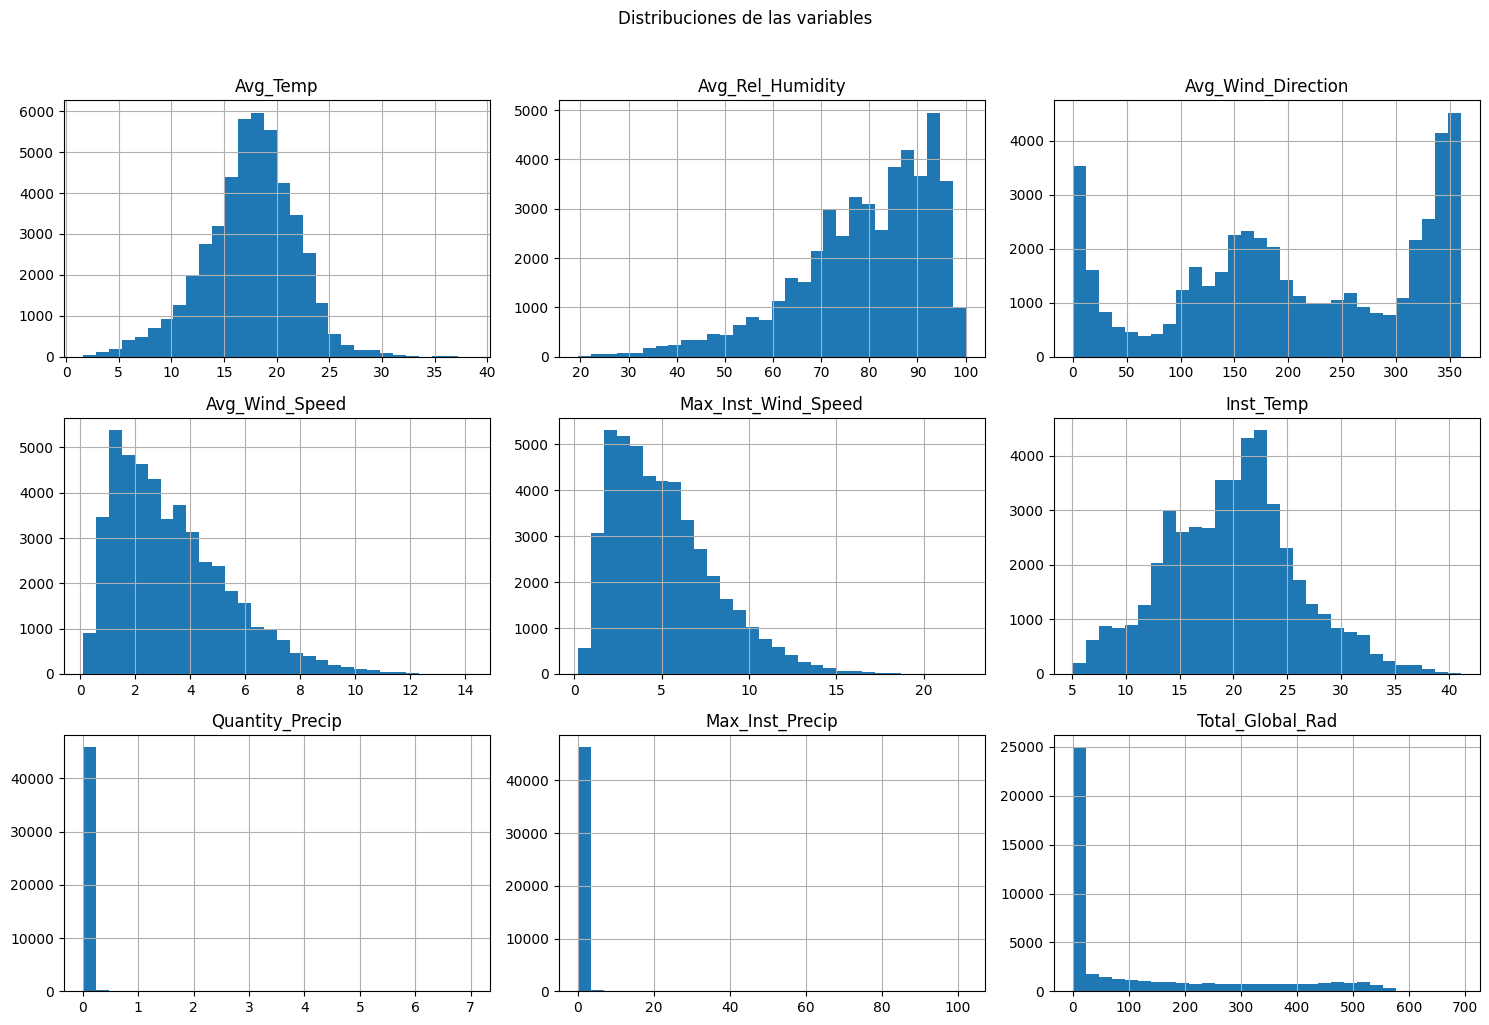

In [ ]:
# Histograms
df_weather.hist(figsize=(15,10), bins=30)
plt.suptitle("Distribuciones de las variables", y=1.02)
plt.tight_layout()
plt.show()

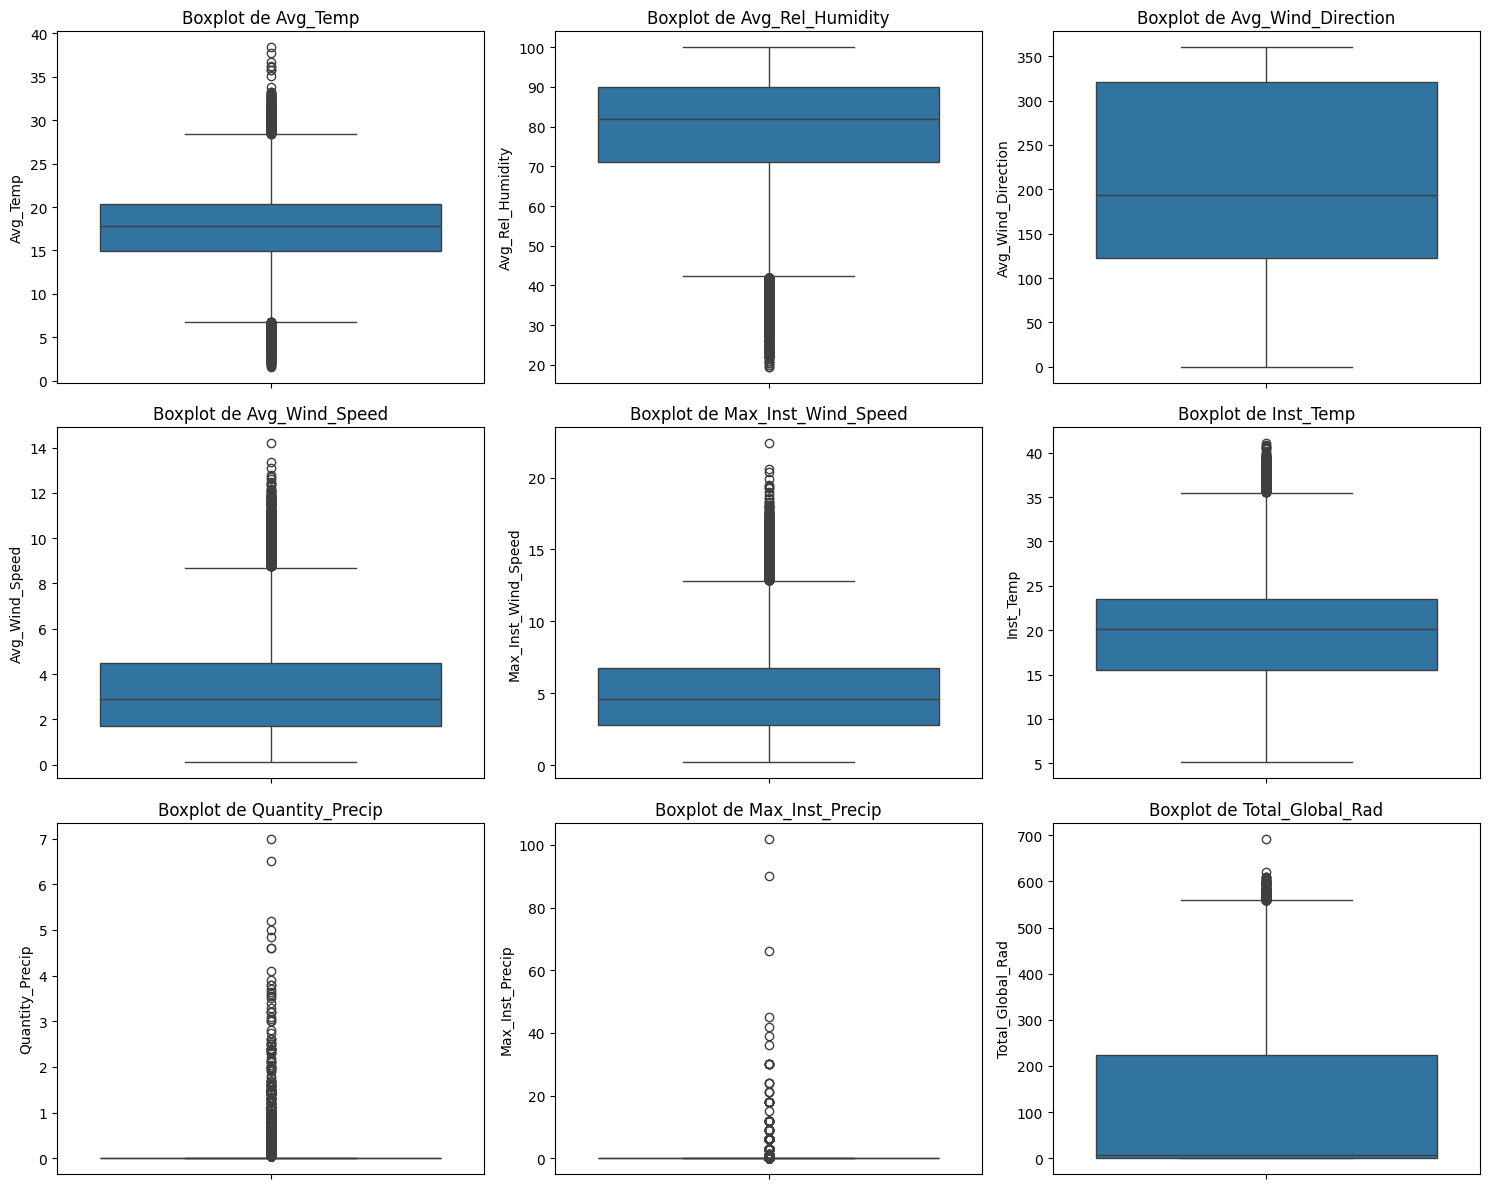

In [ ]:
# Boxplots
# Select numeric columns
num_cols = df_weather.select_dtypes(include="number").columns

# Always to be 3 columns in plot
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df_weather[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")

# Removing empty subplots if needed
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Series Temporales

In [ ]:
# Temperatura
# plt.figure(figsize=(15,6))
# plt.plot(df_weather.index, df_weather["Avg_Temp"], label="Avg_Temp")
# plt.plot(df_weather.index, df_weather["Inst_Temp"], label="Inst_Temp", alpha=0.7)
# plt.legend()
# plt.title("Temperatura a lo largo del tiempo")
# plt.xlabel("Tiempo")
# plt.ylabel("°C")
# plt.show()

# # Humedad relativa
# plt.figure(figsize=(15,5))
# plt.plot(df_weather.index, df_weather["Avg_Rel_Humidity"], color="blue")
# plt.title("Humedad relativa promedio en el tiempo")
# plt.xlabel("Tiempo")
# plt.ylabel("%")
# plt.show()

# # Precipitación
# plt.figure(figsize=(15,5))
# plt.bar(df_weather.index, df_weather["Quantity_Precip"], width=0.01, alpha=0.7)
# plt.title("Precipitación acumulada por intervalo (15 min)")
# plt.xlabel("Tiempo")
# plt.ylabel("mm")
# plt.show()

# # Radiación global
# plt.figure(figsize=(15,5))
# plt.plot(df_weather.index, df_weather["Total_Global_Rad"], color="orange")
# plt.title("Radiación global a lo largo del tiempo")
# plt.xlabel("Tiempo")
# plt.ylabel("W/m²")
# plt.show()


## Correlaciones

In [ ]:
weather_corr_matrix = df_weather.corr()

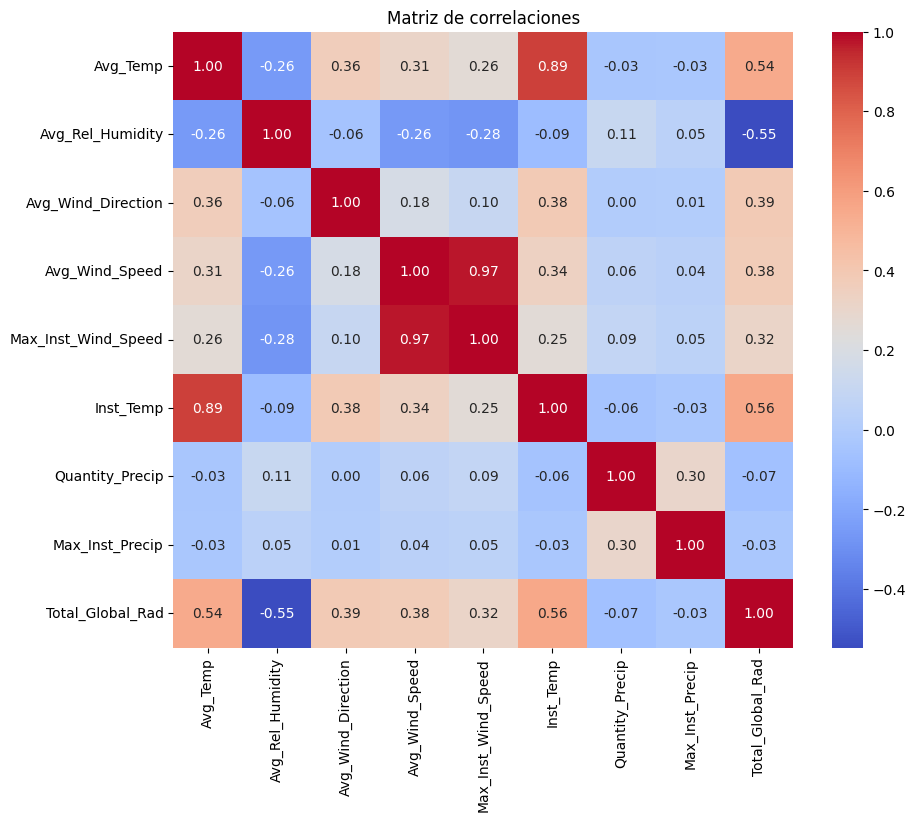

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(weather_corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlaciones")
plt.show()

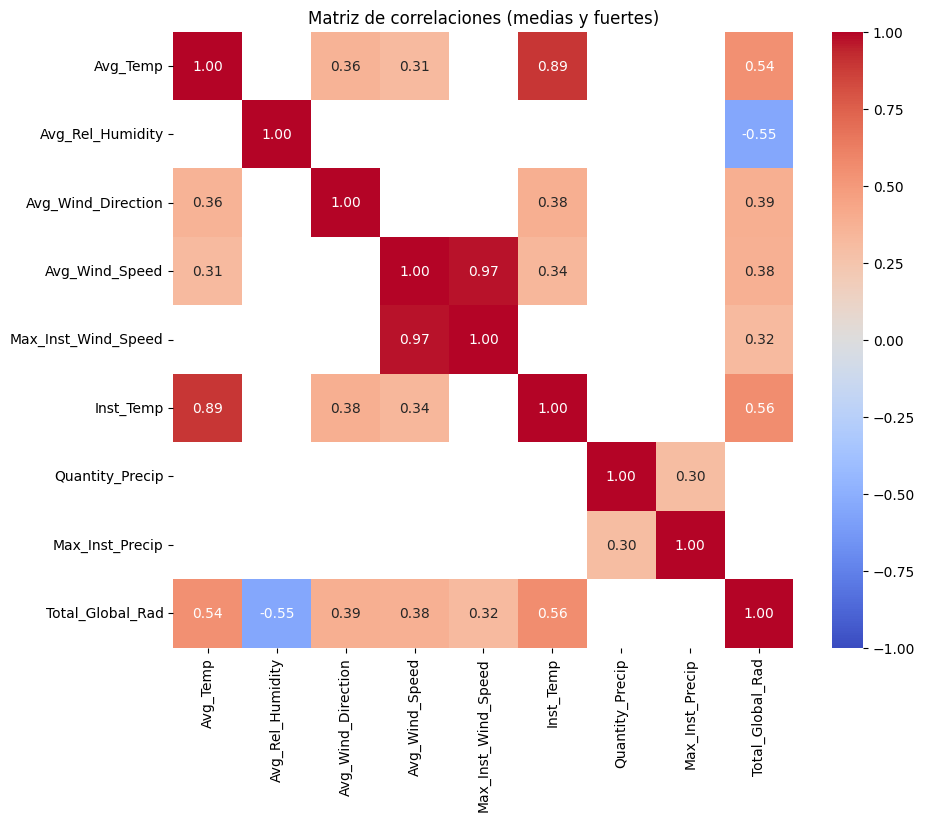

In [ ]:
# Filtro: dejar solo medias (>0.3) o fuertes (<-0.3)
mask = (weather_corr_matrix.abs() >= 0.3)

# Poner a NaN las correlaciones débiles
filtered_corr = weather_corr_matrix.where(mask)

plt.figure(figsize=(10,8))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de correlaciones (medias y fuertes)")
plt.show()

## Relaciones entre variables

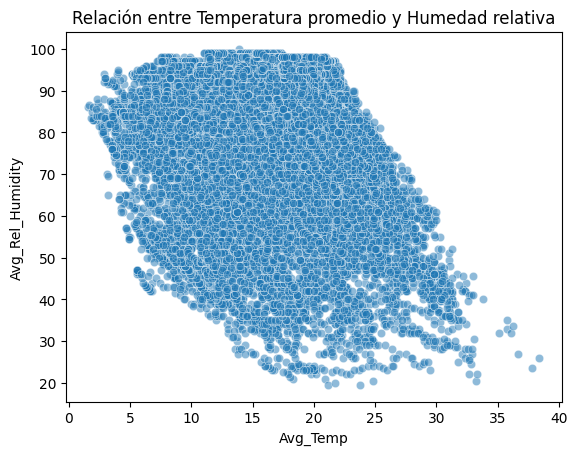

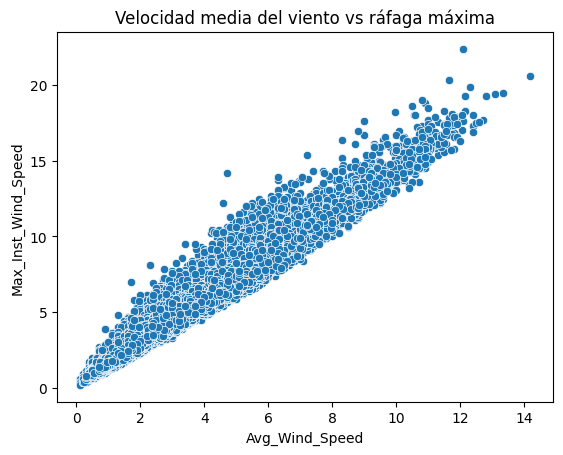

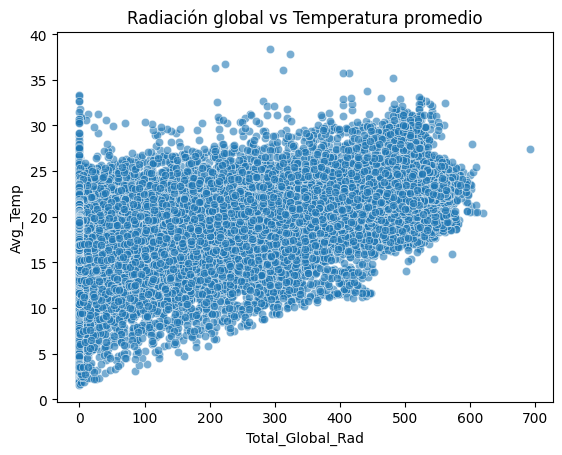

In [ ]:
# Temperatura vs Humedad
sns.scatterplot(x="Avg_Temp", y="Avg_Rel_Humidity", data=df_weather, alpha=0.5)
plt.title("Relación entre Temperatura promedio y Humedad relativa")
plt.show()

# Velocidad del viento
sns.scatterplot(x="Avg_Wind_Speed", y="Max_Inst_Wind_Speed", data=df_weather)
plt.title("Velocidad media del viento vs ráfaga máxima")
plt.show()

# Radiación vs Temperatura
sns.scatterplot(x="Total_Global_Rad", y="Avg_Temp", data=df_weather, alpha=0.6)
plt.title("Radiación global vs Temperatura promedio")
plt.show()

## Patrones diarios y horarios

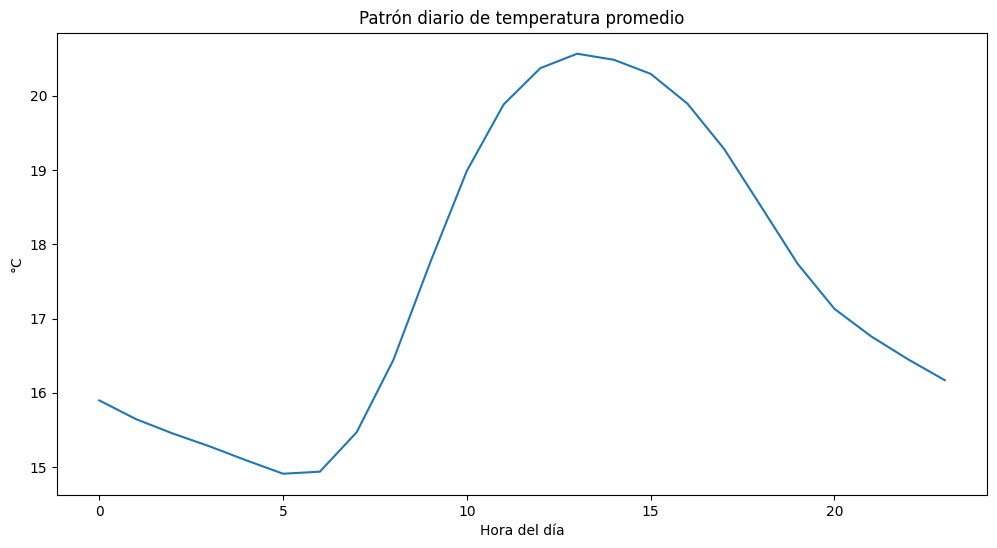

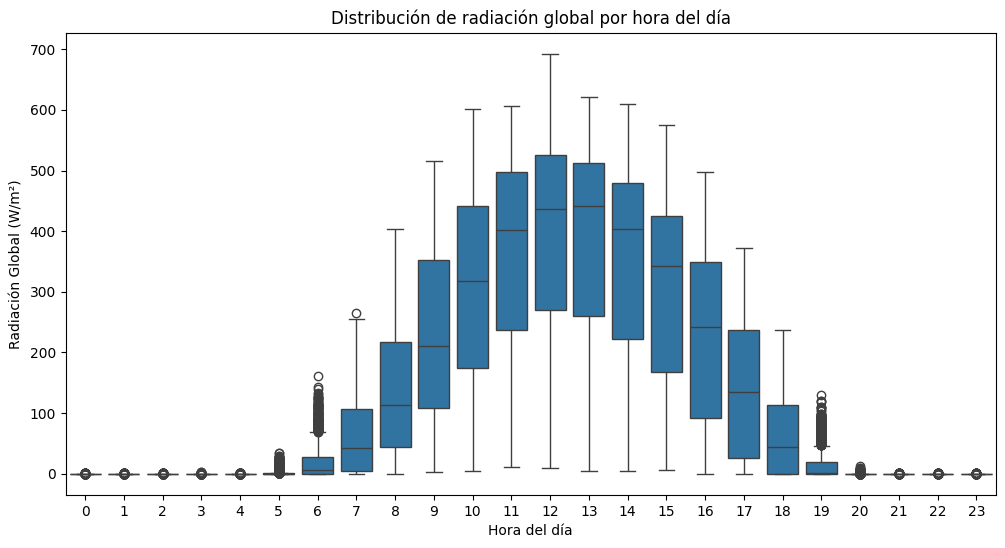

In [ ]:
# Daily pattern of hourly average temperature

plt.figure(figsize=(12,6))
sns.lineplot(
    x=df_weather.index.hour,
    y=df_weather["Avg_Temp"],
    errorbar=None
)
plt.title("Patrón diario de temperatura promedio")
plt.xlabel("Hora del día")
plt.ylabel("°C")
plt.show()

# Boxplot por hora del día
plt.figure(figsize=(12,6))
sns.boxplot(
    x=df_weather.index.hour,
    y=df_weather["Total_Global_Rad"]
)
plt.title("Distribución de radiación global por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Radiación Global (W/m²)")
plt.show()



# df_consumptions_15m EDA

## Standard EDA of df_consumptions_15m

In [ ]:
# Standard EDA of df_consumptions_15m

# 1. Basic info
print("Shape:", df_consumptions_15m.shape)
print("\nData types:")
print(df_consumptions_15m.dtypes)
print("\nTime range:")
print("  Min:", df_consumptions_15m.index.min())
print("  Max:", df_consumptions_15m.index.max())

# 2. Missing values
print("\nMissing values per column:")
print(df_consumptions_15m.isna().sum())

# Count rows where all meters are NaN (ignoring datetime index)
all_nan_rows = df_consumptions_15m.isna().all(axis=1)
print("\nNumber of samples with all meters NaN:", all_nan_rows.sum())

# Aggregate by month
nan_by_month = all_nan_rows.groupby(all_nan_rows.index.strftime("%Y-%m")).sum()

print("\nNumber of samples with all meters NaN per month:")
print(nan_by_month)

# Check if index has regular 15-minute frequency
all_timestamps_in_range = pd.date_range(
    df_consumptions_15m.index.min(),
    df_consumptions_15m.index.max(),
    freq="15min")
missing_timestamps = all_timestamps_in_range.difference(df_consumptions_15m.index)
print("\nNumber of missing timestamps:", len(missing_timestamps))

# 3. Descriptive statistics
print("\nDescriptive statistics:")
display(df_consumptions_15m.describe())


Shape: (46608, 172)

Data types:
Energy_Meter_1      float64
Energy_Meter_2      float64
Energy_Meter_3      float64
Energy_Meter_4      float64
Energy_Meter_5      float64
                     ...   
Energy_Meter_168    float64
Energy_Meter_169    float64
Energy_Meter_170    float64
Energy_Meter_171    float64
Energy_Meter_172    float64
Length: 172, dtype: object

Time range:
  Min: 2022-05-05 12:00:00
  Max: 2023-09-02 23:45:00

Missing values per column:
Energy_Meter_1       4786
Energy_Meter_2       4860
Energy_Meter_3      14991
Energy_Meter_4       6098
Energy_Meter_5       7092
                    ...  
Energy_Meter_168    12669
Energy_Meter_169    22763
Energy_Meter_170    17071
Energy_Meter_171    19438
Energy_Meter_172     5744
Length: 172, dtype: int64

Number of samples with all meters NaN: 2111

Number of samples with all meters NaN per month:
Time
2022-05      0
2022-06      0
2022-07      0
2022-08      0
2022-09     94
          ... 
2023-05      0
2023-06    492
2023-

Energy_Meter_1  Energy_Meter_2  Energy_Meter_3  Energy_Meter_4  \
count    41822.000000    41748.000000    31617.000000    40510.000000   
mean         0.092643        0.062613        0.116356        0.045887   
std          0.104881        0.065718        0.143975        0.102041   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.038000        0.028000        0.044000        0.013000   
50%          0.063000        0.046000        0.079000        0.032000   
75%          0.103000        0.073000        0.105000        0.045000   
max          1.513000        0.962000        1.593000        1.738000   

       Energy_Meter_5  Energy_Meter_6  Energy_Meter_7  Energy_Meter_8  \
count    39516.000000    33408.000000     9938.000000    41731.000000   
mean         0.002955        0.069740        0.024806        0.121322   
std          0.014699        0.286786        0.060112        0.140283   
min          0.000000        0.000000        0.004000        0.000000   
25%          0.000000        0.000000        0.007000        0.027000   
50%          0.000000        0.000000        0.014000        0.095000   
75%          0.000000        0.000000        0.021000        0.155000   
max          1.032000        1.594000        0.979000        1.412000   

       Energy_Meter_9  Energy_Meter_10  Energy_Meter_11  Energy_Meter_12  \
count    41713.000000     40419.000000     40783.000000     26060.000000   
mean         0.092286         0.015918         0.301590         0.177726   
std          0.087209         0.026667         0.247607         0.213093   
min          0.000000         0.000000         0.000000         0.000000   
25%          0.051000         0.005000         0.147000         0.063000   
50%          0.072000         0.008000         0.198000         0.094000   
75%          0.098000         0.019000         0.364000         0.172000   
max          0.772000         0.560000         1.974000         1.697000   

       Energy_Meter_13  Energy_Meter_14  Energy_Meter_15  Energy_Meter_16  \
count     33506.000000     23804.000000     41719.000000     41657.000000   
mean          0.337226         0.100962         0.122953         0.024479   
std           0.220317         0.108193         0.101536         0.031030   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.186000         0.043000         0.072000         0.002000   
50%           0.246000         0.065000         0.098000         0.003000   
75%           0.452000         0.101000         0.130000         0.061000   
max           1.460000         1.349000         1.199000         0.122000   

       Energy_Meter_17  Energy_Meter_18  Energy_Meter_19  Energy_Meter_20  \
count     41837.000000     28512.000000     25272.000000     35863.000000   
mean          0.106709         0.406428         0.004916         0.071348   
std           0.102872         0.130259         0.047306         0.043194   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.057000         0.314000         0.000000         0.044000   
50%           0.081000         0.403000         0.000000         0.065000   
75%           0.112000         0.494000         0.000000         0.088000   
max           1.382000         0.909000         0.679000         0.662000   

       Energy_Meter_21  Energy_Meter_22  Energy_Meter_23  Energy_Meter_24  \
count     40680.000000     25841.000000     33566.000000     32368.000000   
mean          0.007471         0.065464         0.006717         0.028901   
std           0.067648         0.087892         0.071270         0.058550   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.019000         0.000000         0.010000   
50%           0.000000         0.035000         0.000000         0.018000   
75%           0.000000         0.065000         0.000000         0.023000   
ma

## Check for duplicated sample times
May occur due to daylight saving time changes


In [ ]:
# Check for duplicated sample times (may occur due to daylight saving time changes)

# Group by hour from the datetime index
hourly_counts = df_consumptions_15m.index.floor("h").value_counts().sort_index()

# Filter only hours where there are duplicate samples
duplicate_hours = hourly_counts[hourly_counts > 4]  # since 1 hour should have max 4 samples (15min each)

print("Hours with duplicate samples (it should be empty):")
print(duplicate_hours)


Hours with duplicate samples (it should be empty):
Series([], Name: count, dtype: int64)


# Feature engineering

## Create total_consumption
As the sum of all Energy_meter_N and by interpolating the missing values

In [ ]:
# Calcular el consumo total sumando las columnas Energy_Meter_N
# min_count=1 para que el resultado sea NaN si todos los valores son NaN.
df_consumptions_15m['total_consumption'] = df_consumptions_15m.filter(regex='^Energy_Meter_').sum(axis=1, min_count=1)


In [ ]:
# Interpolate missing total_consumption values, counting how many are interpolated
# Paso 2: Guardar una máscara de los valores NaN antes de interpolar.
mask_nan_antes = df_consumptions_15m['total_consumption'].isna()

# Paso 3: Interpolar los valores faltantes usando un método basado en el tiempo.
# limit_area='inside' evita rellenar al principio o al final de la serie.
df_consumptions_15m['total_consumption'] = (
    df_consumptions_15m['total_consumption']
    .interpolate(method='time', limit_area='inside')
)

# Paso 4: Contar cuántos valores se han rellenado después de la interpolación.
mask_nan_despues = df_consumptions_15m['total_consumption'].isna()
num_interpolados = (mask_nan_antes & ~mask_nan_despues).sum()

print(f"Se han interpolado {num_interpolados} valores de 'total_consumption' que faltaban (NaN) en la serie original.")

# Verificar el resultado
print(f"Forma del dataframe: {df_consumptions_15m.shape}")
print("\nEstadísticas de total_consumption:")
print(df_consumptions_15m['total_consumption'].describe())

Se han interpolado 2111 valores de 'total_consumption' que faltaban (NaN) en la serie original.
Forma del dataframe: (46608, 173)

Estadísticas de total_consumption:
count    46608.000000
mean        11.884714
std          5.431552
min          0.000000
25%          8.925000
50%         11.786000
75%         15.178000
max         34.539000
Name: total_consumption, dtype: float64


## total_consumption EDA

### Visual exploration of total_consumption

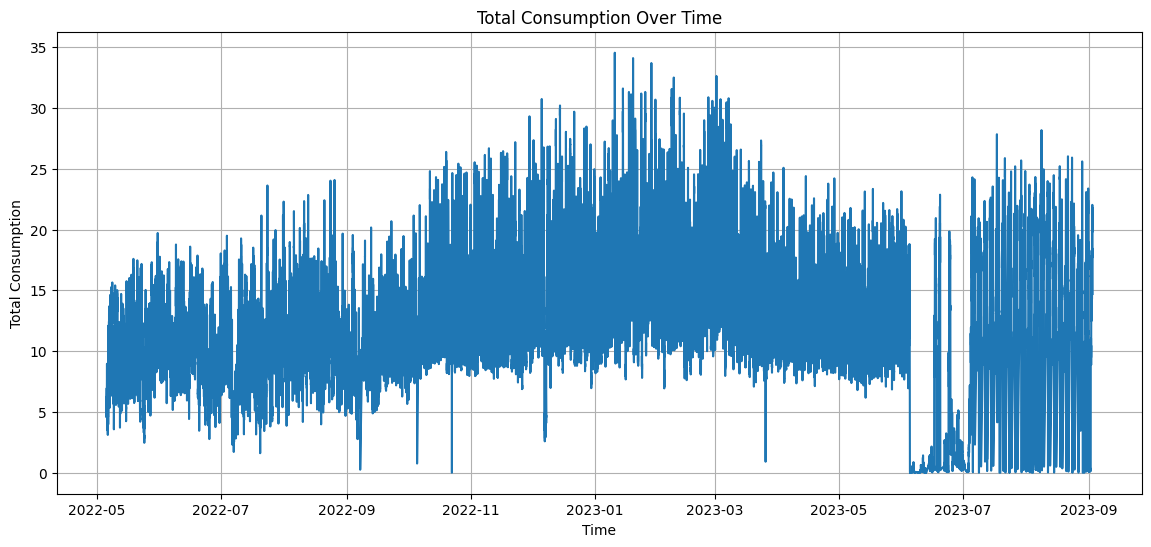

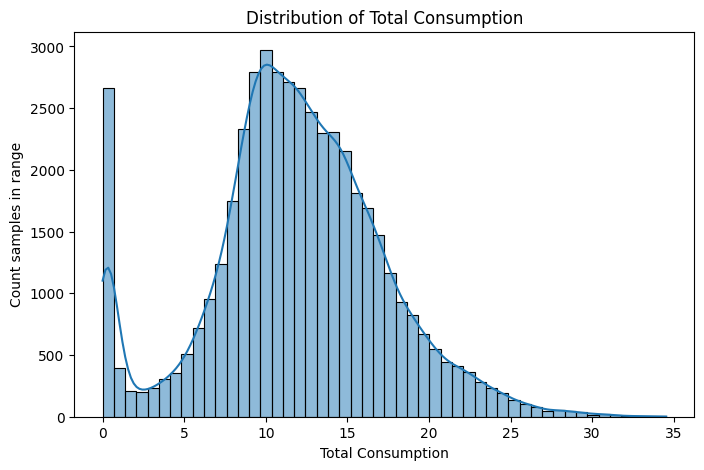

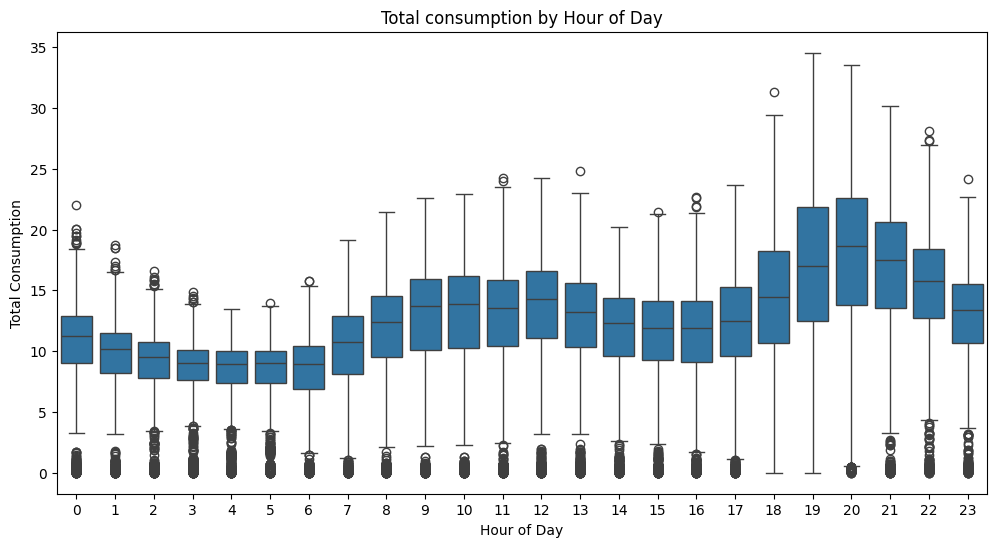

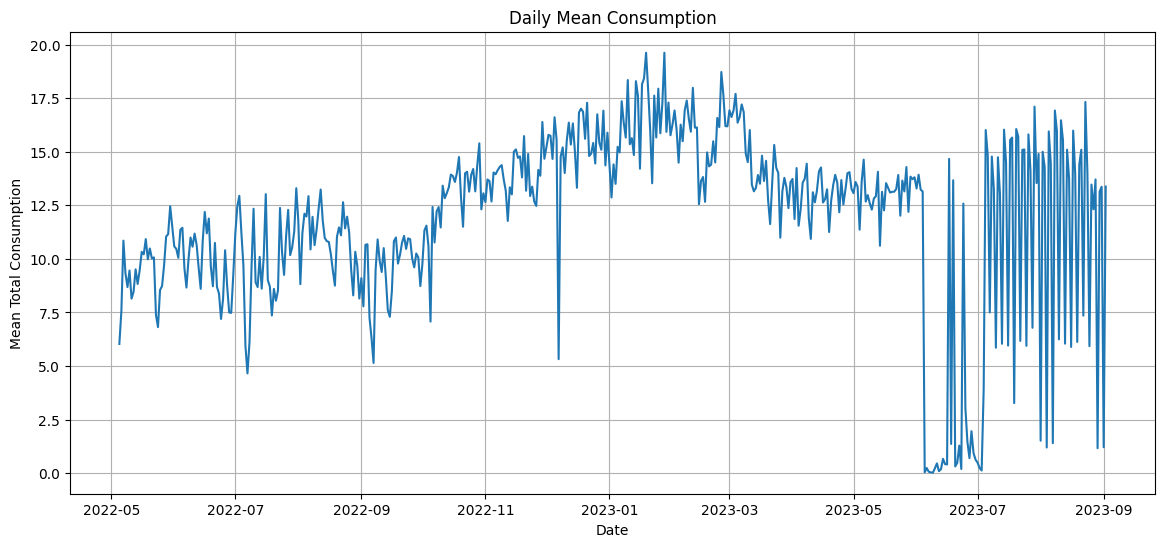

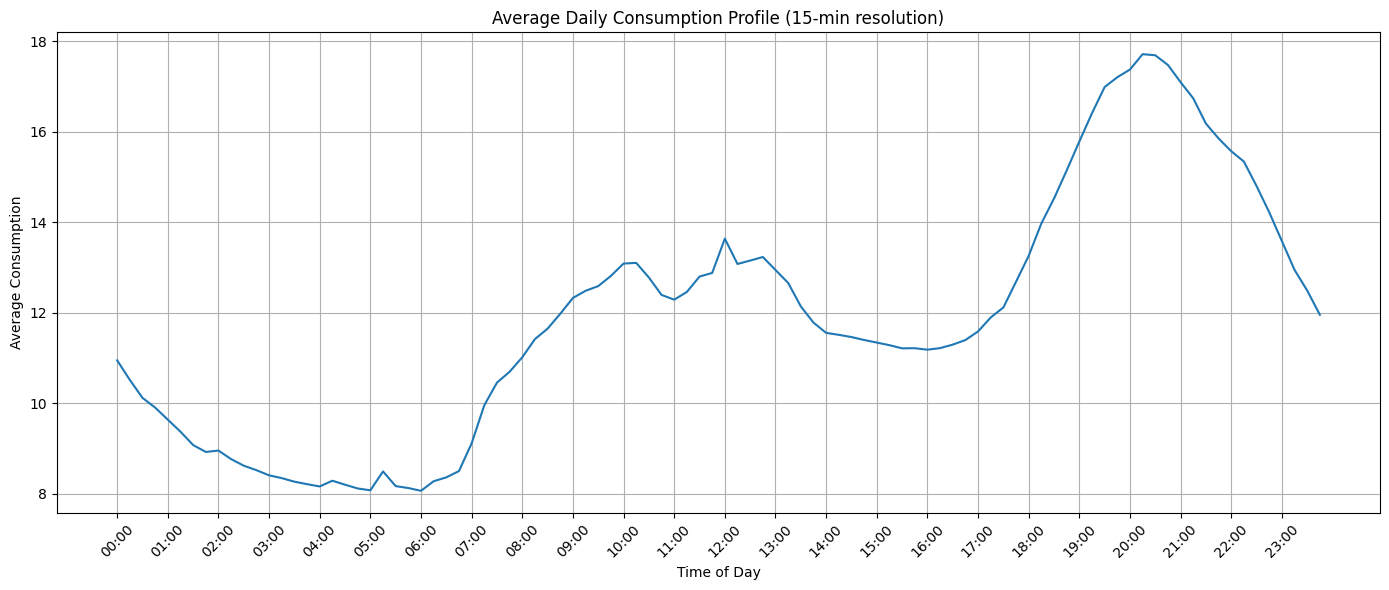

In [ ]:
# 4. Visual exploration
plt.figure(figsize=(14, 6))
plt.plot(df_consumptions_15m.index, df_consumptions_15m["total_consumption"])
plt.title("Total Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Total Consumption")
plt.grid(True)
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_consumptions_15m["total_consumption"], bins=50, kde=True)
plt.title("Distribution of Total Consumption")
plt.xlabel("Total Consumption")
plt.ylabel("Count samples in range")
plt.show()

# Boxplot by hour of day
df_consumptions_15m["hour"] = df_consumptions_15m.index.hour
plt.figure(figsize=(12, 6))
sns.boxplot(
    x=df_consumptions_15m.index.hour,
    y=df_consumptions_15m["total_consumption"]
)
plt.title("Total consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Consumption")
plt.show()

# 5. Aggregations
# Daily mean consumption
daily_mean = df_consumptions_15m.resample("D")["total_consumption"].mean()

plt.figure(figsize=(14, 6))
plt.plot(daily_mean.index, daily_mean.values)
plt.title("Daily Mean Consumption")
plt.xlabel("Date")
plt.ylabel("Mean Total Consumption")
plt.grid(True)
plt.show()

# Average daily profile (mean 15-min pattern)
# .time extracts only the time of day part (HH:MM:SS) from each timestamp, ignoring the date
plt.figure(figsize=(14, 6))
avg_daily_profile = df_consumptions_15m.groupby(df_consumptions_15m.index.time)["total_consumption"].mean()
time_labels = [t.strftime("%H:%M") for t in avg_daily_profile.index]
plt.plot(time_labels, avg_daily_profile.values)
# Show fewer labels on the X axis (every 4th tick = 1 hour so data is 15min spaced)
step = 4
plt.xticks(time_labels[::step], rotation=45)
plt.title("Average Daily Consumption Profile (15-min resolution)")
plt.xlabel("Time of Day")
plt.ylabel("Average Consumption")
plt.grid(True)
plt.tight_layout()
plt.show()


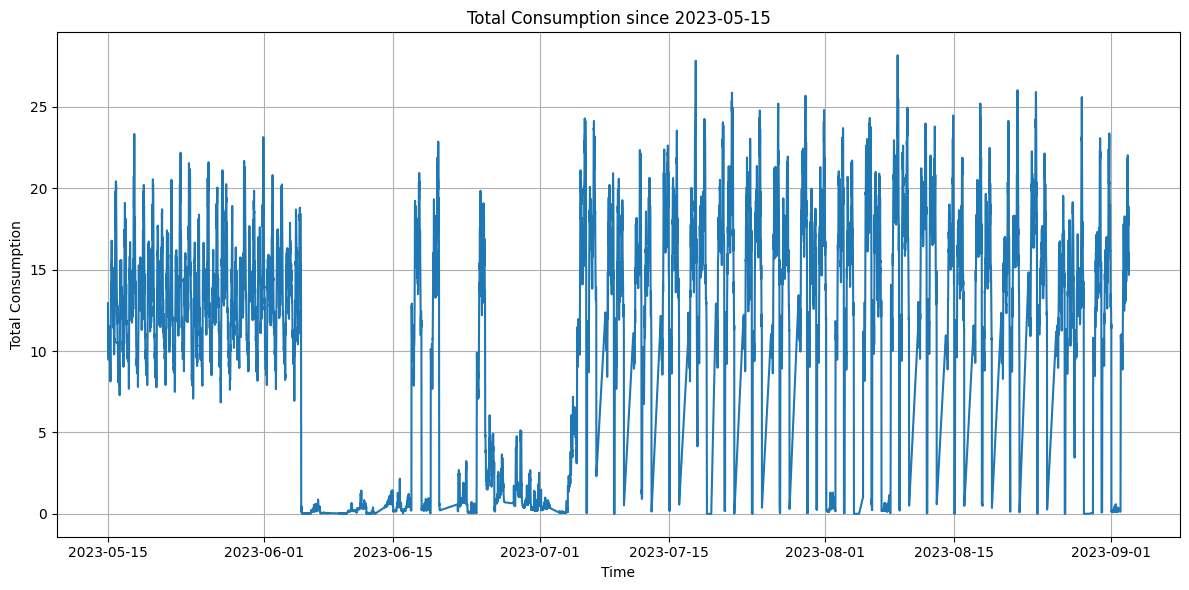

In [ ]:
# Plot slice of total_consumption serie
date_start_plot = '2023-05-15' # None # '2023-06-01'
date_end_plot = None # '2023-05-31'

#data_to_plot = df_consumptions_15m.loc["2023-01-01 00:00:00":, "total_consumption"]
data_to_plot = df_consumptions_15m.loc[date_start_plot : date_end_plot, "total_consumption"]

plt.figure(figsize=(12, 6))
plt.plot(data_to_plot.index, data_to_plot.values)

title = "Total Consumption"
if date_start_plot:
  title += " since " + date_start_plot
if date_end_plot:
  title += " until " + date_end_plot
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Total Consumption")
plt.grid(True)
plt.tight_layout()
plt.show()


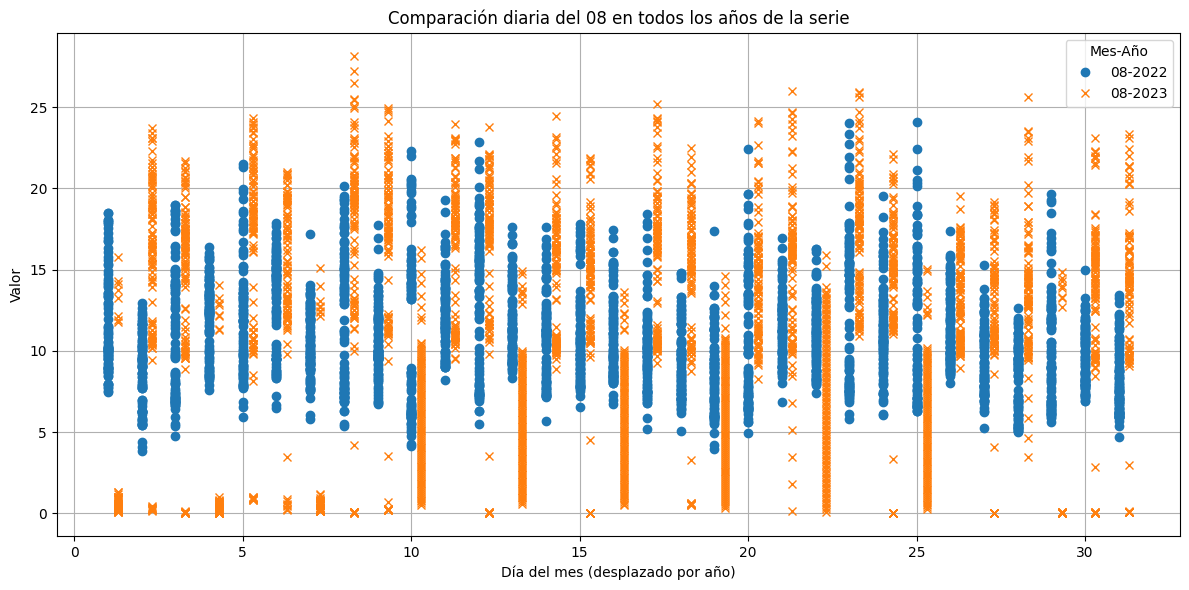

In [ ]:
plot_month_consumption_evolution(df_consumptions_15m['total_consumption'], 8)



### Plot the outliers of total_consumption at a selected hour

In [ ]:
# # Plot the outliers of total_consumption at a selected hour

# hour_to_show_outliers = 11

# # Filtrar outliers de la hora elegida
# outliers_hora = outliers[outliers['hora'] == hour_to_show_outliers].copy()
# outliers_hora['dia_del_ano'] = outliers_hora.index.dayofyear

# # Obtener máximo valor de esa hora (solo entre outliers)
# max_val_hora = outliers_hora['total_consumption'].max()

# # --- Obtener la media de esos días para la hora seleccionada ---
# # Filtramos en df_consumptions_15m las filas de la hora y días con outliers
# medias_hora = df_consumptions_15m[
#     (df_consumptions_15m['hora'] == hour_to_show_outliers) &
#     (df_consumptions_15m.index.dayofyear.isin(outliers_hora['dia_del_ano']))
# ].copy()

# # Promediamos por día
# medias_hora['dia_del_ano'] = medias_hora.index.dayofyear
# media_por_dia = medias_hora.groupby('dia_del_ano')['media_hora'].mean()

# # ==============================
# # Graficar
# # ==============================
# plt.figure(figsize=(12, 6))

# # Outliers
# plt.scatter(
#     outliers_hora['dia_del_ano'],
#     outliers_hora['total_consumption'],
#     color='red',
#     alpha=0.7,
#     label='Outliers'
# )

# # Media de esos días
# plt.plot(
#     media_por_dia.index,
#     media_por_dia.values,
#     color='blue',
#     marker='o',
#     linestyle='-',
#     label='Media (hora seleccionada)'
# )

# plt.title(f'Outliers y media para la hora {hour_to_show_outliers}')
# plt.xlabel('Día del año')
# plt.ylabel('Total Consumption')
# plt.ylim(0, max_val_hora * 1.05)
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.legend()
# plt.show()


## Discard samples since 2023-06-01 to end

In [ ]:
# Remove rows with dates greater than or equal to June 1, 2023
# Because the data from those dates is highly variable and very likely to be outliers
df_consumptions_15m = df_consumptions_15m[df_consumptions_15m.index < '2023-06-01']

print("Minimum date:", df_consumptions_15m.index.min())
print("Maximum date:", df_consumptions_15m.index.max())


Minimum date: 2022-05-05 12:00:00
Maximum date: 2023-05-31 23:45:00


## total_consumption comparison before and after cut

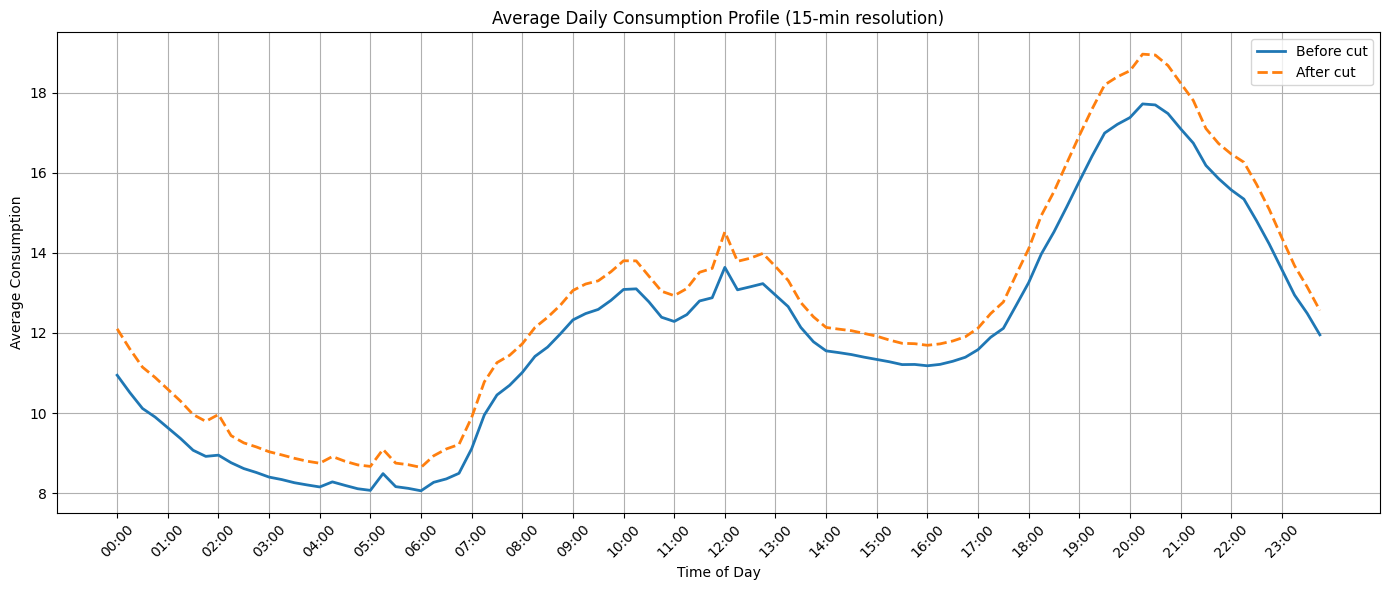

In [ ]:
# Comparison of average daily profiles (mean 15-min pattern) before and after cut
plt.figure(figsize=(14, 6))

# Compute the average daily profile after the cut
avg_daily_profile_after_cut = df_consumptions_15m.groupby(df_consumptions_15m.index.time)["total_consumption"].mean()

# Time labels (HH:MM) extracted from the index of the original profile
time_labels = [t.strftime("%H:%M") for t in avg_daily_profile.index]

# Plot both curves
plt.plot(time_labels, avg_daily_profile.values, label="Before cut", linewidth=2)
plt.plot(time_labels, avg_daily_profile_after_cut.values, label="After cut", linewidth=2, linestyle="--")

# Show fewer labels on the X axis (every 4th tick = 1 hour since data is 15-min spaced)
step = 4
plt.xticks(time_labels[::step], rotation=45)

# Titles and legend
plt.title("Average Daily Consumption Profile (15-min resolution)")
plt.xlabel("Time of Day")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Create hour_sin hour_cos dow_sin dow_cos

In [ ]:
df_consumptions_15m = add_time_features(df_consumptions_15m)

print("Las columnas 'hour_sin', 'hour_cos', 'dow_sin' (dow = Day Of Week) y 'dow_cos' han sido añadidas a df_consumptions_15m")


Las columnas 'hour_sin', 'hour_cos', 'dow_sin' (dow = Day Of Week) y 'dow_cos' han sido añadidas a df_consumptions_15m


## Create daylight_fraction, solar_hour_...

In [ ]:
# Set Loureiro (mainland Portugal) location info
LOUREIRO_LOCATION_INFO = LocationInfo(
    name="Local",
    region="PT",
    timezone="Europe/Lisbon",
    latitude=40.8167,
    longitude=-8.5333
)

# Llama a la función para añadir las 3 columnas a tu DataFrame df_consumptions_15m
df_consumptions_15m = add_solar_time_features(df_consumptions_15m, LOUREIRO_LOCATION_INFO)

print("Las columnas 'daylight_fraction', 'solar_hour_sin', y 'solar_hour_cos' han sido añadidas a df_consumptions_15m")


Las columnas 'daylight_fraction', 'solar_hour_sin', y 'solar_hour_cos' han sido añadidas a df_consumptions_15m


## Visual exploration of solar time features: daylight_fraction, solar_hour_...

Generate a comparative plot of the evolution of chosen feature during the first N days of each month, from start_month to end_month, using the data from the DataFrame df_consumptions_15m.

Procesado: Jun 2022 - 96 registros
Procesado: Jul 2022 - 96 registros
Procesado: Ago 2022 - 96 registros
Procesado: Sep 2022 - 96 registros
Procesado: Oct 2022 - 96 registros
Procesado: Nov 2022 - 96 registros
Procesado: Dic 2022 - 96 registros
Procesado: Ene 2023 - 96 registros
Procesado: Feb 2023 - 96 registros
Procesado: Mar 2023 - 96 registros
Procesado: Abr 2023 - 96 registros
Procesado: May 2023 - 96 registros

Comparación de los primeros 1 días de cada mes
Período: 2022-06 a 2023-05
Procesado: Jun 2022 - 96 registros
Procesado: Jul 2022 - 96 registros
Procesado: Ago 2022 - 96 registros
Procesado: Sep 2022 - 96 registros
Procesado: Oct 2022 - 96 registros
Procesado: Nov 2022 - 96 registros
Procesado: Dic 2022 - 96 registros
Procesado: Ene 2023 - 96 registros
Procesado: Feb 2023 - 96 registros
Procesado: Mar 2023 - 96 registros
Procesado: Abr 2023 - 96 registros
Procesado: May 2023 - 96 registros

Comparación de los primeros 1 días de cada mes
Período: 2022-06 a 2023-05
Se observa

(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Comparación de daylight_fraction\nPrimeros 1 días de cada mes'}, xlabel='Horas desde el inicio del período (0 = 00:00 del día 1)', ylabel='Fracción de luz diurna (0–1)'>)

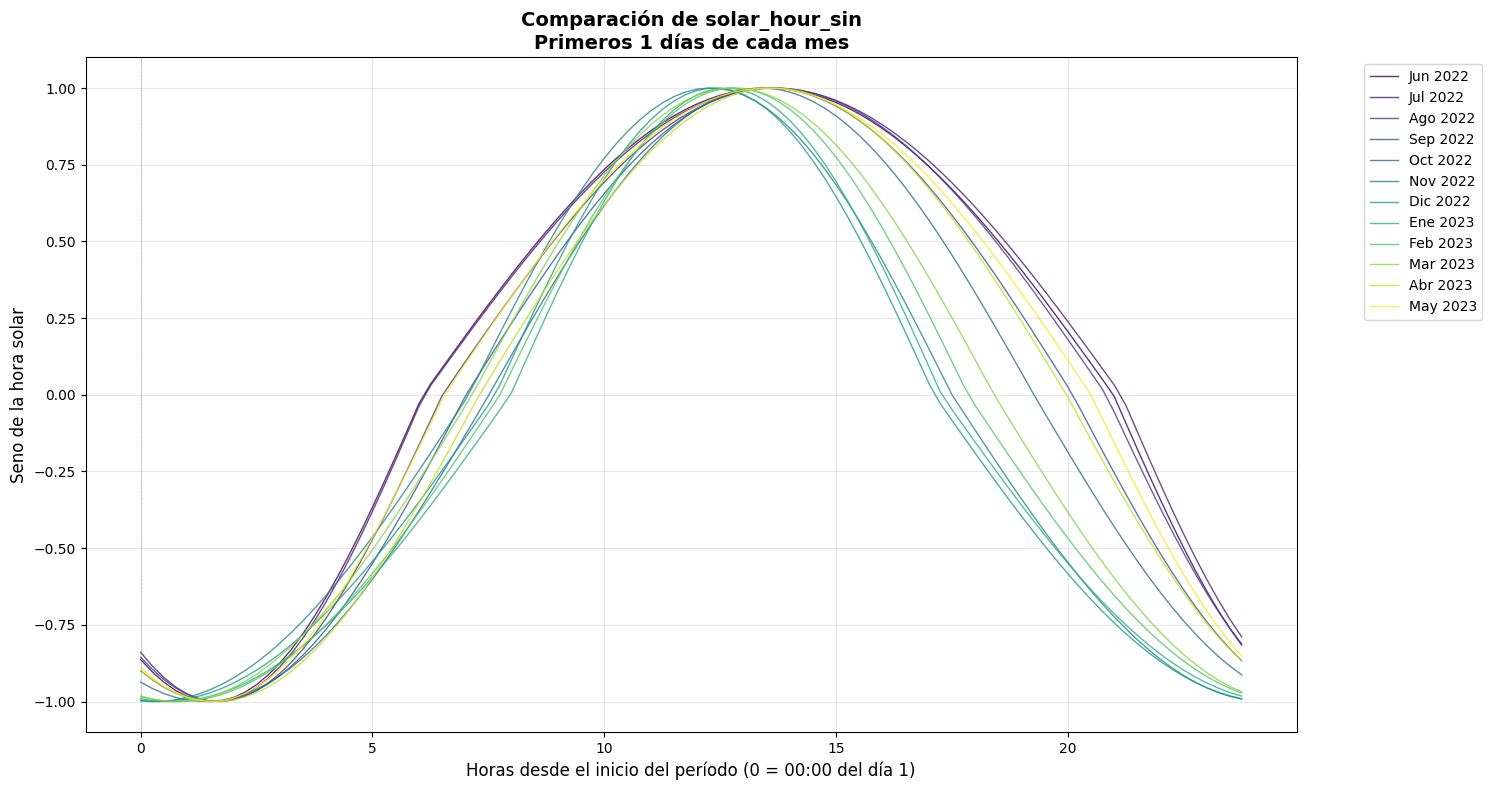

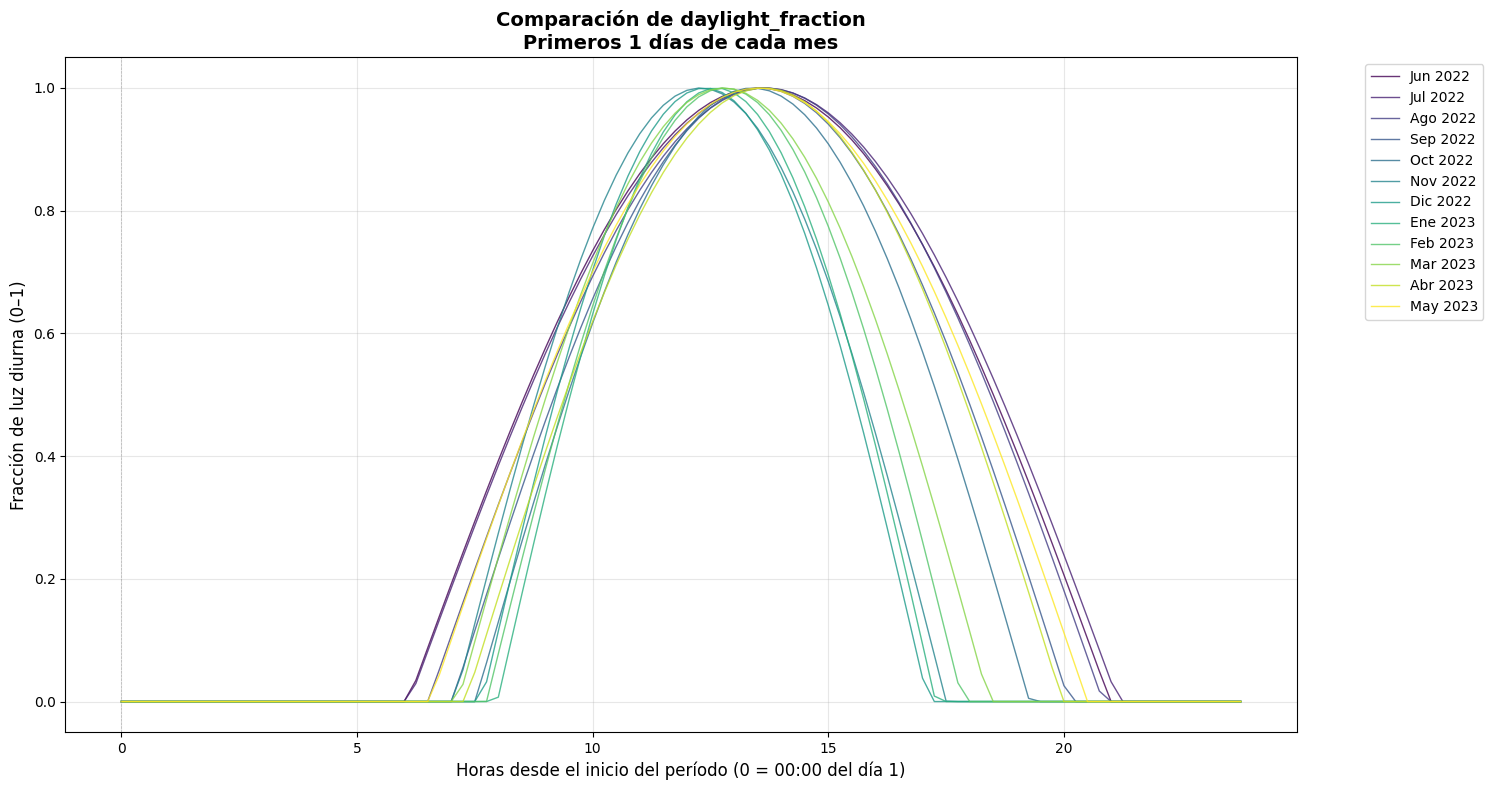

In [ ]:
plot_feature_by_month(df_consumptions_15m, 'solar_hour_sin', 1, '2022-06', '2023-05')
plot_feature_by_month(df_consumptions_15m, 'daylight_fraction', 1, '2022-06', '2023-05')

## Create working_day
- 1 is working day
- 0 is non working day



In [ ]:
# Accede a las propiedades de fecha desde el índice
weekends = df_consumptions_15m.index.dayofweek >= 5

# Paso 2: Crear la máscara para días festivos
# Compara el índice de consumo normalizado con la lista de festivos
holidays_mask = df_consumptions_15m.index.normalize().isin(df_holidays['date'])

# Paso 3: Combinar fines de semana y festivos (días NO laborables)
non_working_days = weekends | holidays_mask

# Paso 4: Crear la columna 'working_day' (1 para laborable, 0 para no laborable)
df_consumptions_15m['working_day'] = (~non_working_days).astype(int)

print("La columna 'working_day' ha sido añadida a df_consumptions_15m")

# --- Verificaciones y uso posterior (sin cambios) ---
print("Distribución de días laborables vs no laborables:")
print(df_consumptions_15m['working_day'].value_counts() / (24 * 4))

print(f"Registros que coinciden con festivos: {holidays_mask.sum()}")
print(f"Registros que son fines de semana: {weekends.sum()}")

La columna 'working_day' ha sido añadida a df_consumptions_15m
Distribución de días laborables vs no laborables:
working_day
1    267.5
0    124.0
Name: count, dtype: float64
Registros que coinciden con festivos: 1440
Registros que son fines de semana: 10752


## DF_MODEL_DATA building

In [ ]:
df_model_data = create_df_model_data(df_consumptions_15m, df_weather)

print("\ndf_model_data creado")

print(df_model_data.describe())



df_model_data creado
       total_consumption  solar_hour_sin  solar_hour_cos      hour_sin  \
count       36239.000000    36239.000000    36239.000000  36239.000000   
mean           12.781442        0.015186       -0.000747     -0.000831   
std             4.476414        0.706964        0.707106      0.707124   
min             0.000000       -1.000000       -1.000000     -1.000000   
25%             9.611000       -0.692928       -0.707649     -0.707107   
50%            12.228000        0.035392       -0.002623      0.000000   
75%            15.260500        0.720420        0.706191      0.707107   
max            34.539000        1.000000        1.000000      1.000000   

           hour_cos       dow_sin       dow_cos   working_day  \
count  3.623900e+04  36239.000000  36239.000000  36239.000000   
mean  -1.370326e-04     -0.000602      0.001200      0.684760   
std    7.071081e-01      0.707399      0.706832      0.464618   
min   -1.000000e+00     -0.974928     -0.900969    

## Features selection

### Histogram of feature correlations with total_consumption

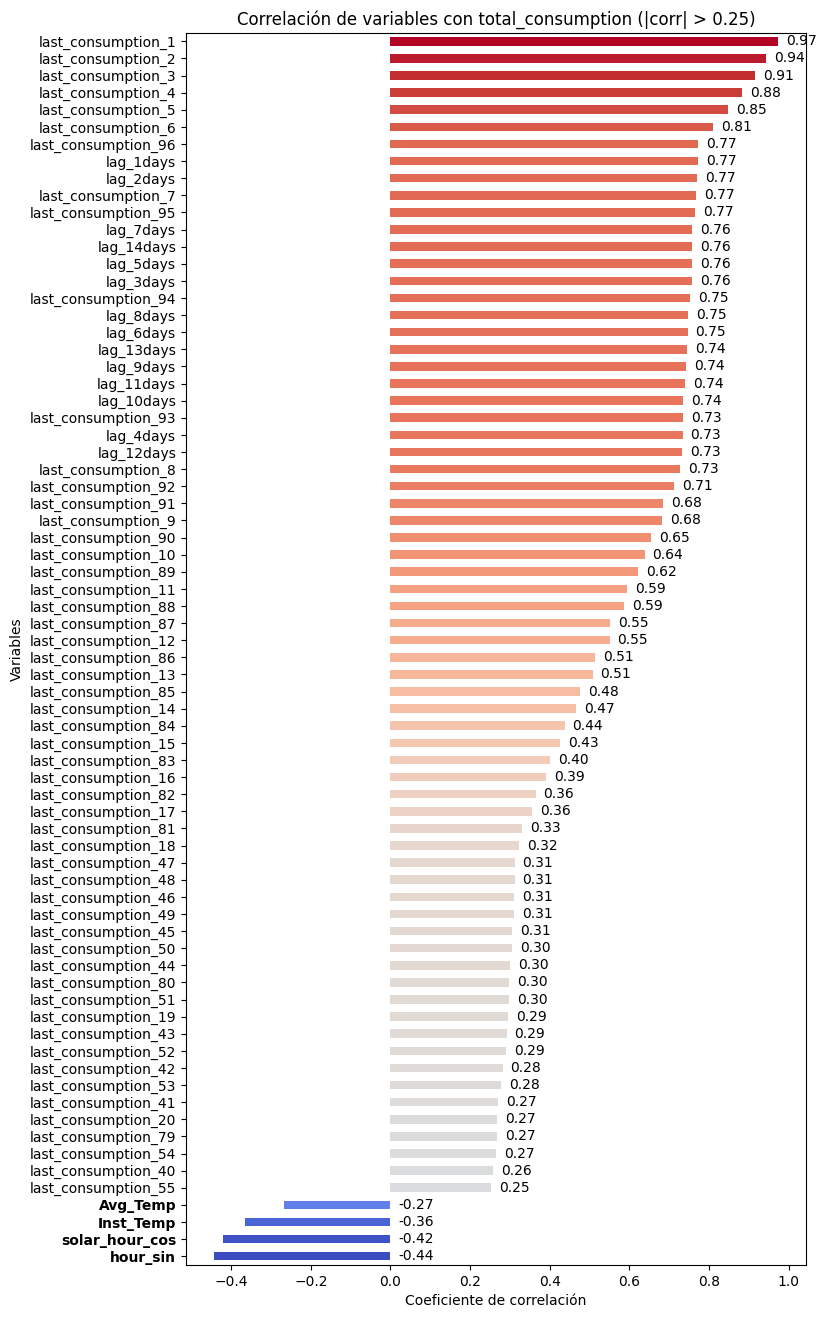

In [ ]:
# Graficar correlación de las variables con la variable objetivo total_consumption

# Calcular correlaciones con la variable objetivo
corr_matrix = df_model_data.corr()
corr_with_target = corr_matrix["total_consumption"].drop("total_consumption")

# Filtrar por |corr| > 0.25 y ordenar
corr_with_target = corr_with_target[abs(corr_with_target) > 0.25].sort_values(ascending=False)

plt.figure(figsize=(8,16))

# Colorear barras según magnitud (más fuerte si |corr| es mayor)
colors = plt.cm.coolwarm((corr_with_target - corr_with_target.min()) /
                         (corr_with_target.max() - corr_with_target.min()))

ax = corr_with_target.plot(kind="barh", color=colors)

plt.title("Correlación de variables con total_consumption (|corr| > 0.25)")
plt.xlabel("Coeficiente de correlación")
plt.ylabel("Variables")

# Añadir valores en las barras con un pequeño espacio
offset = 0.02
for p in ax.patches:
    value = p.get_width()
    y = p.get_y() + p.get_height() / 2

    if value >= 0:
        ax.annotate(f"{value:.2f}",
                    (value + offset, y),
                    ha='left', va='center', fontsize=10, color="black")
    else:
        ax.annotate(f"{value:.2f}",
                    (0 + offset, y),
                    ha='left', va='center', fontsize=10, color="black")

# Poner en negrita nombres de variables que no empiecen con last_ ni lag_
labels = ax.get_yticklabels()
for label in labels:
    text = label.get_text()
    if not (text.startswith("last_") or text.startswith("lag_")):
        label.set_fontweight("bold")

plt.gca().invert_yaxis()  # mayor correlación arriba
plt.show()


### Feature selection comparing methods correlation, MI and LASSO

In [ ]:
# Feature selection comparing methods correlation, MI (Mutual Information) and LASSO

from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. Definir X (features) y y (target)
# -----------------------------
target = "total_consumption"
X = df_model_data.drop(columns=[target])
y = df_model_data[target]

# -----------------------------
# 2. Selección por correlación
# -----------------------------
print("\n=== Calculado correlación lineal ===")
%time corrs = df_model_data.corr(numeric_only=True)[target].drop(target)  # quitar self-corr
corr_selected = corrs[abs(corrs) > 0.25].sort_values(ascending=False)

print(f"=== {len(corr_selected)} features seleccionadas por correlación (|corr| > 0.25) ===")
print(corr_selected.index.to_list())

# -----------------------------
# 3. Selección por Mutual Information
# -----------------------------
print("\n=== Calculando correlación por Mutual Informacion ===")
%time mi_scores = mutual_info_regression(X, y, random_state=42)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Se selecciona la misma cantidad que ha sido determinada por abs(corr) > 0.25
print(f"\n=== Top {len(corr_selected)} features por Mutual Information ===")
print(mi_series.head(len(corr_selected)).index.to_list())

# -----------------------------
# 4. Selección por Lasso (regularización L1)
# -----------------------------
print("\n=== Computing LASSO ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

%time lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

lasso_coefs = pd.Series(lasso.coef_, index=X.columns)
lasso_selected = lasso_coefs[lasso_coefs != 0].sort_values(key=abs, ascending=False)

print(f"\n=== {len(lasso_selected)} features seleccionadas por Lasso (Lasso coef != 0) ===")
print(lasso_selected.index.to_list())

# -----------------------------
# 5. Comparación resumida
# -----------------------------
print("\n=== Resumen ===")
print(f"Por correlación (umbral 0.25): {corr_selected.index.to_list()}")
print(f"Por MI (top 10): {mi_series.head(10).index.to_list()}")
print(f"Por Lasso: {lasso_selected.index.to_list()}")



=== Calculado correlación lineal ===
CPU times: user 2.14 s, sys: 12.6 ms, total: 2.15 s
Wall time: 3.01 s
=== 72 features seleccionadas por correlación (|corr| > 0.25) ===
['last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'last_consumption_96', 'lag_1days', 'lag_2days', 'last_consumption_7', 'last_consumption_95', 'lag_7days', 'lag_14days', 'lag_5days', 'lag_3days', 'last_consumption_94', 'lag_8days', 'lag_6days', 'lag_13days', 'lag_9days', 'lag_11days', 'lag_10days', 'last_consumption_93', 'lag_4days', 'lag_12days', 'last_consumption_8', 'last_consumption_92', 'last_consumption_91', 'last_consumption_9', 'last_consumption_90', 'last_consumption_10', 'last_consumption_89', 'last_consumption_11', 'last_consumption_88', 'last_consumption_87', 'last_consumption_12', 'last_consumption_86', 'last_consumption_13', 'last_consumption_85', 'last_consumption_14', 'last_consumption_84', 'last_consumption_15', 'la

KeyboardInterrupt: 

NameError: name 'mi_scores' is not defined

### Feature selection using Random Forest

Features (128): ['daylight_fraction', 'solar_hour_sin', 'solar_hour_cos', 'working_day', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'last_consumption_7', 'last_consumption_8', 'last_consumption_9', 'last_consumption_10', 'last_consumption_11', 'last_consumption_12', 'last_consumption_13', 'last_consumption_14', 'last_consumption_15', 'last_consumption_16', 'last_consumption_17', 'last_consumption_18', 'last_consumption_19', 'last_consumption_20', 'last_consumption_21', 'last_consumption_22', 'last_consumption_23', 'last_consumption_24', 'last_consumption_25', 'last_consumption_26', 'last_consumption_27', 'last_consumption_28', 'last_consumption_29', 'last_consumption_30', 'last_consumption_31', 'last_consumption_32', 'last_consumption_33', 'last_consumption_34', 'last_consumption_35', 'last_consumption_36', 'last_consumption_37', 'last_consumption_38', 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 14.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s


CPU times: user 23min 38s, sys: 2.57 s, total: 23min 41s
Wall time: 14min 21s


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.4s finished



=== Rendimiento base RF con 128 características===
R2  : 0.9565732665710094
MAE : 0.6820067912151315
RMSE: 0.9228432261998774

=== Top 20 features por impureza (MDI) ===
last_consumption_1     0.946081
hour_sin               0.001917
solar_hour_cos         0.001635
solar_hour_sin         0.001481
last_consumption_92    0.001206
                         ...   
lag_5days              0.000738
lag_13days             0.000719
lag_6days              0.000705
last_consumption_90    0.000698
lag_9days              0.000669
Length: 20, dtype: float64


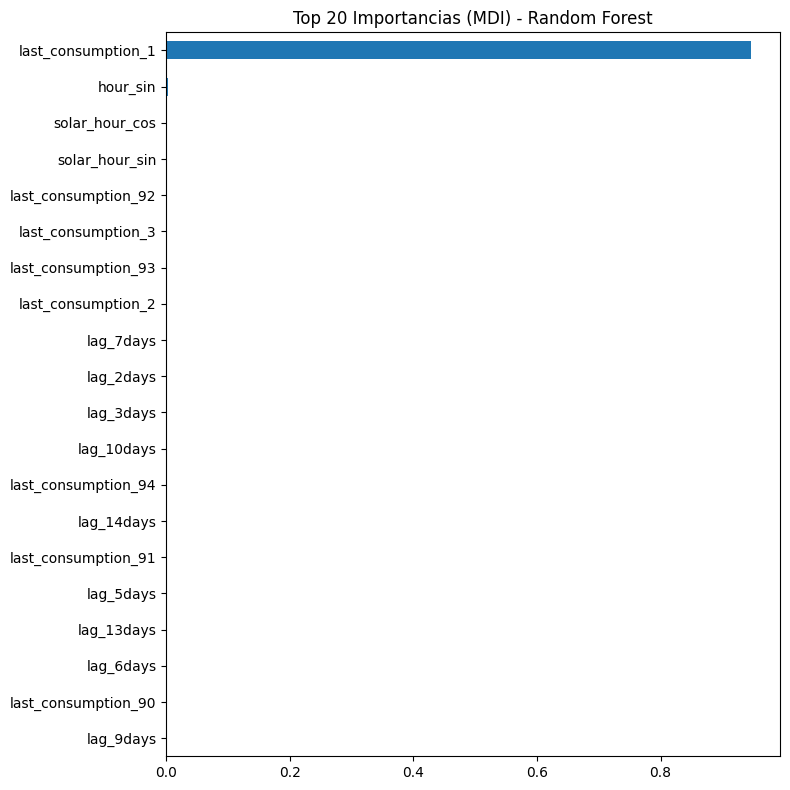

feature_rf = ['last_consumption_1', 'hour_sin', 'solar_hour_cos', 'solar_hour_sin', 'last_consumption_92', 'last_consumption_3', 'last_consumption_93', 'last_consumption_2', 'lag_7days', 'lag_2days', 'lag_3days', 'lag_10days', 'last_consumption_94', 'lag_14days', 'last_consumption_91', 'lag_5days', 'lag_13days', 'lag_6days', 'last_consumption_90', 'lag_9days', 'lag_8days', 'lag_4days', 'last_consumption_89', 'lag_12days', 'lag_11days', 'last_consumption_4', 'hour_cos', 'Avg_Wind_Direction', 'Inst_Temp', 'last_consumption_84', 'Total_Global_Rad', 'last_consumption_95', 'last_consumption_88', 'Avg_Rel_Humidity', 'last_consumption_5', 'last_consumption_86', 'last_consumption_22', 'last_consumption_6', 'Avg_Temp', 'last_consumption_87', 'Max_Inst_Wind_Speed', 'last_consumption_85', 'last_consumption_8', 'last_consumption_7', 'last_consumption_21', 'last_consumption_44', 'Avg_Wind_Speed', 'last_consumption_23', 'last_consumption_41', 'last_consumption_9', 'last_consumption_37', 'last_consum

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error

RANDOM_STATE = 42

# ----------------
# 1) Separar X, y
# ----------------
y = df_model_data['total_consumption']
X = df_model_data.drop(columns=['total_consumption'])

feature_names = X.columns.tolist()
print(f"Features ({len(feature_names)}): {feature_names}")

# -----------------------------
# 2) Train/Test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# ------------------------------------
# 3) Pipeline: imputación + RandomForest
# ------------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", rf)
])

print("\nEntrenando el Random forest (RF)")
%time pipe.fit(X_train, y_train)

# Evaluación base
pred = pipe.predict(X_test)
print(f"\n=== Rendimiento base RF con {len(X.columns.tolist())} características===")
print("R2  :", r2_score(y_test, pred))
print("MAE :", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))


# -------------------------------------------------------
# 4) Importancia por impureza (MDI)
# -------------------------------------------------------
mdi_importances = pipe.named_steps["rf"].feature_importances_
mdi_series = pd.Series(mdi_importances, index=feature_names).sort_values(ascending=False)

top_n = min(20, len(mdi_series))
print(f"\n=== Top {top_n} features por impureza (MDI) ===")
print(mdi_series.head(top_n))

plt.figure(figsize=(8, 0.35*top_n + 1))
mdi_series.head(top_n).iloc[::-1].plot(kind="barh")
plt.title(f"Top {top_n} Importancias (MDI) - Random Forest")
plt.tight_layout()
plt.show()
print("feature_rf =", mdi_series.index.tolist())

### Feature selection using Permutation Importance (MDA)


=== Top 20 features por permutación (MDA) ===
last_consumption_1     1.508640
lag_10days             0.002752
solar_hour_sin         0.001967
hour_sin               0.001720
solar_hour_cos         0.001146
                         ...   
lag_2days              0.000231
lag_14days             0.000224
last_consumption_19    0.000216
last_consumption_23    0.000197
last_consumption_14    0.000196
Length: 20, dtype: float64


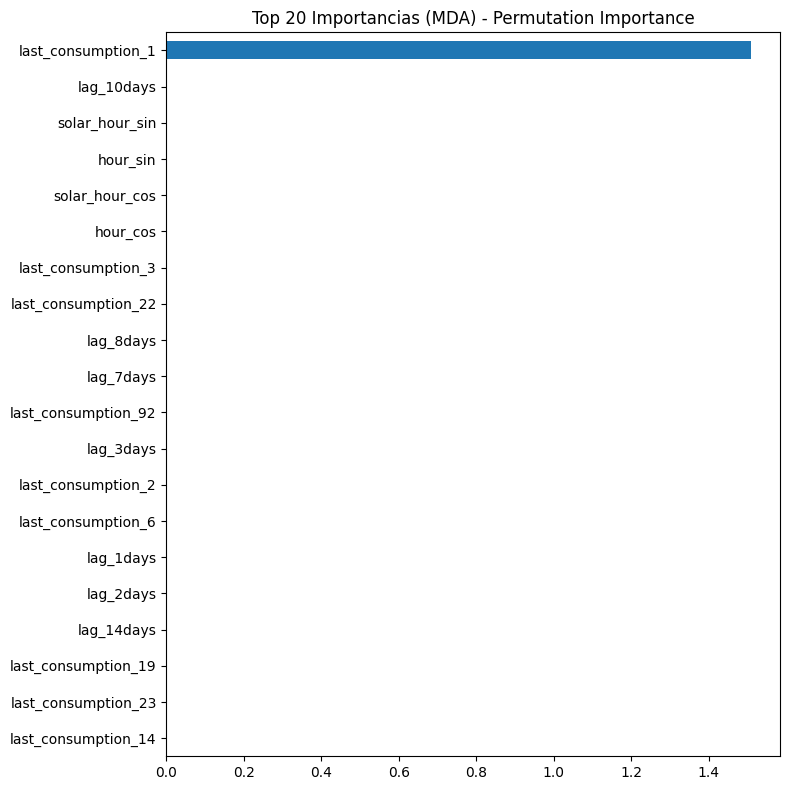


=== Selección de características con SelectFromModel (umbral = median) ===
Seleccionadas: 64 de 128
['solar_hour_sin', 'solar_hour_cos', 'hour_sin', 'hour_cos', 'last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'last_consumption_7', 'last_consumption_8', 'last_consumption_9', 'last_consumption_10', 'last_consumption_14', 'last_consumption_19', 'last_consumption_20', 'last_consumption_21', 'last_consumption_22', 'last_consumption_23', 'last_consumption_25', 'last_consumption_37', 'last_consumption_38', 'last_consumption_39', 'last_consumption_40', 'last_consumption_41', 'last_consumption_42', 'last_consumption_43', 'last_consumption_44', 'last_consumption_45', 'last_consumption_81', 'last_consumption_82', 'last_consumption_84', 'last_consumption_85', 'last_consumption_86', 'last_consumption_87', 'last_consumption_88', 'last_consumption_89', 'last_consumption_90', 'last_consumption_91', 'last_consumption_9

In [ ]:
import sys
from contextlib import redirect_stderr

# -------------------------------------------------------
# 5) Importancia por permutación (MDA)
#    (sobre el pipeline completo para ser justos)
# -------------------------------------------------------
os.environ["JOBLIB_TEMP_FOLDER"] = "/content" # A veces /dev/shm o /tmp se quedan cortos. En Colab, /content suele tener más espacio.

with open(os.devnull, "w") as devnull, redirect_stderr(devnull):
    perm = permutation_importance(
        pipe, X_test, y_test,
        n_repeats=10, random_state=RANDOM_STATE, n_jobs=1
    )

mda_series = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

print(f"\n=== Top {top_n} features por permutación (MDA) ===")
print(mda_series.head(top_n))

plt.figure(figsize=(8, 0.35*top_n + 1))
mda_series.head(top_n).iloc[::-1].plot(kind="barh")
plt.title(f"Top {top_n} Importancias (MDA) - Permutation Importance")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 6) Selección de características con umbral (median)
#    Como la imputación no cambia el nº de columnas ni el orden,
#    los nombres se mantienen 1:1.
# -------------------------------------------------------
selector = SelectFromModel(pipe.named_steps["rf"], threshold="median", prefit=True)
mask_selected = selector.get_support()
selected_feature_names = [f for f, keep in zip(feature_names, mask_selected) if keep]

print("\n=== Selección de características con SelectFromModel (umbral = median) ===")
print(f"Seleccionadas: {len(selected_feature_names)} de {len(feature_names)}")
print(selected_feature_names[:50], "..." if len(selected_feature_names) > 50 else "")

# Transformar los sets con la misma imputación del pipeline
X_train_imp = pipe.named_steps["imputer"].transform(X_train)
X_test_imp  = pipe.named_steps["imputer"].transform(X_test)

X_train_reduced = selector.transform(X_train_imp)
X_test_reduced  = selector.transform(X_test_imp)

print("\nFormas:")
print("X_train_imp     :", X_train_imp.shape)
print("X_train_reduced :", X_train_reduced.shape)
print("X_test_imp      :", X_test_imp.shape)
print("X_test_reduced  :", X_test_reduced.shape)

In [ ]:
mda_df = pd.DataFrame({
    "mean": perm.importances_mean,
    "std": perm.importances_std
}, index=feature_names).sort_values("mean", ascending=False)

# criterio: media - 2*desviación > 0
selected = mda_df[mda_df["mean"] - 2*mda_df["std"] > 0]

print("\n=== Features seleccionadas por MDA (significativas) ===")
print(selected.index.tolist())


=== Features seleccionadas por MDA (significativas) ===
['last_consumption_1', 'lag_10days', 'solar_hour_sin', 'hour_sin', 'solar_hour_cos', 'hour_cos', 'last_consumption_3', 'last_consumption_22', 'lag_8days', 'lag_7days', 'last_consumption_92', 'lag_3days', 'last_consumption_2', 'last_consumption_6', 'lag_1days', 'lag_2days', 'lag_14days', 'last_consumption_19', 'last_consumption_23', 'last_consumption_14', 'last_consumption_8', 'last_consumption_96', 'last_consumption_44', 'lag_6days', 'lag_13days', 'last_consumption_84', 'lag_5days', 'last_consumption_94', 'last_consumption_10', 'Total_Global_Rad', 'last_consumption_43', 'last_consumption_47', 'last_consumption_7', 'lag_4days', 'last_consumption_5', 'lag_9days', 'last_consumption_45', 'last_consumption_4', 'last_consumption_38', 'lag_12days', 'next_daylight_fraction', 'last_consumption_41', 'last_consumption_87', 'last_consumption_46', 'lag_11days', 'last_consumption_9', 'daylight_fraction', 'last_consumption_20', 'last_consumptio

### FINAL FEATURE SELECTION
Tras evaluar las features con 6 métodos de selección:  
Corr (|r|≥0.25), MI, Lasso, RF (importancias), RF_median (RF con umbral en la mediana) y MDA (permutation importance).

Se forman 3 tiers (niveles) según los siguientes criterios:  

Tier 1 (obligatoria): la feature aparece en MDA y además en al menos uno de {RF, Lasso, RF_median}.  
  - Señal fuerte: contribución confirmada por MDA y por un selector basado en modelo.

Tier 2 (candidata): la feature sale en ≥ 2 métodos (cualquier combinación), pero no cumple la regla de Tier 1.  
  - Señal consistente, pero menos contundente.

Tier 3 (descartable): la feature aparece en 0–1 métodos.  
  - Evidencia insuficiente.

Luego se ordena por tier y por cuántos métodos la seleccionaron, y se listan también las que no empiezan por last_consumption_ para destacar exógenas.

In [ ]:
### Conjunción de las selecciones por corr, Mi, Lasso, rf y permutation importance

# Lineal correlation with method .corr()
features_linear_corr_greater_than_025 = ['last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'last_consumption_96', 'lag_1days', 'lag_2days', 'last_consumption_7', 'last_consumption_95', 'lag_7days', 'lag_14days', 'lag_5days', 'lag_3days', 'last_consumption_94', 'lag_8days', 'lag_6days', 'lag_13days', 'lag_9days', 'lag_11days', 'lag_10days', 'last_consumption_93', 'lag_4days', 'lag_12days', 'last_consumption_8', 'last_consumption_92', 'last_consumption_91', 'last_consumption_9', 'last_consumption_90', 'last_consumption_10', 'last_consumption_89', 'last_consumption_11', 'last_consumption_88', 'last_consumption_87', 'last_consumption_12', 'last_consumption_86', 'last_consumption_13', 'last_consumption_85', 'last_consumption_14', 'last_consumption_84', 'last_consumption_15', 'last_consumption_83', 'last_consumption_16', 'last_consumption_82', 'last_consumption_17', 'last_consumption_81', 'last_consumption_18', 'last_consumption_47', 'last_consumption_48', 'last_consumption_46', 'last_consumption_49', 'last_consumption_45', 'last_consumption_50', 'last_consumption_44', 'last_consumption_80', 'last_consumption_51', 'last_consumption_19', 'last_consumption_43', 'last_consumption_52', 'last_consumption_42', 'last_consumption_53', 'last_consumption_41', 'last_consumption_20', 'last_consumption_79', 'last_consumption_54', 'last_consumption_40', 'last_consumption_55', 'Avg_Temp', 'Inst_Temp', 'solar_hour_cos', 'hour_sin']
# Mutual information
features_mi = ['last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'last_consumption_7', 'last_consumption_96', 'lag_1days', 'last_consumption_8', 'last_consumption_95', 'lag_2days', 'lag_14days', 'lag_7days', 'lag_3days', 'lag_5days', 'last_consumption_94', 'lag_6days', 'lag_8days', 'lag_4days', 'lag_13days', 'lag_9days', 'last_consumption_9', 'lag_10days', 'lag_11days', 'last_consumption_93', 'lag_12days', 'last_consumption_92', 'last_consumption_10', 'last_consumption_91', 'last_consumption_11', 'last_consumption_90', 'last_consumption_12', 'last_consumption_89', 'last_consumption_13', 'last_consumption_88', 'last_consumption_14', 'last_consumption_87', 'last_consumption_15', 'last_consumption_86', 'last_consumption_16', 'last_consumption_33', 'last_consumption_29', 'last_consumption_31', 'last_consumption_32', 'last_consumption_30', 'last_consumption_34', 'last_consumption_17', 'last_consumption_27', 'last_consumption_85', 'last_consumption_18', 'last_consumption_28', 'Inst_Temp', 'last_consumption_26', 'last_consumption_36', 'last_consumption_84', 'last_consumption_35', 'last_consumption_25', 'last_consumption_19', 'last_consumption_23', 'solar_hour_cos', 'last_consumption_40', 'last_consumption_20', 'last_consumption_21', 'hour_sin', 'last_consumption_38', 'last_consumption_44', 'last_consumption_37', 'last_consumption_24', 'last_consumption_52', 'last_consumption_42', 'last_consumption_41']
# Lasso selection
features_lasso = ['last_consumption_1', 'hour_cos', 'daylight_fraction', 'solar_hour_sin', 'last_consumption_3', 'Total_Global_Rad', 'last_consumption_93', 'Inst_Temp', 'lag_14days', 'lag_2days', 'lag_7days', 'last_consumption_41', 'last_consumption_25', 'last_consumption_21', 'lag_5days', 'lag_13days', 'last_consumption_72', 'lag_6days', 'last_consumption_9', 'lag_3days', 'last_consumption_78', 'last_consumption_70', 'last_consumption_92', 'lag_9days', 'solar_hour_cos', 'last_consumption_54', 'lag_10days', 'lag_11days', 'last_consumption_88', 'last_consumption_29', 'last_consumption_90', 'last_consumption_23', 'last_consumption_87', 'last_consumption_76', 'last_consumption_94', 'last_consumption_28', 'last_consumption_56', 'last_consumption_10', 'last_consumption_26', 'dow_sin', 'lag_8days', 'last_consumption_96', 'Max_Inst_Wind_Speed', 'last_consumption_64', 'working_day', 'dow_cos', 'last_consumption_22', 'last_consumption_27', 'last_consumption_43', 'last_consumption_13', 'last_consumption_40', 'Quantity_Precip', 'lag_12days', 'lag_1days']
# RF
feature_rf = ['last_consumption_1', 'solar_hour_cos', 'hour_sin', 'solar_hour_sin', 'last_consumption_92', 'lag_7days', 'last_consumption_2', 'last_consumption_3', 'last_consumption_91', 'last_consumption_93', 'last_consumption_94', 'last_consumption_90', 'last_consumption_95', 'Avg_Wind_Direction', 'last_consumption_89', 'last_consumption_4', 'Inst_Temp', 'Avg_Rel_Humidity', 'last_consumption_84', 'last_consumption_5', 'last_consumption_88', 'Total_Global_Rad', 'last_consumption_86', 'Avg_Temp', 'last_consumption_23', 'hour_cos', 'last_consumption_6', 'last_consumption_21', 'Max_Inst_Wind_Speed', 'last_consumption_87', 'last_consumption_22', 'last_consumption_7', 'last_consumption_44', 'last_consumption_20', 'last_consumption_43', 'Avg_Wind_Speed', 'last_consumption_8', 'last_consumption_37', 'last_consumption_9', 'last_consumption_45', 'last_consumption_41', 'last_consumption_85', 'last_consumption_10', 'last_consumption_38', 'last_consumption_82', 'last_consumption_96', 'last_consumption_25', 'last_consumption_39', 'last_consumption_29', 'last_consumption_24', 'last_consumption_19', 'lag_1days', 'last_consumption_47', 'last_consumption_11', 'last_consumption_40', 'last_consumption_12', 'last_consumption_42', 'last_consumption_26', 'last_consumption_83', 'last_consumption_46', 'last_consumption_13', 'last_consumption_27', 'last_consumption_34', 'last_consumption_14', 'last_consumption_28', 'last_consumption_16', 'last_consumption_30', 'last_consumption_81', 'last_consumption_35', 'last_consumption_36', 'last_consumption_33', 'last_consumption_31', 'last_consumption_57', 'last_consumption_32', 'last_consumption_15', 'last_consumption_49', 'last_consumption_60', 'last_consumption_18', 'last_consumption_48', 'last_consumption_17', 'last_consumption_62', 'last_consumption_52', 'last_consumption_50', 'last_consumption_56', 'last_consumption_80', 'last_consumption_51', 'last_consumption_64', 'last_consumption_61', 'last_consumption_53', 'last_consumption_54', 'last_consumption_77', 'last_consumption_79', 'last_consumption_63', 'next_daylight_fraction', 'last_consumption_78', 'last_consumption_59', 'last_consumption_55', 'last_consumption_68', 'last_consumption_66', 'last_consumption_58', 'last_consumption_65', 'last_consumption_76', 'last_consumption_74', 'last_consumption_72', 'last_consumption_75', 'dow_sin', 'last_consumption_73', 'last_consumption_70', 'last_consumption_67', 'last_consumption_71', 'last_consumption_69', 'daylight_fraction', 'dow_cos', 'working_day', 'Quantity_Precip', 'Max_Inst_Precip']
# RF with threshold 'median'
feature_rf_selected_not_sorted = ['solar_hour_sin', 'solar_hour_cos', 'hour_sin', 'hour_cos', 'last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'last_consumption_7', 'last_consumption_8', 'last_consumption_9', 'last_consumption_10', 'last_consumption_11', 'last_consumption_12', 'last_consumption_19', 'last_consumption_20', 'last_consumption_21', 'last_consumption_22', 'last_consumption_23', 'last_consumption_24', 'last_consumption_25', 'last_consumption_26', 'last_consumption_29', 'last_consumption_37', 'last_consumption_38', 'last_consumption_39', 'last_consumption_40', 'last_consumption_41', 'last_consumption_42', 'last_consumption_43', 'last_consumption_44', 'last_consumption_45', 'last_consumption_47', 'last_consumption_82', 'last_consumption_84', 'last_consumption_85', 'last_consumption_86', 'last_consumption_87', 'last_consumption_88', 'last_consumption_89', 'last_consumption_90', 'last_consumption_91', 'last_consumption_92', 'last_consumption_93', 'last_consumption_94', 'last_consumption_95', 'last_consumption_96', 'lag_1days', 'lag_7days', 'Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Avg_Wind_Speed', 'Max_Inst_Wind_Speed', 'Inst_Temp', 'Total_Global_Rad']
# Permutation importance (MDA)
features_permutation_importance = ['last_consumption_1', 'solar_hour_sin', 'solar_hour_cos', 'hour_sin', 'last_consumption_2', 'hour_cos', 'lag_7days', 'last_consumption_23', 'last_consumption_3', 'last_consumption_96', 'lag_1days', 'last_consumption_5', 'last_consumption_84', 'last_consumption_92', 'last_consumption_22', 'last_consumption_93', 'last_consumption_94', 'last_consumption_91', 'last_consumption_90', 'last_consumption_7', 'Total_Global_Rad', 'last_consumption_44', 'last_consumption_64', 'last_consumption_86', 'last_consumption_38', 'last_consumption_37', 'last_consumption_43', 'last_consumption_88', 'Inst_Temp', 'next_daylight_fraction', 'last_consumption_6', 'last_consumption_89', 'last_consumption_11', 'last_consumption_34', 'last_consumption_69', 'last_consumption_39', 'last_consumption_14', 'last_consumption_8', 'last_consumption_19', 'last_consumption_28', 'last_consumption_20', 'last_consumption_46', 'last_consumption_29', 'last_consumption_83', 'dow_sin', 'daylight_fraction', 'last_consumption_40', 'last_consumption_80', 'last_consumption_50']

# Diccionario con todos los métodos
methods = {
    "Corr": set(features_linear_corr_greater_than_025),
    "MI": set(features_mi),
    "Lasso": set(features_lasso),
    "RF": set(feature_rf),
    "RF_median": set(feature_rf_selected_not_sorted),
    "MDA": set(features_permutation_importance),
}

# Aplanar todas las features
all_features = set().union(*methods.values())

# Crear dataframe con info de cada feature
data = []
for feat in all_features:
    present_in = [m for m, feats in methods.items() if feat in feats]
    count = len(present_in)

    # Clasificación en Tiers
    if "MDA" in present_in and (("RF" in present_in) or ("Lasso" in present_in) or ("RF_median" in present_in)):
        tier = "Tier 1 (obligatoria)"
    elif count >= 2:
        tier = "Tier 2 (candidata)"
    else:
        tier = "Tier 3 (descartable)"

    data.append({
        "feature": feat,
        "count_methods": count,
        "methods": ", ".join(present_in),
        "tier": tier
    })

df = pd.DataFrame(data)

# Ordenar para ver primero las más fuertes
df = df.sort_values(by=["tier", "count_methods"], ascending=[True, False]).reset_index(drop=True)
display(df.head(10))

df_tier1 = df[df["tier"] == "Tier 1 (obligatoria)"].reset_index(drop=True)
df_tier2 = df[df["tier"] == "Tier 2 (candidata)"].reset_index(drop=True)
df_tier3 = df[df["tier"] == "Tier 3 (descartable)"].reset_index(drop=True)

print("Número de features en cada Tier:")
print(f"\nTier 1 (obligatoria) {len(df_tier1)} = {df_tier1['feature'].to_list()}")
features_not_last_consumption = [feat_name for feat_name in df_tier1['feature'] if not str(feat_name).startswith('last_consumption')]
print(f"Tier 1 != last_consumption_N {len(features_not_last_consumption)} = {features_not_last_consumption}")

print(f"\nTier 2 (candidata) {len(df_tier2)} = {df_tier2['feature'].to_list()}")
features_not_last_consumption = [feat_name for feat_name in df_tier2['feature'] if not str(feat_name).startswith('last_consumption')]
print(f"Tier 2 != last_consumption_N {len(features_not_last_consumption)} = {features_not_last_consumption}")

print(f"\nTier 3 (descartable) {len(df_tier3)} = {df_tier3['feature'].to_list()}")
features_not_last_consumption = [feat_name for feat_name in df_tier3['feature'] if not str(feat_name).startswith('last_consumption')]
print(f"Tier 3 != last_consumption_N {len(features_not_last_consumption)} = {features_not_last_consumption}")


feature  count_methods                              methods  \
0  last_consumption_92              6  Corr, MI, Lasso, RF, RF_median, MDA   
1  last_consumption_94              6  Corr, MI, Lasso, RF, RF_median, MDA   
2            Inst_Temp              6  Corr, MI, Lasso, RF, RF_median, MDA   
3            lag_1days              6  Corr, MI, Lasso, RF, RF_median, MDA   
4   last_consumption_1              6  Corr, MI, Lasso, RF, RF_median, MDA   
5  last_consumption_93              6  Corr, MI, Lasso, RF, RF_median, MDA   
6            lag_7days              6  Corr, MI, Lasso, RF, RF_median, MDA   
7   last_consumption_3              6  Corr, MI, Lasso, RF, RF_median, MDA   
8       solar_hour_cos              6  Corr, MI, Lasso, RF, RF_median, MDA   
9  last_consumption_40              6  Corr, MI, Lasso, RF, RF_median, MDA   

                   tier  
0  Tier 1 (obligatoria)  
1  Tier 1 (obligatoria)  
2  Tier 1 (obligatoria)  
3  Tier 1 (obligatoria)  
4  Tier 1 (obligatoria)  
5  Tier 1 (obligatoria)  
6  Tier 1 (obligatoria)  
7  Tier 1 (obligatoria)  
8  Tier 1 (obligatoria)  
9  Tier 1 (obligatoria)

Número de features en cada Tier:

Tier 1 (obligatoria) 49 = ['last_consumption_92', 'last_consumption_94', 'Inst_Temp', 'lag_1days', 'last_consumption_1', 'last_consumption_93', 'lag_7days', 'last_consumption_3', 'solar_hour_cos', 'last_consumption_40', 'last_consumption_90', 'last_consumption_88', 'last_consumption_96', 'hour_sin', 'last_consumption_19', 'last_consumption_44', 'last_consumption_89', 'last_consumption_11', 'last_consumption_23', 'last_consumption_7', 'last_consumption_5', 'last_consumption_8', 'last_consumption_6', 'last_consumption_86', 'last_consumption_91', 'last_consumption_84', 'last_consumption_2', 'last_consumption_20', 'last_consumption_43', 'last_consumption_29', 'last_consumption_37', 'hour_cos', 'solar_hour_sin', 'last_consumption_14', 'last_consumption_28', 'last_consumption_38', 'last_consumption_22', 'Total_Global_Rad', 'last_consumption_80', 'last_consumption_64', 'last_consumption_50', 'daylight_fraction', 'last_consumption_39', 'last_consumption_34', '

# Models training and validation

## ARIMA

### SAMIRAX (1,0,0,96) trained over last 14 days R² 0.9196

In [ ]:
# !pip install -q statsmodels

import numpy as np
import pandas as pd
import gc
from statsmodels.tsa.statespace.sarimax import SARIMAX

%%time

def sarimax_daily_rolling_ultralight(
    y: pd.Series,
    test_len: int = 96,          # 1 día de test por defecto
    train_days: int = 14,        # 14 días de entrenamiento por defecto
):
    """
    SARIMAX(1,0,0)x(1,0,0,96) SIN exógenas, rolling 1-paso.
    - Entrena solo con los últimos `train_days` días antes de cada predicción.
    - Usa simple_differencing=True para reducir memoria.
    - Trabaja en float32.
    No modifica 'y'.
    Devuelve y_test, y_pred (ambas Series alineadas).
    """
    assert len(y) > (96*train_days + test_len), "Serie demasiado corta para esos parámetros."

    # Asegurar dtype ligero y evitar copiar de más
    y_clean = pd.to_numeric(y, errors="coerce").astype("float32")
    y_clean = y_clean.asfreq("15min")
    y_clean = y_clean.dropna()

    # Definir splits
    y_test = y_clean.iloc[-test_len:].copy()
    pred_index = y_test.index
    preds = []

    # Rolling 1-step: para cada t en test, rehacer modelo SOLO con los últimos 'train_days' días
    for i in range(test_len):
        end_train = len(y_clean) - test_len + i
        start_train = end_train - 96*train_days
        y_train = y_clean.iloc[start_train:end_train]

        # Modelo muy contenido
        model = SARIMAX(
            y_train,
            order=(1, 0, 0),
            seasonal_order=(1, 0, 0, 96),
            simple_differencing=True,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        %time res = model.fit(disp=False, maxiter=50)

        # 1-step ahead forecast
        fc1 = res.get_forecast(steps=1).predicted_mean.iloc[0]
        preds.append(fc1)

        # Liberar memoria intermedia agresivamente
        del model, res, y_train
        gc.collect()

    y_pred = pd.Series(preds, index=pred_index, name="forecast")
    return y_test, y_pred

# --- Ejecución (no modifica df_consumptions_15m) ---
y_series = df_consumptions_15m['total_consumption'].copy()

# Puedes ajustar 'train_days' o 'test_len' si aún te da problemas (p.ej., 7 días de train y 48 pasos de test).
y_real, y_pred = sarimax_daily_rolling_ultralight(
    y_series,
    test_len=96,       # 1 día
    train_days=14      # 14 días de historial
)

print_metrics(y_real, y_pred, "SARIMAX(1,0,0)x(1,0,0,96) [ultra-light rolling]")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  

NameError: name 'print_metrics' is not defined

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.7 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

y = df_consumptions_15m["total_consumption"]

# Eliges manualmente (p,d,q), por ejemplo (3,1,2)
model = ARIMA(y, order=(3,1,2))
results = model.fit()

print(results.summary())
forecast = results.forecast(steps=96)  # predicción de 1 día (96 intervalos de 15m)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters 

                               SARIMAX Results                                
Dep. Variable:      total_consumption   No. Observations:                37584
Model:                 ARIMA(3, 1, 2)   Log Likelihood              -54640.237
Date:                Thu, 04 Sep 2025   AIC                         109292.473
Time:                        17:21:15   BIC                         109343.679
Sample:                    05-05-2022   HQIC                        109308.729
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7990      0.013    137.139      0.000       1.773       1.825
ar.L2         -0.8644      0.014    -62.693      0.000      -0.891      -0.837
ar.L3         -0.0038      0.005     -0.745      0.4

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA

y = df_consumptions_15m["total_consumption"]

y_train = y.iloc[:36999]
y_test  = y.iloc[36999:37000]

model = ARIMA(y_train, order=(1,1,1))
res = model.fit()

forecast = res.forecast(steps=1) # niveles
# Alinear índices (opcional pero útil)
forecast.index = y_test.index

# Métricas
print_metrics(y_test, forecast, "ARIMA")


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters 

MAE: 0.287 | RMSE: 0.287
MAPE: 1.44%
R²: nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


## Random Forest

### With selected features Tier1_R²=0.9568 - Tier1+2_R²=0.9567 - Tier2_R² 0.9185

Entrenando RF con **Tier1 features (49)**  
CPU times: user 17min 55s, sys: 2.39 s, **total: 17min 58s** Wall time: 10min 35s  
Métricas aplicando el modelo Random Forest with selected features:  
  MSE:  0.8472  
  **RMSE: 0.9204**  
  MAPE: 9150130.69%  
  **R²:   0.9568**  

Entrenando RF con **Tier1 + Tier2 features (111)**  
CPU times: user 40min 35s, sys: 4.68 s, **total: 40min 40s** Wall time: 26min 16s  
Métricas aplicando el modelo Random Forest with selected features:  
  MSE:  0.8487  
  **RMSE: 0.9213**  
  MAPE: 9265304.43%  
  **R²:   0.9567**

Entrenando RF con **Tier 2 features (62)**  
CPU times: user 22min 37s, sys: 2.72 s, **total: 22min 40s** Wall time: 13min 32s  
Métricas aplicando el modelo Random Forest with selected features:
  MSE:  1.5984  
  **RMSE: 1.2643**  
  MAPE: 18832861.99%  
  **R²:   0.9185**

In [ ]:
def rf_with_selected_features(rf_model_data: pd.DataFrame, feature_names: list[str], target_name: str) -> RandomForestRegressor:
    """
    Entrena un RandomForestRegressor usando las columnas indicadas en `feature_names`
    como X y `target_name` como y. Devuelve el modelo entrenado.
    """

    y = df_model_data[target_name]
    X = df_model_data[feature_names].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE
    )

    print(f"\nEntrenando RF con {len(feature_names)} features {feature_names}")
    rf_model = RandomForestRegressor(
        n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE
    )

    %time rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    print_metrics(y_test, y_pred, "Random Forest with selected features")

    return rf_model


rf_tier1_model = rf_with_selected_features(
    df_model_data,
    df_tier1['feature'].tolist(),
    'total_consumption'
)

rf_tier12_model = rf_with_selected_features(
    df_model_data,
    df_tier1['feature'].tolist() + df_tier2['feature'].tolist(),
    'total_consumption'
)

Features (49): ['last_consumption_96', 'last_consumption_94', 'last_consumption_90', 'last_consumption_3', 'last_consumption_1', 'last_consumption_88', 'solar_hour_cos', 'lag_1days', 'Inst_Temp', 'lag_7days', 'last_consumption_92', 'last_consumption_40', 'last_consumption_93', 'last_consumption_23', 'last_consumption_44', 'last_consumption_43', 'last_consumption_19', 'hour_sin', 'last_consumption_6', 'last_consumption_8', 'last_consumption_11', 'last_consumption_86', 'last_consumption_84', 'last_consumption_89', 'last_consumption_29', 'last_consumption_91', 'last_consumption_2', 'last_consumption_5', 'last_consumption_20', 'last_consumption_7', 'last_consumption_37', 'last_consumption_38', 'last_consumption_22', 'solar_hour_sin', 'last_consumption_14', 'hour_cos', 'last_consumption_28', 'Total_Global_Rad', 'dow_sin', 'last_consumption_46', 'last_consumption_83', 'last_consumption_64', 'last_consumption_39', 'daylight_fraction', 'last_consumption_34', 'last_consumption_80', 'last_consum

In [ ]:
rf_tier2_model = rf_with_selected_features(
    df_model_data,
    df_tier2['feature'].tolist(),
    'total_consumption'
)

Features (62): ['last_consumption_10', 'last_consumption_9', 'last_consumption_41', 'last_consumption_87', 'last_consumption_13', 'last_consumption_42', 'last_consumption_95', 'last_consumption_26', 'last_consumption_21', 'last_consumption_4', 'last_consumption_12', 'last_consumption_25', 'last_consumption_85', 'Avg_Temp', 'lag_5days', 'last_consumption_52', 'last_consumption_47', 'last_consumption_15', 'last_consumption_27', 'lag_14days', 'lag_11days', 'lag_3days', 'last_consumption_16', 'lag_13days', 'lag_10days', 'lag_12days', 'lag_9days', 'last_consumption_24', 'last_consumption_82', 'last_consumption_18', 'last_consumption_45', 'last_consumption_17', 'Max_Inst_Wind_Speed', 'lag_6days', 'last_consumption_54', 'lag_8days', 'lag_2days', 'Avg_Rel_Humidity', 'last_consumption_53', 'last_consumption_49', 'last_consumption_33', 'Avg_Wind_Speed', 'lag_4days', 'last_consumption_51', 'Avg_Wind_Direction', 'dow_cos', 'last_consumption_48', 'last_consumption_35', 'working_day', 'last_consumpt

In [ ]:
import joblib
joblib.dump(rf_tier1_model, "/content/drive/MyDrive/Global Project Notebooks/random_forest_tier1_49features.pkl")
joblib.dump(rf_tier12_model, "/content/drive/MyDrive/Global Project Notebooks/random_forest_tier12_111features.pkl")
joblib.dump(rf_tier2_model, "/content/drive/MyDrive/Global Project Notebooks/random_forest_tier2_62features.pkl")


['/content/drive/MyDrive/Global Project Notebooks/random_forest_tier2_62features.pkl']

### RF deltas to delta

In [ ]:
from sklearn.ensemble import RandomForestRegressor

def rf_full_delta_abs(X_train, y_train, X_test, y_test):
    """
      y_test: pd.Series con deltas
    """
    RANDOM_STATE = 42

    rf_model = RandomForestRegressor(
        n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE
    )
    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    print_metrics(y_test, y_pred, "RF FULL_DELTA_ABS (métricas en DELTA)")

    y_pred_totals =  y_pred + df_model_data['last_consumption_1'].loc[X_test.index]

    print_metrics(y_test, y_pred_totals, "NN FULL_DELTA_ABS (métricas en TOTALES)")

# rf_full_delta_abs(X_full_delta_abs_train, y_full_delta_abs_train, X_full_delta_abs_test, y_full_delta_abs_test)



Métricas aplicando el modelo RF FULL_DELTA_ABS (métricas en DELTA):
RMSE: 0.9624
MAPE: 1983097.79%
R²:   0.1493

Métricas aplicando el modelo NN FULL_DELTA_ABS (métricas en TOTALES):
RMSE: 13.5928
MAPE: 40426615.26%
R²:   -168.7023


### With several window sizes

Variables relacionadas con total_consumption con coef.corr >= 0.05:
 ['last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'lag_1day', 'last_consumption_96', 'last_consumption_7', 'last_consumption_95', 'lag_7days', 'last_consumption_94', 'last_consumption_93', 'last_consumption_8', 'last_consumption_92', 'last_consumption_91', 'last_consumption_9', 'last_consumption_90', 'last_consumption_10', 'last_consumption_89', 'last_consumption_11', 'last_consumption_88', 'last_consumption_87', 'last_consumption_12', 'last_consumption_86', 'last_consumption_13', 'last_consumption_85', 'last_consumption_14', 'last_consumption_84', 'last_consumption_15', 'last_consumption_83', 'last_consumption_16', 'last_consumption_82', 'last_consumption_17', 'last_consumption_81', 'last_consumption_18', 'last_consumption_47', 'last_consumption_48', 'last_consumption_46', 'last_consumption_49', 'last_consumption_45', 'last_consumption

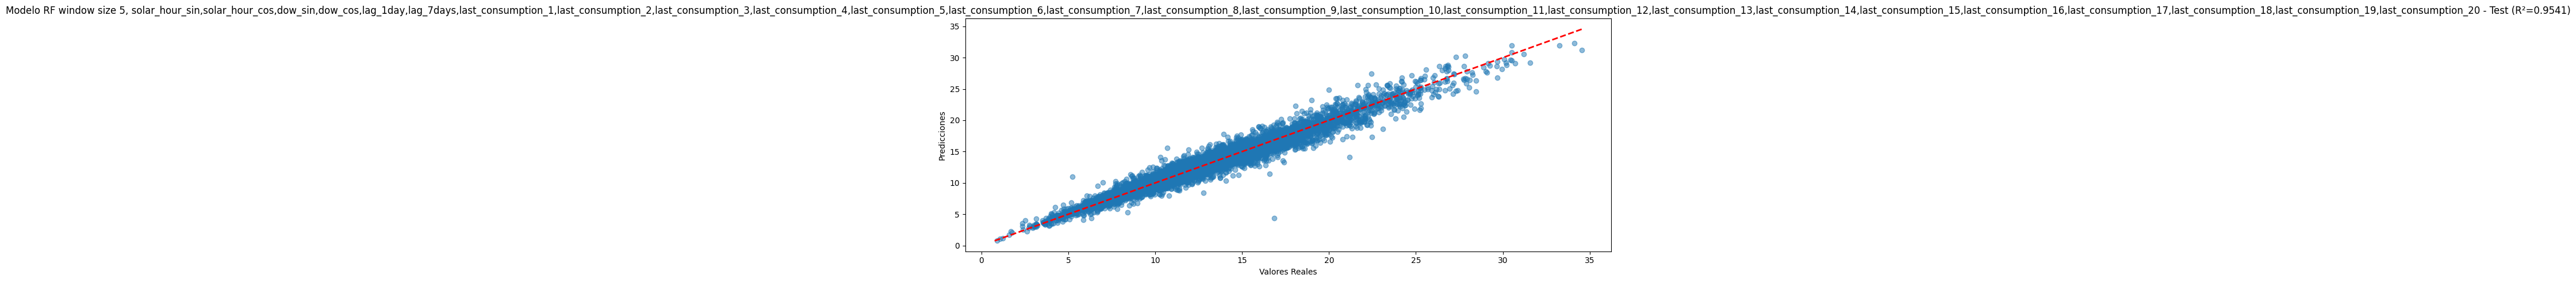

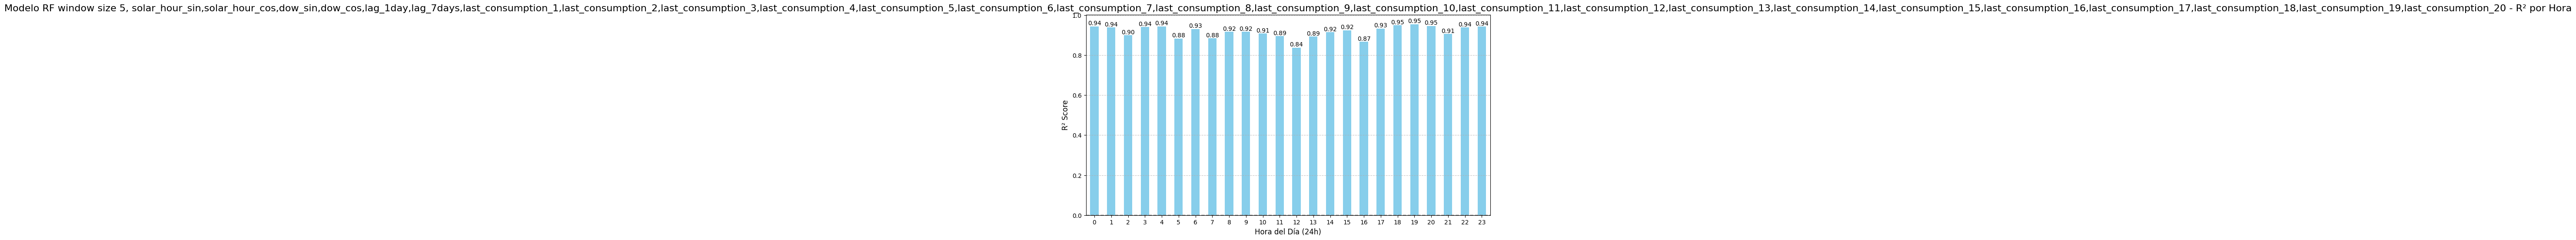

/tmp/ipython-input-789298624.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r2_by_day = df_temp.groupby('day_of_week').apply(


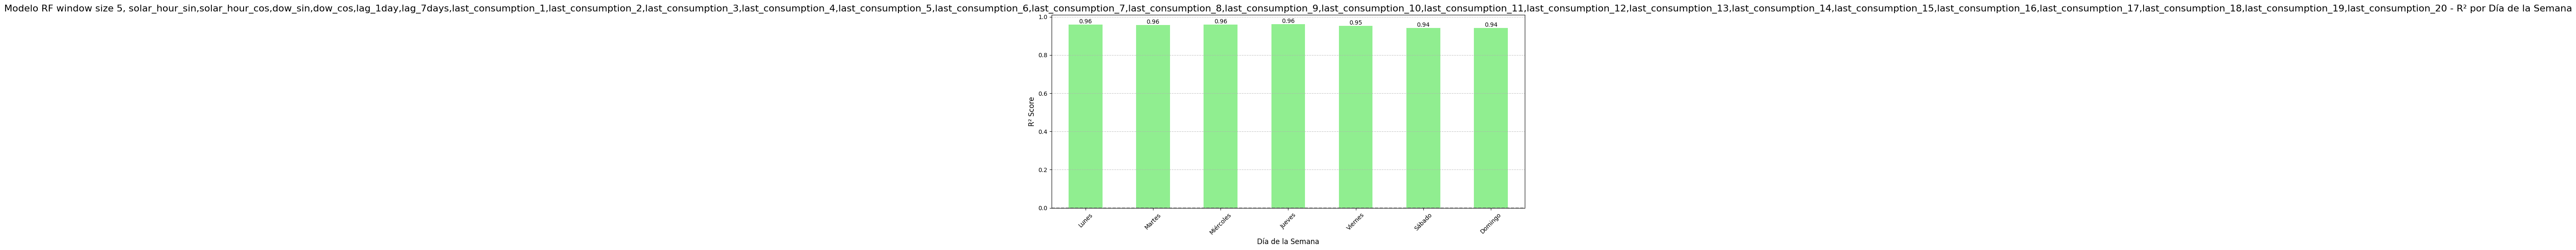

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import re

# Entrenamiento, evaluación y visualización de modelos Random Forest con diferentes window_size
target_column = 'total_consumption'
y = df_model_data[target_column]

# Filtrar variables con correlación >= threshold (excluyendo la propia target)
corr_threshold = 0.05
high_corr_var_names = corr_with_target[abs(corr_with_target) >= corr_threshold].drop("total_consumption").index.tolist()
print(f"Variables relacionadas con total_consumption con coef.corr >= {corr_threshold}:\n", high_corr_var_names)

#window_sizes = [1, 5, 10]
window_sizes = [5]
for window_size in window_sizes:
    feature_columns = [
        col for col in high_corr_var_names
        if re.match(r"last_consumption_[1-5]$", col)
        or not re.match(r"last_consumption_\d+$", col)
    ]
    # LASSO: First 8 columns
    feature_columns = ['last_consumption_1', 'daylight_fraction', 'hour_cos', 'solar_hour_sin', 'last_consumption_3', 'hour_sin', 'Inst_Temp', 'last_consumption_20']
    # LASSO: Full selection
    feature_columns = ['last_consumption_1', 'daylight_fraction', 'hour_cos', 'solar_hour_sin', 'last_consumption_3', 'hour_sin', 'Inst_Temp', 'last_consumption_20', 'last_consumption_9', 'last_consumption_13', 'last_consumption_10', 'Total_Global_Rad', 'last_consumption_12', 'dow_sin', 'Quantity_Precip', 'working_day', 'Avg_Wind_Direction', 'last_consumption_5']

    feature_columns = ['solar_hour_sin', 'solar_hour_cos', 'dow_sin', 'dow_cos', 'lag_1days', 'lag_7days',
                       'last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5',
                       'last_consumption_6', 'last_consumption_7', 'last_consumption_8', 'last_consumption_9', 'last_consumption_10',
                       'last_consumption_11', 'last_consumption_12', 'last_consumption_13', 'last_consumption_14', 'last_consumption_15',
                       'last_consumption_16', 'last_consumption_17', 'last_consumption_18', 'last_consumption_19', 'last_consumption_20'
    ]
    # MSE:  0.9043
    # RMSE: 0.9509
    # R²:   0.9541

#         ['daylight_fraction', 'next_daylight_fraction', 'working_day'] +
#         ['working_day', 'hour_sin', 'hour_cos'] +
#         ['solar_hour_sin', 'solar_hour_cos'] +
#          ['working_day', 'solar_hour_sin', 'solar_hour_cos'] +
#         weather_columns +
#         [f'last_consumption_{i}' for i in range(1, window_size + 1)]
#    )
    print(f"\nRF con {', '.join(feature_columns)}")

    X = df_model_data[feature_columns]

    print(f"Forma de X: {X.shape} | Forma de y: {y.shape}")
    print(f"Nulos en X: {X.isnull().sum().sum()} | Nulos en y: {y.isnull().sum()}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # ---------- Modelo y entrenamiento ----------
    rf_model = RandomForestRegressor(
        n_estimators=200,      # Amount of trees
        max_depth=None,        # Trees can reach any depth
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=SEED,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # ---------- Test y evaluación ----------
    eval_and_plot_model(rf_model, X_test, y_test, f'RF window size {window_size}, {",".join(feature_columns)}')



## Neural Networks

### Dense NN

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(15, 5))

# # Pérdida
# plt.subplot(1, 3, 1)
# plt.plot(history.history['loss'], label='Pérdida entrenamiento')
# plt.plot(history.history['val_loss'], label='Pérdida validación')
# plt.title('Pérdida del Modelo')
# plt.xlabel('Época')
# plt.ylabel('Pérdida')
# plt.legend()

# # Predicciones vs reales
# plt.subplot(1, 3, 3)
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
# plt.xlabel('Valores Reales')
# plt.ylabel('Predicciones')
# plt.title(f'Predicciones vs Reales (R²={r2:.3f})')

# plt.tight_layout()
# plt.show()

# print(f"\nEjemplos de predicciones:")
# print("Real\t\tPredicción\tDiferencia")
# print("-" * 40)
# for i in range(min(10, len(y_test))):
#     real = y_test.iloc[i]
#     pred = y_pred[i]
#     diff = abs(real - pred)
#     print(f"{real:.2f}\t\t{pred:.2f}\t\t{diff:.2f}")


#### Function to create the dense NN model

In [ ]:
### Function to create the dense NN model

from typing import List, Tuple
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model

def create_nn_dense_model(feature_columns: List[str]) -> Tuple[keras.Model, list]:
    model = keras.Sequential([
        keras.Input(shape=(len(feature_columns),)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer='adam',
        loss='mse'
    )
    model.summary()

    early_stopping_callback = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6
    )

    callbacks = [early_stopping_callback, reduce_lr_callback]

    return model, callbacks


#### Dense NN - absolute values serie and target R² 0.8781

Métricas aplicando el modelo "Dense NN - absolute values serie and target"

---

**Tier 1 -- 49 features**:  

CPU times: user 1min 1s, sys: 4.18 s, **total: 1min 5s** Wall time: 1min 6s
  MSE:  1.3046  
  **RMSE: 1.1422**  
  MAPE: 6.66%  
  **R²:   0.8781**  

---

**Tier 1 y Tier 2 -- 111 features**:  
CPU times: user 52.8 s, sys: 3.57 s, **total: 56.3 s** Wall time: 1min 4s
  MSE:  1.5120  
  **RMSE: 1.2297**  
  MAPE: 7.81%  
  **R²:   0.8587**  

---

**Tier 2 -- 62 features**:  
CPU times: user 1min 34s, sys: 5.97 s, **total: 1min 40s** Wall time: 2min 9s
  MSE:  2.2064  
  **RMSE: 1.4854**  
  MAPE: 8.74%  
  **R²:   0.7938**  

---

In [ ]:
model_name = 'Dense NN - absolute values serie and target'
feature_columns = df_tier1['feature'].tolist()

print(f"\nPreparing the data for the model '{model_name}'")
print(f"using the features {feature_columns}")

y = df_model_data['total_consumption'].copy()
X = df_model_data[feature_columns].copy()

X_train, X_test, y_tc_train, y_tc_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y_tc = StandardScaler()
y_tc_train_scaled = scaler_y_tc.fit_transform(y_tc_train.values.reshape(-1, 1)).flatten()
y_tc_test_scaled = scaler_y_tc.transform(y_tc_test.values.reshape(-1, 1)).flatten()

print("\nCreating the NN...")
model_tc, callbacks_list = create_nn_dense_model(feature_columns)

print("\nTraining the NN...")
def _train():
    return model_tc.fit(
        X_train_scaled,
        y_tc_train_scaled,
        batch_size=32,
        epochs=100,
        validation_split=0.2,
        callbacks=callbacks_list,
        verbose=1,
    )

%time history_tc = _train()  # Para que no se lie con la indentación
print(f"\nEvaluating {model_name}...")
y_tc_pred_scaled = model_tc.predict(X_test_scaled)
y_tc_pred = scaler_y_tc.inverse_transform(y_tc_pred_scaled.reshape(-1, 1)).flatten()
print_metrics(y_tc_test, y_tc_pred, model_name)



Preparing the data for the model 'Dense NN - absolute values serie and target'
using the features ['Inst_Temp', 'last_consumption_96', 'solar_hour_cos', 'lag_7days', 'last_consumption_92', 'last_consumption_1', 'last_consumption_94', 'last_consumption_40', 'lag_1days', 'last_consumption_93', 'last_consumption_90', 'last_consumption_88', 'last_consumption_3', 'last_consumption_11', 'last_consumption_43', 'last_consumption_6', 'last_consumption_5', 'last_consumption_23', 'last_consumption_89', 'last_consumption_44', 'last_consumption_84', 'last_consumption_8', 'last_consumption_20', 'last_consumption_2', 'last_consumption_19', 'hour_sin', 'last_consumption_86', 'last_consumption_29', 'last_consumption_91', 'last_consumption_7', 'last_consumption_28', 'last_consumption_14', 'last_consumption_22', 'solar_hour_sin', 'hour_cos', 'Total_Global_Rad', 'last_consumption_38', 'last_consumption_37', 'last_consumption_34', 'last_consumption_80', 'last_consumption_50', 'last_consumption_64', 'last_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,825 (22.75 KB)

 Trainable params: 5,825 (22.75 KB)

 Non-trainable params: 0 (0.00 B)


Training the NN...
Epoch 1/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2449 - val_loss: 0.0972 - learning_rate: 0.0010
Epoch 2/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0811 - val_loss: 0.1227 - learning_rate: 0.0010
Epoch 3/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0657 - val_loss: 0.1624 - learning_rate: 0.0010
Epoch 4/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0604 - val_loss: 0.1469 - learning_rate: 0.0010
Epoch 5/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0556 - val_loss: 0.1338 - learning_rate: 0.0010
Epoch 6/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0525 - val_loss: 0.1220 - learning_rate: 0.0010
Epoch 7/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0517 - val_loss: 0.1711 - learning_rate: 0.0010
Epoch 8/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0507 - val_loss: 0.1242 - learning_rate: 0.0010
Epoch 9/100
725/725 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0493 - val_loss: 0.1209 - lea

0.8814671577551149

In [ ]:
model_base_name_to_save = f"DenseNN_SEED_{SEED}_R2_{R2:.4f}"
save_model_and_scalers(model_tc, scaler_X, scaler_y_tc, model_base_name_to_save, feature_columns)



------------------------------------------------------------------
Saving model and scalers to /content/drive/MyDrive/Global Project Notebooks/trained_models/DenseNN_SEED_43_R2_0.8815...
Model and scalers succesfully saved

------------------------------------------------------------------


#### Dense NN Ensamble por franjas horarias R² 0.8933

---

Métricas globales ->  **R² 0.8933**

("Madrugada", range(0, 6)),   # 0..5  
("Mañana",    range(6, 12)),  # 6..11  
("Tarde",     range(12, 18)), # 12..17  
("Noche",     range(18, 24)), # 18..23

---

Métricas globales->  **R² 0.8900**

("Madrugada", range(0, 6)),    
("Mañana",    range(6, 8)),   
("Tarde",     range(8, 18)),  
("Noche",     range(18, 24)),  

Forma de X: (36239, 49) | Forma de y: (36239,)
Tamaños -> Train: 23194 | Val: 5798 | Test: 7247

Creando modelo para franja 'Madrugada' (horas [0, 1, 2, 3, 4, 5])...


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,825 (22.75 KB)

 Trainable params: 5,825 (22.75 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo para la franja 'Madrugada' (horas [0, 1, 2, 3, 4, 5])...
Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 1.4554 - val_loss: 0.7961 - learning_rate: 0.0010
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2817 - val_loss: 0.5921 - learning_rate: 0.0010
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2581 - val_loss: 0.6675 - learning_rate: 0.0010
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2270 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1966 - val_loss: 0.5858 - learning_rate: 0.0010
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1764 - val_loss: 0.5649 - learning_rate: 0.0010
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1701 - val_loss: 0.5466 - learning_rate: 0.0010
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1636 - val_loss: 0.5252 - learning_rate: 0.0010
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,825 (22.75 KB)

 Trainable params: 5,825 (22.75 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo para la franja 'Mañana' (horas [6, 7, 8, 9, 10, 11])...
Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - loss: 0.7105 - val_loss: 0.2776 - learning_rate: 0.0010
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3248 - val_loss: 0.2383 - learning_rate: 0.0010
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2348 - val_loss: 0.1990 - learning_rate: 0.0010
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2010 - val_loss: 0.1750 - learning_rate: 0.0010
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1701 - val_loss: 0.1618 - learning_rate: 0.0010
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1566 - val_loss: 0.1620 - learning_rate: 0.0010
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1471 - val_loss: 0.1633 - learning_rate: 0.0010
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1355 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,825 (22.75 KB)

 Trainable params: 5,825 (22.75 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo para la franja 'Tarde' (horas [12, 13, 14, 15, 16, 17])...
Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.7832 - val_loss: 0.3574 - learning_rate: 0.0010
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3066 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2377 - val_loss: 0.3007 - learning_rate: 0.0010
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2221 - val_loss: 0.2463 - learning_rate: 0.0010
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2138 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1793 - val_loss: 0.2205 - learning_rate: 0.0010
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1667 - val_loss: 0.2187 - learning_rate: 0.0010
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1597 - val_loss: 0.1864 - learning_rate: 0.0010
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/ste

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,825 (22.75 KB)

 Trainable params: 5,825 (22.75 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando modelo para la franja 'Noche' (horas [18, 19, 20, 21, 22, 23])...
Epoch 1/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 0.4480 - val_loss: 0.7954 - learning_rate: 0.0010
Epoch 2/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2219 - val_loss: 0.2420 - learning_rate: 0.0010
Epoch 3/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1697 - val_loss: 0.1950 - learning_rate: 0.0010
Epoch 4/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1379 - val_loss: 0.1790 - learning_rate: 0.0010
Epoch 5/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1367 - val_loss: 0.1679 - learning_rate: 0.0010
Epoch 6/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1170 - val_loss: 0.1503 - learning_rate: 0.0010
Epoch 7/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1138 - val_loss: 0.1602 - learning_rate: 0.0010
Epoch 8/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1054 - val_loss: 0.1343 - learning_rate: 0.0010
Epoch 9/300
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/st

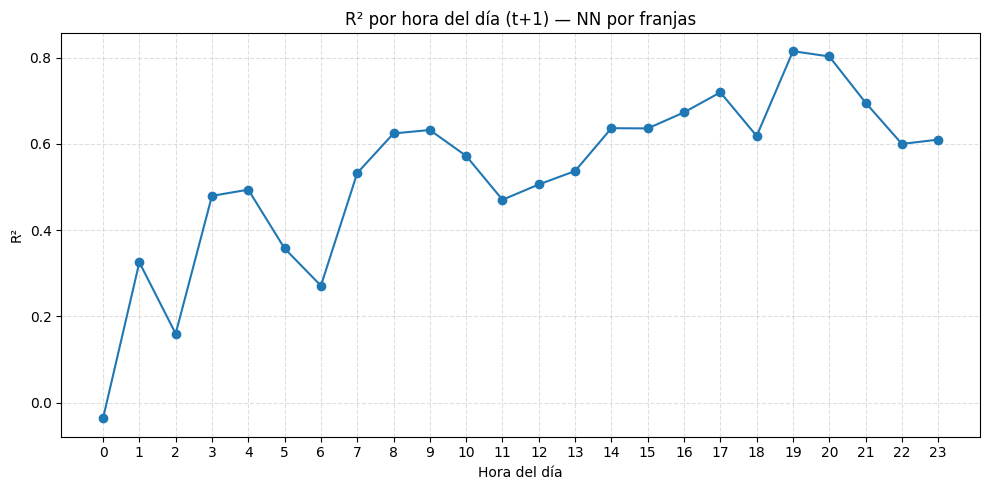


Muestras por hora en TEST (válidas):
Hora 00: 300 muestras
Hora 01: 300 muestras
Hora 02: 300 muestras
Hora 03: 300 muestras
Hora 04: 300 muestras
Hora 05: 300 muestras
Hora 06: 300 muestras
Hora 07: 300 muestras
Hora 08: 300 muestras
Hora 09: 300 muestras
Hora 10: 300 muestras
Hora 11: 300 muestras
Hora 12: 304 muestras
Hora 13: 304 muestras
Hora 14: 304 muestras
Hora 15: 304 muestras
Hora 16: 304 muestras
Hora 17: 304 muestras
Hora 18: 304 muestras
Hora 19: 304 muestras
Hora 20: 304 muestras
Hora 21: 304 muestras
Hora 22: 304 muestras
Hora 23: 303 muestras


In [ ]:
# =========================================
# Redes neuronales por franjas horarias (ensamblado)
# - Construye df_model_data con Time_next
# - Entrena una NN por franja (0-5, 6-11, 12-17, 18-23)
# - Predice en TEST con el modelo de su franja
# - Métricas por franja, globales y R² por hora
# =========================================
import os, random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow import keras
from tensorflow.keras import layers

# -------- Reproducibilidad --------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -------- 0) Parámetros --------
FRANJAS = [
    ("Madrugada", range(0, 6)),   # 0..5
    ("Mañana",    range(6, 12)),  # 6..11
    ("Tarde",     range(12, 18)), # 12..17
    ("Noche",     range(18, 24)), # 18..23
]
MIN_TRAIN_SAMPLES = 500   # mínimo por franja para entrenar (ajusta según tus datos)
BATCH_SIZE = 128
EPOCHS = 300

# Features y target
feature_columns = df_tier1['feature'].to_list()

X_all = df_model_data[feature_columns].copy()
y_all = df_model_data['total_consumption'].copy()

t_all = pd.Series(df_model_data.index.time, index=df_model_data.index)

print(f"Forma de X: {X_all.shape} | Forma de y: {y_all.shape}")

# -------- 1) Split temporal global: Train(64%) / Val(16%) / Test(20%) --------
n = len(X_all)
test_size = int(0.20 * n)
trainval_end = n - test_size

X_trainval = X_all.iloc[:trainval_end].copy()
y_trainval = y_all.iloc[:trainval_end].copy()
t_trainval = t_all.iloc[:trainval_end].copy()

X_test = X_all.iloc[trainval_end:].copy()
y_test = y_all.iloc[trainval_end:].copy()
t_test = t_all.iloc[trainval_end:].copy()

val_size = int(0.20 * len(X_trainval))
train_end = len(X_trainval) - val_size

X_train = X_trainval.iloc[:train_end].copy()
y_train = y_trainval.iloc[:train_end].copy()
t_train = t_trainval.iloc[:train_end].copy()

X_val   = X_trainval.iloc[train_end:].copy()   # no lo usamos para entrenar por franja, pero se podría
y_val   = y_trainval.iloc[train_end:].copy()
t_val   = t_trainval.iloc[train_end:].copy()

print(f"Tamaños -> Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

# -------- 2) Entrenar una NN por franja (con escalado por franja) --------
modelos_franja = {}
scalers_X = {}
scalers_y = {}
metrics_franja = []

for nombre_franja, horas in FRANJAS:
    mask_tr = t_train.index.hour.isin(list(horas))
    X_tr = X_train[mask_tr]
    y_tr = y_train[mask_tr]

    if len(X_tr) < MIN_TRAIN_SAMPLES:
        print(f"[{nombre_franja}] No entrenado: solo {len(X_tr)} muestras en TRAIN (min {MIN_TRAIN_SAMPLES}).")
        modelos_franja[nombre_franja] = None
        metrics_franja.append((nombre_franja, len(X_tr), np.nan, np.nan, np.nan))
        continue

    # Escalado por franja (fit sólo en TRAIN de esa franja)
    sx = StandardScaler()
    sy = StandardScaler()
    X_tr_s = sx.fit_transform(X_tr)
    y_tr_s = sy.fit_transform(y_tr.values.reshape(-1,1)).flatten()

    # Validación interna tomada del tramo final de ese subconjunto (temporal 80/20)
    n_tr = len(X_tr)
    n_val_sub = max(int(0.2*n_tr), 200)  # deja al menos 200 si hay datos
    X_tr_sub, X_va_sub = X_tr_s[:-n_val_sub], X_tr_s[-n_val_sub:]
    y_tr_sub, y_va_sub = y_tr_s[:-n_val_sub], y_tr_s[-n_val_sub:]

    print(f"\nCreando modelo para franja '{nombre_franja}' (horas {list(horas)})...")
    model, callbacks_list = create_nn_dense_model(feature_columns)

    print(f"\nEntrenando modelo para la franja '{nombre_franja}' (horas {list(horas)})...")
    %time model.fit(X_tr_sub, y_tr_sub, validation_data=(X_va_sub, y_va_sub), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False, verbose=1, callbacks=callbacks_list)

    print(f"\nEvaluando el modelo de la franja {nombre_franja}")
    # Guardar artefactos
    modelos_franja[nombre_franja] = model
    scalers_X[nombre_franja] = sx
    scalers_y[nombre_franja] = sy

    # Métricas en TEST para esta franja
    mask_te = t_test.index.hour.isin(list(horas))
    if mask_te.any():
        X_te_s = sx.transform(X_test[mask_te])
        y_pred_s = model.predict(X_te_s, verbose=0).reshape(-1,1)
        y_pred = sy.inverse_transform(y_pred_s).flatten()
        mse_f = mean_squared_error(y_test[mask_te], y_pred)
        rmse_f = np.sqrt(mse_f)
        r2_f = r2_score(y_test[mask_te], y_pred)
        metrics_franja.append((nombre_franja, mask_te.sum(), mse_f, rmse_f, r2_f))
    else:
        metrics_franja.append((nombre_franja, 0, np.nan, np.nan, np.nan))

# Mostrar métricas por franja
print("\nMétricas por franja (NN en TEST):")
print("Franja\t\t#Test\tMSE\t\tRMSE\t\tR²")
for nombre_franja, n_f, mse_f, rmse_f, r2_f in metrics_franja:
    mse_txt = f"{mse_f:.4f}" if not np.isnan(mse_f) else "nan"
    rmse_txt= f"{rmse_f:.4f}" if not np.isnan(rmse_f) else "nan"
    r2_txt  = f"{r2_f:.4f}" if not np.isnan(r2_f) else "nan"
    print(f"{nombre_franja:12s}\t{n_f:5d}\t{mse_txt}\t{rmse_txt}\t{r2_txt}")

# -------- 3) Predicción ensamblada en TEST (modelo según franja) --------
y_pred_ens = np.empty_like(y_test.values, dtype=float)
y_pred_ens[:] = np.nan


for (nombre_franja, horas) in FRANJAS:
    model = modelos_franja.get(nombre_franja)
    sx = scalers_X.get(nombre_franja)
    sy = scalers_y.get(nombre_franja)
    if (model is None) or (sx is None) or (sy is None):
        continue
    mask_te = t_test.index.hour.isin(list(horas))
    if mask_te.any():
        X_te_s = sx.transform(X_test[mask_te])
        y_pred_s = model.predict(X_te_s, verbose=0).reshape(-1,1)
        y_pred_ens[mask_te] = sy.inverse_transform(y_pred_s).flatten()

# Métricas globales del ensamblado (ignorando horas sin modelo)
mask_valid = ~np.isnan(y_pred_ens)
mse_global = mean_squared_error(y_test.values[mask_valid], y_pred_ens[mask_valid])
rmse_global = np.sqrt(mse_global)
r2_global = r2_score(y_test.values[mask_valid], y_pred_ens[mask_valid])

print("\nMétricas globales (TEST) del ensamblado por franjas (NN):")
print(f"MSE:  {mse_global:.4f}")
print(f"RMSE: {rmse_global:.4f}")
print(f"R²:   {r2_global:.4f}")

# -------- 6) R² por hora del día (ensamblado NN por franjas) --------
hours = np.arange(24)
r2_by_hour = []
counts = []

for h in hours:
    mask_h = (t_test.index.hour == h) & mask_valid
    if mask_h.sum() >= 10:
        r2_h = r2_score(y_test.values[mask_h], y_pred_ens[mask_h])
        r2_by_hour.append(r2_h)
        counts.append(mask_h.sum())
    else:
        r2_by_hour.append(np.nan)
        counts.append(mask_h.sum())

plt.figure(figsize=(10,5))
plt.plot(hours, r2_by_hour, marker='o')
plt.title('R² por hora del día (t+1) — NN por franjas')
plt.xlabel('Hora del día')
plt.ylabel('R²')
plt.xticks(hours)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print("\nMuestras por hora en TEST (válidas):")
for h, c in zip(hours, counts):
    print(f"Hora {h:02d}: {c} muestras")



### Dense NN DELTAS

#### Dense NN - DELTAS serie and DELTA target

In [ ]:
model_name = 'Dense NN - DELTAS serie and DELTA target'
%time

print(f"\nPreparing the data for the model '{model_name}'")
print(f"using the features {feature_columns}")

y_delta_abs = df_model_data['delta_abs'].copy()

X_train, X_test, y_delta_abs_train, y_delta_abs_test = train_test_split(
    X, y_delta_abs, test_size=0.2, random_state=42, shuffle=False
)

scaler_y_delta_abs = StandardScaler()
y_delta_abs_train_scaled = scaler_y_delta_abs.fit_transform(y_delta_abs_train.values.reshape(-1, 1)).flatten()
y_delta_abs_test_scaled = scaler_y_delta_abs.transform(y_delta_abs_test.values.reshape(-1, 1)).flatten()

print("\nCreating the NN...")
model_delta_abs, callbacks_list = create_nn_dense_model(feature_columns)

print("\nTraining the NN...")
history_delta_abs = model_delta_abs.fit(
    X_train_scaled, y_delta_abs_train_scaled,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(f"\nEvaluating {model_name}...")
y_delta_abs_pred_scaled = model_delta_abs.predict(X_test_scaled)
y_delta_abs_pred = scaler_y_delta_abs.inverse_transform(y_delta_abs_pred_scaled.reshape(-1, 1)).flatten()
print_metrics(y_delta_abs_test, y_delta_abs_pred, f"{model_name} (métricas en delta)")

y_delta_abs_pred_totals = X_test['last_consumption_1'] + y_delta_abs_pred
print_metrics(y_delta_abs_test, y_delta_abs_pred_totals, f"{model_name} (métricas en totales)")



#### Dense NN - DELTAS serie and DELTA_REL target

In [ ]:
# ----> delta_rel
model_name = 'Dense NN - DELTAS serie and DELTA_REL target'

print(f"\nPreparing the data for the model '{model_name}'")
print(f"using the features {feature_columns}")

y_dr = df_model_data['delta_rel'].copy()

X_train, X_test, y_dr_train, y_dr_test = train_test_split(
    X, y_dr, test_size=0.2, random_state=42, shuffle=False
)

scaler_dr_y = StandardScaler()
y_dr_train_scaled = scaler_dr_y.fit_transform(y_dr_train.values.reshape(-1, 1)).flatten()
y_dr_test_scaled = scaler_dr_y.transform(y_dr_test.values.reshape(-1, 1)).flatten()

print("\nCreating the NN...")
model_dr, callbacks_list = create_nn_dense_model(feature_columns)

print("\nTraining the NN...")
history_dr = model_dr.fit(
    X_train_scaled, y_dr_train_scaled,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
print(f"\nEvaluating {model_name}...")
y_dr_pred_scaled = model_dr.predict(X_test_scaled)
y_dr_pred = scaler_dr_y.inverse_transform(y_dr_pred_scaled.reshape(-1, 1)).flatten()
print_metrics(y_dr_test, y_dr_pred, F"red neuronal estimando DELTA_REL (métricas en delta)")

y_dr_pred_totals = X_test['last_consumption_1'] * (1 + y_dr_pred)
print_metrics(y_dr_test, y_dr_pred_totals, "red neuronal estimando DELTA_REL (métricas en totales)")


#### Dense NN - smooth deltas training

In [ ]:
# Con suavizado de la serie de incrementos
model_name = 'Dense NN - smooth deltas training'

# Features selected by permutation importance (selected_feature_names)
feature_columns = ['solar_hour_sin', 'solar_hour_cos']
feature_columns2 = ['hour_sin', 'hour_cos']
weather_columns = ['Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Max_Inst_Wind_Speed', 'Inst_Temp', 'Total_Global_Rad']

print(f"\nPreparing the data for the model '{model_name}'")
print(f"using the features {feature_columns}")

if "delta" not in df_model_data.columns:
    raise RuntimeError("\n⚠️ No se ha creado la columna 'delta' en df_model_data. Pon a True COMPUTE_DELTAS.")

# Smooth delta using 4-step moving average
df_model_data['smooth_delta'] = df_model_data['delta'].rolling(window=4).mean()

y_smooth_delta = df_model_data['smooth_delta']

# Crear el DataFrame vacío
X_smooth_delta = pd.DataFrame(index=df_model_data.index)

WINDOW_SIZE = 96
for i in range(1, WINDOW_SIZE + 1):
    X_smooth_delta[f'delta_{i}'] = df_model_data['smooth_delta'].shift(i)

for col in feature_columns:
    X_smooth_delta[col] = df_model_data[col]

# Eliminar filas con NaN en cualquier columna (generado por desplazamientos y diff)
X_smooth_delta = X_smooth_delta.dropna()

print(f"Forma de X_smooth_delta (características): {X_smooth_delta.shape}")
print(f"Forma de y_smooth_delta (objetivo): {y_smooth_delta.shape}")
print(f"Características utilizadas: {feature_columns}")

print("\nConstruyendo conjuntos de train y test")
X_smooth_delta_train, X_smooth_delta_test, y_smooth_delta_train, y_smooth_delta_test = train_test_split(
    X_smooth_delta, y_smooth_delta, test_size=0.2, random_state=42, shuffle=False
)
print(f"\nTamaño conjunto entrenamiento: {X_smooth_delta_train.shape[0]}")
print(f"\nTamaño conjunto test: {X_smooth_delta_test.shape[0]}")

print("\nEscalando X")
scaler_X_smooth_delta = StandardScaler()
X_smooth_delta_train_scaled = scaler_X_smooth_delta.fit_transform(X_smooth_delta_train)
X_smooth_delta_test_scaled = scaler_X_smooth_delta.transform(X_smooth_delta_test)

print("\nEscalando y")
scaler_y_smooth_delta = StandardScaler()
y_smooth_delta_train_scaled = scaler_y_smooth_delta.fit_transform(y_smooth_delta_train.values.reshape(-1, 1)).flatten()
y_smooth_delta_test_scaled = scaler_y_smooth_delta.transform(y_smooth_delta_test.values.reshape(-1, 1)).flatten()

##### Creación Modelo #####
print("\nCreating the NN...")
model_smooth_delta, callbacks_list = create_nn_dense_model(X_smooth_delta.columns)

print("\nTraining the NN...")
history_smooth_delta = model_smooth_delta.fit(
    X_smooth_delta_train_scaled, y_smooth_delta_train_scaled,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks = callbacks_list,
    verbose=1
)

print(f"\nEvaluating {model_name}...")

y_smooth_delta_pred_scaled = model_smooth_delta.predict(X_smooth_delta_test_scaled)
y_smooth_delta_pred = scaler_y_smooth_delta.inverse_transform(y_smooth_delta_pred_scaled.reshape(-1, 1)).flatten()

print_metrics(y_smooth_delta_test, y_smooth_delta_pred, f"{model_name} (métricas en DELTA)")

y_smooth_delta_pred_totals =  y_smooth_delta_pred + df_model_data['last_consumption_1'].loc[X_smooth_delta_test.index]

print_metrics(y_smooth_delta_test, y_smooth_delta_pred_totals, f"{model_name} (métricas en TOTALES)")



Preparing the data for the model 'Dense NN - smooth deltas training'
using the features ['solar_hour_sin', 'solar_hour_cos']
Forma de X_smooth_delta (características): (36812, 98)
Forma de y_smooth_delta (objetivo): (36911,)
Características utilizadas: ['solar_hour_sin', 'solar_hour_cos']

Construyendo conjuntos de train y test


ValueError: Found input variables with inconsistent numbers of samples: [36812, 36911]

#### Dense NN deltas to delta

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
import matplotlib.pyplot as plt

# Preparar los datos
print("Preparando los datos...")

y_full_delta_abs = df_model_data["total_consumption"] - df_model_data["last_consumption_1"]

X_full_delta_abs = df_model_data[feature_columns].copy()

# Features selected by permutation importance (selected_feature_names)
feature_columns = ['solar_hour_sin', 'solar_hour_cos', 'hour_sin', 'hour_cos', 'last_consumption_1', 'last_consumption_2',
                   'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'last_consumption_7', 'last_consumption_8',
                   'last_consumption_20', 'Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Max_Inst_Wind_Speed', 'Inst_Temp', 'Total_Global_Rad']

# --- Todas las columnas X_full_delta_abs['last_consumption_N'] se convierten a deltas
# --- X['last_consumption_N'] = X['last_consumption_N'] - X['last_consumption_N+1']

# Identificar las columnas que comienzan con 'last_consumption_'
consumption_cols = [col for col in X.columns if col.startswith('last_consumption_')]

# Ordenar las columnas por el número N de 'last_consumption_N'
consumption_cols.sort(key=lambda x: int(x.split('_')[-1]))

# Calcular los incrementos
for i in range(len(consumption_cols) - 1):
    current_col = consumption_cols[i]
    next_col = consumption_cols[i + 1]
    X_full_delta_abs[current_col] = X_full_delta_abs[current_col] - X_full_delta_abs[next_col]

# La última columna se iguala a la penúltima calculada
if len(consumption_cols) > 1:
    last_col = consumption_cols[-1]
    prev_col = consumption_cols[-2]
    X_full_delta_abs[last_col] = X_full_delta_abs[prev_col]

print(f"Forma de X_full_delta_abs (características): {X_full_delta_abs.shape}")
print(f"Forma de y_full_delta_abs (objetivo): {y_full_delta_abs.shape}")
print(f"Características utilizadas: {feature_columns}")

print("\nConstruyendo conjuntos de train y test")
X_full_delta_abs_train, X_full_delta_abs_test, y_full_delta_abs_train, y_full_delta_abs_test = train_test_split(
    X_full_delta_abs, y_full_delta_abs, test_size=0.2, random_state=42, shuffle=False
)
print(f"\nTamaño conjunto entrenamiento: {X_full_delta_abs_train.shape[0]}")
print(f"\nTamaño conjunto test: {X_full_delta_abs_test.shape[0]}")

print("\nEscalando X")
scaler_X_full_delta_abs = StandardScaler()
X_full_delta_abs_train_scaled = scaler_X_full_delta_abs.fit_transform(X_full_delta_abs_train)
X_full_delta_abs_test_scaled = scaler_X_full_delta_abs.transform(X_full_delta_abs_test)

print("\nEscalando y")
scaler_y_full_delta_abs = StandardScaler()
y_full_delta_abs_train_scaled = scaler_y_full_delta_abs.fit_transform(y_full_delta_abs_train.values.reshape(-1, 1)).flatten()
y_full_delta_abs_test_scaled = scaler_y_full_delta_abs.transform(y_full_delta_abs_test.values.reshape(-1, 1)).flatten()

##### Creación Modelo #####
print("\nCreando el modelo de red Neuronal para FULL_DELTA_ABS...")

model_full_delta_abs = keras.Sequential([
    keras.Input(shape=(len(feature_columns),)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

# Compilar usando RMSE como métrica
model_full_delta_abs.compile(
    optimizer='adam',
    loss='mse'
)
model_full_delta_abs.summary()

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

print("\nEntrenando el modelo FULL_DELTA_ABS...")
history_full_delta_abs = model_full_delta_abs.fit(
    X_full_delta_abs_train_scaled, y_full_delta_abs_train_scaled,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nEvaluando el modelo FULL_DELTA_ABS...")

y_full_delta_abs_pred_scaled = model_full_delta_abs.predict(X_full_delta_abs_test_scaled)
y_full_delta_abs_pred = scaler_y_full_delta_abs.inverse_transform(y_full_delta_abs_pred_scaled.reshape(-1, 1)).flatten()

print_metrics(y_full_delta_abs_test, y_full_delta_abs_pred, "NN FULL_DELTA_ABS (métricas en DELTA)")

y_full_delta_abs_pred_totals =  y_full_delta_abs_pred + df_model_data['last_consumption_1'].loc[X_full_delta_abs_test.index]

print_metrics(y_full_delta_abs_test, y_full_delta_abs_pred_totals, "NN FULL_DELTA_ABS (métricas en TOTALES)")


Preparando los datos...
Forma de X_full_delta_abs (características): (36911, 19)
Forma de y_full_delta_abs (objetivo): (36911,)
Características utilizadas: ['solar_hour_sin', 'solar_hour_cos', 'hour_sin', 'hour_cos', 'last_consumption_1', 'last_consumption_2', 'last_consumption_3', 'last_consumption_4', 'last_consumption_5', 'last_consumption_6', 'last_consumption_7', 'last_consumption_8', 'last_consumption_20', 'Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction', 'Max_Inst_Wind_Speed', 'Inst_Temp', 'Total_Global_Rad']

Construyendo conjuntos de train y test

Tamaño conjunto entrenamiento: 29528

Tamaño conjunto test: 7383

Escalando X

Escalando y

Creando el modelo de red Neuronal para FULL_DELTA_ABS...


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,905 (15.25 KB)

 Trainable params: 3,905 (15.25 KB)

 Non-trainable params: 0 (0.00 B)


Entrenando el modelo FULL_DELTA_ABS...
Epoch 1/100
739/739 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.9337 - rmse_metric: 0.9757 - val_loss: 1.2246 - val_rmse_metric: 1.1264 - learning_rate: 0.0010
Epoch 2/100
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8538 - rmse_metric: 0.9660 - val_loss: 1.1910 - val_rmse_metric: 1.1340 - learning_rate: 0.0010
Epoch 3/100
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8433 - rmse_metric: 0.9710 - val_loss: 1.1645 - val_rmse_metric: 1.1414 - learning_rate: 0.0010
Epoch 4/100
739/739 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.8324 - rmse_metric: 0.9751 - val_loss: 1.1264 - val_rmse_metric: 1.1544 - learning_rate: 0.0010
Epoch 5/100
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8210 - rmse_metric: 0.9818 - val_loss: 1.1331 - val_rmse_metric: 1.1495 - learning_rate: 0.0010
Epoch 6/100
739/739 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8147 - rmse_metric: 0.9823 - val_loss: 1.1213 - val_rmse_metric: 1.1457 - learning_rate: 0.0010
Epoch 

### LSTM

#### LSTM sequence + context R² 0.8982

In [ ]:
  # --- LSTM sequence + context
  from sklearn.preprocessing import StandardScaler
  from tensorflow import keras
  import sklearn

  # -------------------------------------------------------
  # Configuración
  WINDOW = 20
  SEQ_COLS = [f'last_consumption_{i}' for i in range(1, WINDOW + 1)]
  TARGET_COL = "total_consumption"

  # ---- CONTEXT FEATURES SET 1 - WS 20 -----------------------------
  # WINDOW = 20
  # CTX_COLS = [
  #     'solar_hour_sin', 'solar_hour_cos', 'hour_sin', 'hour_cos',
  #     'Avg_Temp', 'Avg_Rel_Humidity', 'Avg_Wind_Direction',
  #     'Max_Inst_Wind_Speed', 'Inst_Temp', 'Total_Global_Rad'
  # ]
  # RMSE: 1.0270
  # RME (%): -1.35
  # R²: 0.8929

  # ---- CONTEXT FEATURES SET 2 (simplified) - WS 20  --------------------
  # WINDOW = 20
  # CTX_COLS = [
  #     'solar_hour_sin', 'solar_hour_cos',
  #     'Avg_Temp', 'Avg_Rel_Humidity' , 'Inst_Temp'
  # ]
  # RMSE: 1.0291
  # RME (%): -0.94
  # R²: 0.8925

  # ---- CONTEXT FEATURES SET 3 (without weather) - WS 20  --------------------
  # WINDOW = 20
  # CTX_COLS = [
  #     'solar_hour_sin', 'solar_hour_cos'
  # ]
  # RMSE: 1.0186
  # RME (%): 0.50
  # R²: 0.8947

  # ---- CONTEXT FEATURES SET 4 (no weather, with dow_sin/cos) - WS 20  -----------------
  # WINDOW = 20
# CTX_COLS = [
#     'solar_hour_sin', 'solar_hour_cos', 'dow_sin', 'dow_cos'
# ]
# RMSE: 1.0082
# RME (%): 0.81
# R²: 0.8968

# ---- CONTEXT FEATURES SET 5 (no weather, with dow_sin/cos) - WS 96  -----------------
# WINDOW = 96
# CTX_COLS = [
#     'solar_hour_sin', 'solar_hour_cos', 'dow_sin', 'dow_cos'
# ]
# RMSE: 1.1074
# RME (%): 0.62
# R²: 0.8756        -- Con WS 96 ha sido peor que con WS 20

#---- CONTEXT FEATURES SET 6 (no weather, with dow_sin/cos, +lags 1 & 7 days) - WS 20  -----------------
WINDOW = 20
CTX_COLS = [
    'solar_hour_sin', 'solar_hour_cos', 'dow_sin', 'dow_cos',
    'lag_1days', 'lag_2days', 'lag_7days'
]
# MSE:  0.9888
# RMSE: 0.9944
# MAPE: 5.78%
# R²:   0.8982


# -------------------------------------------------------
# Extrae matrices base (float32)
N = len(df_model_data)
y = df_model_data[TARGET_COL].astype(np.float32).values
X_seq = df_model_data[SEQ_COLS].astype(np.float32).values
X_ctx = df_model_data[CTX_COLS].astype(np.float32).values

# -------------------------------------------------------
# Split temporal: 70% train, 15% val, 15% test
i_train = int(0.70 * N)
i_val   = int(0.85 * N)

X_seq_tr, X_ctx_tr, y_tr = X_seq[:i_train],       X_ctx[:i_train],       y[:i_train]
X_seq_va, X_ctx_va, y_va = X_seq[i_train:i_val],  X_ctx[i_train:i_val],  y[i_train:i_val]
X_seq_te, X_ctx_te, y_te = X_seq[i_val:],         X_ctx[i_val:],         y[i_val:]

# -------------------------------------------------------
# Scaler del objetivo (y misma variable en la rama secuencial)
y_scaler = StandardScaler()
y_scaler.fit(y_tr.reshape(-1, 1))

def scale_seq_with(scaler, x_seq_2d):
    """
    x_seq_2d: array shape (n_samples, WINDOW) con rezagos del objetivo
    Aplica el mismo scaler del objetivo a cada elemento de la secuencia.
    """
    s = x_seq_2d.reshape(-1, 1)
    s = scaler.transform(s).reshape(x_seq_2d.shape)
    return s.astype(np.float32)

X_seq_tr_s = scale_seq_with(y_scaler, X_seq_tr)
X_seq_va_s = scale_seq_with(y_scaler, X_seq_va)
X_seq_te_s = scale_seq_with(y_scaler, X_seq_te)

# Objetivo escalado
y_tr_s = y_scaler.transform(y_tr.reshape(-1, 1)).ravel().astype(np.float32)
y_va_s = y_scaler.transform(y_va.reshape(-1, 1)).ravel().astype(np.float32)
y_te_s = y_scaler.transform(y_te.reshape(-1, 1)).ravel().astype(np.float32)

# Añade la dimensión de features para LSTM: (batch, WINDOW, 1)
X_seq_tr_s = X_seq_tr_s.reshape(-1, WINDOW, 1)
X_seq_va_s = X_seq_va_s.reshape(-1, WINDOW, 1)
X_seq_te_s = X_seq_te_s.reshape(-1, WINDOW, 1)

# -------------------------------------------------------
# Scaler del contexto (independiente del objetivo)
ctx_scaler = StandardScaler()
ctx_scaler.fit(X_ctx_tr)
X_ctx_tr = ctx_scaler.transform(X_ctx_tr).astype(np.float32)
X_ctx_va = ctx_scaler.transform(X_ctx_va).astype(np.float32)
X_ctx_te = ctx_scaler.transform(X_ctx_te).astype(np.float32)

# -------------------------------------------------------
# Modelo LSTM (sequence + context)
seq_in = keras.Input(shape=(WINDOW, 1), name="seq_in")
ctx_in = keras.Input(shape=(X_ctx.shape[1],), name="ctx_in")

h = keras.layers.LSTM(64, return_sequences=False)(seq_in)
h = keras.layers.Dropout(0.2)(h)

z = keras.layers.Concatenate()([h, ctx_in])
z = keras.layers.Dense(64, activation="relu")(z)
z = keras.layers.Dense(32, activation="relu")(z)
out = keras.layers.Dense(1, name="yhat_scaled")(z)

model = keras.Model([seq_in, ctx_in], out)
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mae")
model.summary()

cb = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5),
]

history = model.fit(
    [X_seq_tr_s, X_ctx_tr], y_tr_s,
    validation_data=([X_seq_va_s, X_ctx_va], y_va_s),
    epochs=200,
    batch_size=256,
    verbose=1,
    callbacks=cb
)

# -------------------------------------------------------
# Predicción en test e inversión de escala
yhat_te_s = model.predict([X_seq_te_s, X_ctx_te], verbose=0).ravel()
yhat_te = y_scaler.inverse_transform(yhat_te_s.reshape(-1, 1)).ravel()

# -------------------------------------------------------
# Métricas
print_metrics(y_te, yhat_te, "LSTM sequence + context")


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 20, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     16,896 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctx_in (InputLayer) │ (None, 7)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 71)        │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ ctx_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      4,608 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 32)        │      2,080 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yhat_scaled (Dense) │ (None, 1)         │         33 │ dense_15[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,617 (92.25 KB)

 Trainable params: 23,617 (92.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.4145 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2501 - val_loss: 0.2333 - learning_rate: 0.0010
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2141 - val_loss: 0.2284 - learning_rate: 0.0010
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2036 - val_loss: 0.2228 - learning_rate: 0.0010
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1990 - val_loss: 0.2151 - learning_rate: 0.0010
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1977 - val_loss: 0.2354 - learning_rate: 0.0010
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1927 - val_loss: 0.2580 - learning_rate: 0.0010
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1926 - val_loss: 0.2034 - learning_rate: 0.0010
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1848 - val_loss: 0.2065 - learning_rate: 0.0

#### LSTM con ventana 14 días R² 0.9151
Métricas aplicando el modelo LSTM con **ventana de 7 días** (672 muestras):  
  **MAPE 5.84%**  
  **R² 0.9107**  

Métricas aplicando el modelo LSTM con **ventana de 14 días**:  
CPU times: user 9min 48s, sys: 30.3 s, **total: 10min 19s** Wall time: 10min 37s  
  MSE:  0.9113  
  RMSE: 0.9546  
  MAPE: 5.62%  
  **R²:   0.9151**

Métricas aplicando el modelo LSTM con **ventana de 60 días**:  
CPU times: user 27min 1s, sys: 1min 5s, **total: 28min 7s** Wall time: 33min 44s  
  MSE:  0.9197  
  **RMSE: 0.9590**  
  MAPE: 5.68%  
  **R²:   0.9141**  

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# =========================
# Parámetros
# =========================
N_DAYS_WINDOW = 7                 # p.ej., 1 semana de historial
LOOK_BACK = 96 * N_DAYS_WINDOW    # 96 muestras/día
TRAIN_RATIO = 0.8                 # 80% train, 20% test (cronológico)
VAL_RATIO_WITHIN_TRAIN = 0.1      # 10% del train para validación
BATCH_SIZE = 64
EPOCHS = 30
SEED = 42
tf.random.set_seed(SEED)

# =========================
# Split cronológico base: train / test
# =========================
split_idx = int(len(df_model_data['total_consumption']) * TRAIN_RATIO)
train_raw = df_model_data['total_consumption'][:split_idx].values.astype('float32').reshape(-1, 1)
test_raw  = df_model_data['total_consumption'][split_idx:].values.astype('float32').reshape(-1, 1)

# =========================
# Escalado (fit SOLO con train)
# =========================
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

# Serie completa escalada (recomponemos para construir ventanas contiguas)
series_scaled = np.vstack([train_scaled, test_scaled])

# =========================
# Helper para crear datasets ventana->siguiente paso
# (X: secuencia de LOOK_BACK, y: siguiente muestra)
# =========================
def make_dataset(series_scaled, look_back, batch_size, shuffle):
    data = series_scaled[:-1]
    targets = series_scaled[look_back:]
    ds = keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=look_back,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# =========================
# Train / Val dentro de train (cronológico, con contexto para val)
# =========================
len_train = len(train_scaled)
val_len = max(1, int(len_train * VAL_RATIO_WITHIN_TRAIN))

# Núcleo de train (sin el último bloque reservado a validación)
train_core = train_scaled[:len_train - val_len]

# Para validación añadimos LOOK_BACK muestras previas como contexto
val_series = train_scaled[len_train - val_len - LOOK_BACK:]

train_ds = make_dataset(train_core, LOOK_BACK, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(val_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Test con contexto: incluir LOOK_BACK muestras anteriores al corte
# =========================
test_series = series_scaled[split_idx - LOOK_BACK:]
test_ds     = make_dataset(test_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Modelo LSTM sencillo
# =========================
model = keras.Sequential([
    layers.Input(shape=(LOOK_BACK, 1)),
    layers.LSTM(64),
    layers.Dense(1),
])

model.compile(optimizer='adam', loss='mse')
model.summary()


early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

callbacks_list = [early_stopping_callback, reduce_lr_callback]

%time history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks_list, verbose=1)

# =========================
# Evaluación en test
# =========================
y_pred_scaled = model.predict(test_ds, verbose=0)
# El ground-truth para test son las muestras posteriores a LOOK_BACK dentro de test_series
y_true_scaled = test_series[LOOK_BACK:]

# Invertimos el escalado para métricas en unidades originales
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_true_scaled)

print_metrics(y_true, y_pred, f'LSTM con ventana de {N_DAYS_WINDOW}')


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 56s 169ms/step - loss: 0.0144 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 2/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - loss: 0.0019 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 3/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 60s 187ms/step - loss: 0.0015 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 4/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 77s 172ms/step - loss: 0.0012 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 71s 224ms/step - loss: 0.0011 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 6/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 78s 244ms/step - loss: 9.7844e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 75s 234ms/step - loss: 9.5966e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 54s 170ms/step - loss: 9.2384e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 9/30
318/318 ━━━━━━━━━━━━━━━━━━━━ 73s 229ms/step - loss: 9.0276e-04 - val_loss

#### LSTM con ventana de 14 días y series contexto SOLAR_hour_... R² 0.9174
ctxt_features = **['solar_hour_sin', 'solar_hour_cos']**  
Métricas aplicando el modelo LSTM (y + sin/cos) **ventana 14d**:  
CPU times: user 9min 57s, sys: 29.7 s, **total: 10min 27s**  
Wall time: 9min 38s  
Con **SEED = 42**  
>  MSE:  0.8976  
  **RMSE: 0.9474**  
  MAPE: 5.62%  
  **R²:   0.9164**  

---

Con **SEED = 43**  
>  MSE:  0.8845  
  **RMSE: 0.9405**  
  MAPE: 5.61%  
  **R²:   0.9174**  

---

Con **SEED = 43**  

ctxt_features = ['dow_sin', 'dow_cos', 'solar_hour_sin', 'solar_hour_cos']

Métricas aplicando el modelo LSTM (y + sin/cos) ventana 14d:  
  MSE:  0.8758  
  **RMSE: 0.9358**  
  MAPE: 5.56%  
  **R²:   0.9182**  

---

In [ ]:
### Set configuration variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# =========================
# Parámetros
# =========================
N_DAYS_WINDOW = 14                # p.ej., 2 semanas de historial
LOOK_BACK = 96 * N_DAYS_WINDOW    # 96 muestras/día
TRAIN_RATIO = 0.8                 # 80% train, 20% test (cronológico)
VAL_RATIO_WITHIN_TRAIN = 0.1      # 10% del train para validación
BATCH_SIZE = 64
EPOCHS = 30
SEED = 43
tf.random.set_seed(SEED)

ctxt_features = ['dow_sin', 'dow_cos', 'solar_hour_sin', 'solar_hour_cos']

model_base_name_to_save = f'LSTM_{N_DAYS_WINDOW}d_dow_and_solar_hour_SEED_{SEED}'


In [ ]:
### Training, validation and saving of the model

# =========================
# Split cronológico base: train / test (mismo corte para y y exógenas)
# =========================
split_idx = int(len(df_model_data['total_consumption']) * TRAIN_RATIO)

y_train_raw = df_model_data['total_consumption'][:split_idx].values.reshape(-1, 1)
y_test_raw = df_model_data['total_consumption'][split_idx:].values.reshape(-1, 1)
Xctx_train_raw = df_model_data[ctxt_features][:split_idx].values
Xctx_test_raw  = df_model_data[ctxt_features][split_idx:].values

# =========================
# Escalado
# - y: su propio scaler (para poder invertir después)
# - contextos: un scaler conjunto para [sin, cos]
# =========================
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled  = scaler_y.transform(y_test_raw)

scaler_ctx = MinMaxScaler()
Xctx_train_scaled = scaler_ctx.fit_transform(Xctx_train_raw)
Xctx_test_scaled  = scaler_ctx.transform(Xctx_test_raw)

# Serie completa escalada (para construir ventanas contiguas)
y_series_scaled   = np.vstack([y_train_scaled, y_test_scaled])                 # (n, 1)
Xctx_series_scaled = np.vstack([Xctx_train_scaled, Xctx_test_scaled])          # (n, 2)

# Features finales por timestep: [y_t, sin_t, cos_t]
X_series_scaled = np.hstack([y_series_scaled, Xctx_series_scaled])             # (n, 3)

# =========================
# Helper para crear datasets ventana->siguiente paso
# (X: secuencia de LOOK_BACK con 3 features, y: siguiente y_t+1)
# =========================
def make_dataset(X_scaled, y_scaled, look_back, batch_size, shuffle):
    # Queremos que la secuencia abarque [t-LOOK_BACK ... t-1] y el target sea y_t
    X_data = X_scaled[:-1]                # quitamos el último porque no tendrá target
    y_targ = y_scaled[look_back:]         # targets alineados con el final de la ventana

    ds = keras.utils.timeseries_dataset_from_array(
        data=X_data,
        targets=y_targ,
        sequence_length=look_back,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# =========================
# Train / Val dentro de train (cronológico, con contexto para val)
# =========================
len_train = len(y_train_scaled)
val_len = max(1, int(len_train * VAL_RATIO_WITHIN_TRAIN))

# Núcleo de train (sin el último bloque reservado a validación)
X_train_core = X_series_scaled[:len_train - val_len]
y_train_core = y_series_scaled[:len_train - val_len]

# Para validación añadimos LOOK_BACK muestras previas como contexto
X_val_series = X_series_scaled[len_train - val_len - LOOK_BACK : len_train]
y_val_series = y_series_scaled[len_train - val_len - LOOK_BACK : len_train]

train_ds = make_dataset(X_train_core, y_train_core, LOOK_BACK, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(X_val_series, y_val_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Test con contexto: incluir LOOK_BACK muestras anteriores al corte
# =========================
X_test_series = X_series_scaled[split_idx - LOOK_BACK:]
y_test_series = y_series_scaled[split_idx - LOOK_BACK:]
test_ds       = make_dataset(X_test_series, y_test_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Modelo LSTM multivariante (3 features: y, sin, cos)
# =========================
model = keras.Sequential([
    layers.Input(shape=(LOOK_BACK, 1 + len(ctxt_features)), name="input_sequences"),
    layers.LSTM(64, name="LSTM_64"),
    layers.Dense(1, name="output_prediction"),
], name="LSTM_series_ctxt")

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

callbacks_list = [early_stopping_callback, reduce_lr_callback]

%time history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks_list, verbose=1)

# =========================
# Evaluación en test
# =========================
y_pred_scaled = model.predict(test_ds, verbose=0)

# El ground-truth para test son las muestras posteriores a LOOK_BACK dentro de y_test_series
y_true_scaled = y_test_series[LOOK_BACK:]           # (m, 1)

# Invertimos el escalado para métricas en unidades originales
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

print(f'ctxt_features = {ctxt_features}')
print_metrics(y_true, y_pred, f'LSTM (y + sin/cos) ventana {N_DAYS_WINDOW}d')

save_model_and_scalers(model, scaler_ctx, scaler_y, model_base_name_to_save)


Model: "LSTM_series_ctxt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_64 (LSTM)                  │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_prediction (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - loss: 0.0080 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0013 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 3/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 0.0010 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 5/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 9.2866e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 6/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 8.9156e-04 - val_loss: 9.9849e-04 - learning_rate: 0.0010
Epoch 7/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - loss: 8.6366e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 8/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 8.4201e-04 - val_loss: 9.9595e-04 - learning_rate: 0.0010
Epoch 9/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 8.3308e-04 - val_l

#### LSTM con ventana de 14 días y series contexto hour_... R² 0.9148

Métricas aplicando el modelo LSTM (y + sin/cos) ventana 14d:
CPU times: user 10min 16s, sys: 29.6 s, **total: 10min 45s** Wall time: 10min 23s  
ctxt_features = [['hour_sin', 'hour_cos']]  

  MSE:  0.9142  
  **RMSE: 0.9561**  
  MAPE: 5.71%  
  **R²:   0.9148**  

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# =========================
# Parámetros
# =========================
N_DAYS_WINDOW = 14                # p.ej., 2 semanas de historial
LOOK_BACK = 96 * N_DAYS_WINDOW    # 96 muestras/día
TRAIN_RATIO = 0.8                 # 80% train, 20% test (cronológico)
VAL_RATIO_WITHIN_TRAIN = 0.1      # 10% del train para validación
BATCH_SIZE = 64
EPOCHS = 30
SEED = 42
tf.random.set_seed(SEED)

ctxt_features = ['hour_sin', 'hour_cos']

# =========================
# Split cronológico base: train / test (mismo corte para y y exógenas)
# =========================
split_idx = int(len(df_model_data['total_consumption']) * TRAIN_RATIO)

y_train_raw = df_model_data['total_consumption'][:split_idx].values.astype(np.float32).reshape(-1, 1)
y_test_raw = df_model_data['total_consumption'][split_idx:].values.astype(np.float32).reshape(-1, 1)
Xctx_train_raw = df_model_data[ctxt_features][:split_idx].values.astype(np.float32)
Xctx_test_raw  = df_model_data[ctxt_features][split_idx:].values.astype(np.float32)

# =========================
# Escalado
# - y: su propio scaler (para poder invertir después)
# - contextos: un scaler conjunto para [sin, cos]
# =========================
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled  = scaler_y.transform(y_test_raw)

scaler_ctx = MinMaxScaler()
Xctx_train_scaled = scaler_ctx.fit_transform(Xctx_train_raw)
Xctx_test_scaled  = scaler_ctx.transform(Xctx_test_raw)

# Serie completa escalada (para construir ventanas contiguas)
y_series_scaled   = np.vstack([y_train_scaled, y_test_scaled])                 # (n, 1)
Xctx_series_scaled = np.vstack([Xctx_train_scaled, Xctx_test_scaled])          # (n, 2)

# Features finales por timestep: [y_t, sin_t, cos_t]
X_series_scaled = np.hstack([y_series_scaled, Xctx_series_scaled])             # (n, 3)

# =========================
# Helper para crear datasets ventana->siguiente paso
# (X: secuencia de LOOK_BACK con 3 features, y: siguiente y_t+1)
# =========================
def make_dataset(X_scaled, y_scaled, look_back, batch_size, shuffle):
    # Queremos que la secuencia abarque [t-LOOK_BACK ... t-1] y el target sea y_t
    X_data = X_scaled[:-1]                # quitamos el último porque no tendrá target
    y_targ = y_scaled[look_back:]         # targets alineados con el final de la ventana

    ds = keras.utils.timeseries_dataset_from_array(
        data=X_data,
        targets=y_targ,
        sequence_length=look_back,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# =========================
# Train / Val dentro de train (cronológico, con contexto para val)
# =========================
len_train = len(y_train_scaled)
val_len = max(1, int(len_train * VAL_RATIO_WITHIN_TRAIN))

# Núcleo de train (sin el último bloque reservado a validación)
X_train_core = X_series_scaled[:len_train - val_len]
y_train_core = y_series_scaled[:len_train - val_len]

# Para validación añadimos LOOK_BACK muestras previas como contexto
X_val_series = X_series_scaled[len_train - val_len - LOOK_BACK : len_train]
y_val_series = y_series_scaled[len_train - val_len - LOOK_BACK : len_train]

train_ds = make_dataset(X_train_core, y_train_core, LOOK_BACK, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(X_val_series, y_val_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Test con contexto: incluir LOOK_BACK muestras anteriores al corte
# =========================
X_test_series = X_series_scaled[split_idx - LOOK_BACK:]
y_test_series = y_series_scaled[split_idx - LOOK_BACK:]
test_ds       = make_dataset(X_test_series, y_test_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Modelo LSTM multivariante (3 features: y, sin, cos)
# =========================
model = keras.Sequential([
    layers.Input(shape=(LOOK_BACK, 1 + len(ctxt_features)), name="input_sequences"),
    layers.LSTM(64, name="LSTM_64"),
    layers.Dense(1, name="output_prediction"),
], name="LSTM_series_ctxt")

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

callbacks_list = [early_stopping_callback, reduce_lr_callback]

%time history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks_list, verbose=1)

# =========================
# Evaluación en test
# =========================
y_pred_scaled = model.predict(test_ds, verbose=0)

# El ground-truth para test son las muestras posteriores a LOOK_BACK dentro de y_test_series
y_true_scaled = y_test_series[LOOK_BACK:]           # (m, 1)

# Invertimos el escalado para métricas en unidades originales
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

print(f'ctxt_features = [{ctxt_features}]')
print_metrics(y_true, y_pred, f'LSTM (y + sin/cos) ventana {N_DAYS_WINDOW}d')


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 0.0135 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 2/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 0.0014 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.0012 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 0.0010 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 9.5253e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 6/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 8.8631e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 7/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 22s 54ms/step - loss: 8.6826e-04 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 8/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - loss: 8.4101e-04 - val_loss: 9.7875e-04 - learning_rate: 0.0010
Epoch 9/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - loss: 8.0209e-04 - val_loss:

#### LSTM con ventana de 14 días y contexto simple SOLAR_hour_... R² 0.9128

CPU times: user 7min 52s, sys: 6.95 s, **total: 7min 59s** Wall time: 8min 48s  

Métricas aplicando el modelo LSTM serie + contexto(sin,cos)@t-1 | ventana 14d:  
  MSE:  0.9447  
  **RMSE: 0.9720**  
  MAPE: 5.73%  
  **R²:   0.9128**


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, Model
from sklearn.preprocessing import MinMaxScaler

# =========================
# Parámetros
# =========================
N_DAYS_WINDOW = 14
LOOK_BACK = 96 * N_DAYS_WINDOW
TRAIN_RATIO = 0.8
VAL_RATIO_WITHIN_TRAIN = 0.1
BATCH_SIZE = 64
EPOCHS = 30
SEED = 42
tf.random.set_seed(SEED)

# =========================
# (Opcional pero recomendado) Alinear índices por si difieren tz/huecos
# =========================
ctxt_features = ['solar_hour_sin', 'solar_hour_cos']
for c in ctxt_features:
    if c not in df_model_data.columns:
        raise KeyError(f"Falta la columna {c} en df_model_data")

# def _normalize_index(df):
#     i = df.index
#     if getattr(i, "tz", None) is not None:
#         i = i.tz_convert("Europe/Madrid").tz_localize(None)
#     return df.set_index(i)

# df1 = _normalize_index(df_consumptions_15m[['total_consumption']])
# df2 = _normalize_index(df_model_data[ctxt_features])

# df_aligned = df1.join(df2, how='left')
# if df_aligned[ctxt_features].isna().any().any():
#     df_aligned[ctxt_features] = (
#         df_aligned[ctxt_features]
#         .interpolate(method='time', limit_direction='both')
#         .fillna(0.0)
#     )

df_aligned = df_consumptions_15m.join(df_model_data[ctxt_features], how='left')
nan_counts = df_aligned[ctxt_features].isna().sum()
print("NaN por columna:", nan_counts)

# =========================
# Arrays crudos
# =========================
y_raw   = df_aligned['total_consumption'].astype('float32').to_numpy().reshape(-1, 1)
ctx_raw = df_aligned[ctxt_features].astype('float32').to_numpy()  # shape (n, 2)

n = len(y_raw)
assert n > LOOK_BACK + 1, "La serie debe ser mayor que LOOK_BACK + 1."

# =========================
# Split cronológico base
# =========================
split_idx = int(n * TRAIN_RATIO)

y_train_raw, y_test_raw = y_raw[:split_idx], y_raw[split_idx:]
ctx_train_raw, ctx_test_raw = ctx_raw[:split_idx], ctx_raw[split_idx:]

# =========================
# Escalado (fit SOLO con train)
# =========================
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled  = scaler_y.transform(y_test_raw)

scaler_ctx = MinMaxScaler()
ctx_train_scaled = scaler_ctx.fit_transform(ctx_train_raw)
ctx_test_scaled  = scaler_ctx.transform(ctx_test_raw)

# Serie completa escalada (para construir test con contexto)
y_series_scaled   = np.vstack([y_train_scaled, y_test_scaled])
ctx_series_scaled = np.vstack([ctx_train_scaled, ctx_test_scaled])

# =========================
# Helpers para crear ventanas con:
# - X_seq: ventana de LOOK_BACK de y (solo serie)
# - X_ctx: último valor conocido de [sin, cos] en t-1
# - y_t:   objetivo en t
# =========================
def build_windows(y_arr, ctx_arr, look_back):
    """
    y_arr:  (m, 1)   serie escalada
    ctx_arr:(m, 2)   contextos escalados [sin, cos]
    Devuelve X_seq (m-look_back, look_back, 1), X_ctx (m-look_back, 2), y_t (m-look_back, 1)
    """
    m = len(y_arr)
    X_seq = []
    X_ctx = []
    y_t   = []
    # t recorre desde look_back hasta m-1; target = y[t]
    # secuencia = y[t-look_back : t]; contexto = ctx[t-1] (último conocido)
    for t in range(look_back, m):
        X_seq.append(y_arr[t - look_back: t])        # (look_back, 1)
        X_ctx.append(ctx_arr[t - 1])                 # (2,)
        y_t.append(y_arr[t])                         # (1,)
    return np.array(X_seq), np.array(X_ctx), np.array(y_t)

def make_tf_dataset(X_seq, X_ctx, y_t, batch_size, shuffle):
    ds = tf.data.Dataset.from_tensor_slices(((X_seq, X_ctx), y_t))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X_seq), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# =========================
# Train / Val (cronológico con contexto)
# =========================
len_train = len(y_train_scaled)
val_len = max(1, int(len_train * VAL_RATIO_WITHIN_TRAIN))

# Núcleo de train (sin el bloque de validación)
y_train_core   = y_train_scaled[:len_train - val_len]
ctx_train_core = ctx_train_scaled[:len_train - val_len]

# Serie para validación: añadimos LOOK_BACK de contexto previas
y_val_series   = y_train_scaled[len_train - val_len - LOOK_BACK : len_train]
ctx_val_series = ctx_train_scaled[len_train - val_len - LOOK_BACK : len_train]

# Construcción de ventanas
Xseq_tr, Xctx_tr, y_tr = build_windows(y_train_core, ctx_train_core, LOOK_BACK)
Xseq_val, Xctx_val, y_val = build_windows(y_val_series, ctx_val_series, LOOK_BACK)

train_ds = make_tf_dataset(Xseq_tr, Xctx_tr, y_tr, BATCH_SIZE, shuffle=True)
val_ds   = make_tf_dataset(Xseq_val, Xctx_val, y_val, BATCH_SIZE, shuffle=False)

# =========================
# Test con contexto (incluye LOOK_BACK previas al corte)
# =========================
y_test_series   = y_series_scaled[split_idx - LOOK_BACK : ]
ctx_test_series = ctx_series_scaled[split_idx - LOOK_BACK : ]

Xseq_te, Xctx_te, y_te = build_windows(y_test_series, ctx_test_series, LOOK_BACK)
test_ds = make_tf_dataset(Xseq_te, Xctx_te, y_te, BATCH_SIZE, shuffle=False)

# =========================
# Modelo: LSTM sobre serie + contexto (sin, cos) añadido al final
# =========================
seq_in = Input(shape=(LOOK_BACK, 1), name="seq_in")
x = layers.LSTM(64, name="lstm")(seq_in)

ctx_in = Input(shape=(2,), name="ctx_in")  # [solar_hour_sin_{t-1}, solar_hour_cos_{t-1}]
h = layers.Concatenate(name="concat")([x, ctx_in])

h = layers.Dense(32, activation='relu', name="dense1")(h)
out = layers.Dense(1, name="out")(h)

model = Model(inputs=[seq_in, ctx_in], outputs=out)
model.compile(optimizer='adam', loss='mse')

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True
)
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6
)

%time history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=[early_stopping_callback, reduce_lr_callback], verbose=1)

# =========================
# Evaluación en test
# =========================
y_pred_scaled = model.predict(test_ds, verbose=0)
y_true_scaled = y_te  # ya está alineado como objetivo en build_windows

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.indf_model_dataverse_transform(y_true_scaled)

print_metrics(y_true, y_pred, f"LSTM serie + contexto(sin,cos)@t-1 | ventana {N_DAYS_WINDOW}d")


ValueError: columns overlap but no suffix specified: Index(['solar_hour_sin', 'solar_hour_cos'], dtype='object')

#### LSTM con ventana de 14 días y series contexto WORKING_DAY y solar_hour_... R² -1.6706

ctxt_features = [**'working_day'**, 'solar_hour_sin', 'solar_hour_cos']

Métricas aplicando el modelo LSTM (y + sin/cos) ventana 14d:
CPU times: user 9min 50s, sys: 31.8 s, **total: 10min 22s** Wall time: 9min 41s  
  MSE:  28.6584  
  RMSE: 5.3534  
  MAPE: 42.95%  
  **R²:   -1.6706**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# =========================
# Parámetros
# =========================
N_DAYS_WINDOW = 14                # p.ej., 2 semanas de historial
LOOK_BACK = 96 * N_DAYS_WINDOW    # 96 muestras/día
TRAIN_RATIO = 0.8                 # 80% train, 20% test (cronológico)
VAL_RATIO_WITHIN_TRAIN = 0.1      # 10% del train para validación
BATCH_SIZE = 64
EPOCHS = 30
SEED = 42
tf.random.set_seed(SEED)

ctxt_features = ['working_day', 'solar_hour_sin', 'solar_hour_cos']

# =========================
# Split cronológico base: train / test (mismo corte para y y exógenas)
# =========================
split_idx = int(len(df_model_data['total_consumption']) * TRAIN_RATIO)

y_train_raw = df_model_data['total_consumption'][:split_idx].values.astype(np.float32).reshape(-1, 1)
y_test_raw = df_model_data['total_consumption'][split_idx:].values.astype(np.float32).reshape(-1, 1)
Xctx_train_raw = df_model_data[ctxt_features][:split_idx].values.astype(np.float32)
Xctx_test_raw  = df_model_data[ctxt_features][split_idx:].values.astype(np.float32)

# =========================
# Escalado
# - y: su propio scaler (para poder invertir después)
# - contextos: un scaler conjunto para [sin, cos]
# =========================
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled  = scaler_y.transform(y_test_raw)

scaler_ctx = MinMaxScaler()
Xctx_train_scaled = scaler_ctx.fit_transform(Xctx_train_raw)
Xctx_test_scaled  = scaler_ctx.transform(Xctx_test_raw)

# Serie completa escalada (para construir ventanas contiguas)
y_series_scaled   = np.vstack([y_train_scaled, y_test_scaled])                 # (n, 1)
Xctx_series_scaled = np.vstack([Xctx_train_scaled, Xctx_test_scaled])          # (n, 2)

# Features finales por timestep: [y_t, sin_t, cos_t]
X_series_scaled = np.hstack([y_series_scaled, Xctx_series_scaled])             # (n, 3)

# =========================
# Helper para crear datasets ventana->siguiente paso
# (X: secuencia de LOOK_BACK con 3 features, y: siguiente y_t+1)
# =========================
def make_dataset(X_scaled, y_scaled, look_back, batch_size, shuffle):
    # Queremos que la secuencia abarque [t-LOOK_BACK ... t-1] y el target sea y_t
    X_data = X_scaled[:-1]                # quitamos el último porque no tendrá target
    y_targ = y_scaled[look_back:]         # targets alineados con el final de la ventana

    ds = keras.utils.timeseries_dataset_from_array(
        data=X_data,
        targets=y_targ,
        sequence_length=look_back,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# =========================
# Train / Val dentro de train (cronológico, con contexto para val)
# =========================
len_train = len(y_train_scaled)
val_len = max(1, int(len_train * VAL_RATIO_WITHIN_TRAIN))

# Núcleo de train (sin el último bloque reservado a validación)
X_train_core = X_series_scaled[:len_train - val_len]
y_train_core = y_series_scaled[:len_train - val_len]

# Para validación añadimos LOOK_BACK muestras previas como contexto
X_val_series = X_series_scaled[len_train - val_len - LOOK_BACK : len_train]
y_val_series = y_series_scaled[len_train - val_len - LOOK_BACK : len_train]

train_ds = make_dataset(X_train_core, y_train_core, LOOK_BACK, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(X_val_series, y_val_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Test con contexto: incluir LOOK_BACK muestras anteriores al corte
# =========================
X_test_series = X_series_scaled[split_idx - LOOK_BACK:]
y_test_series = y_series_scaled[split_idx - LOOK_BACK:]
test_ds       = make_dataset(X_test_series, y_test_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Modelo LSTM multivariante (3 features: y, sin, cos)
# =========================
model = keras.Sequential([
    layers.Input(shape=(LOOK_BACK, 1 + len(ctxt_features)), name="input_sequences"),
    layers.LSTM(64, name="LSTM_64"),
    layers.Dense(1, name="output_prediction"),
], name="LSTM_series_ctxt")

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

callbacks_list = [early_stopping_callback, reduce_lr_callback]

%time history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks_list, verbose=1)

# =========================
# Evaluación en test
# =========================
y_pred_scaled = model.predict(test_ds, verbose=0)

# El ground-truth para test son las muestras posteriores a LOOK_BACK dentro de y_test_series
y_true_scaled = y_test_series[LOOK_BACK:]           # (m, 1)

# Invertimos el escalado para métricas en unidades originales
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

print(f'ctxt_features = [{ctxt_features}]')
print_metrics(y_true, y_pred, f'LSTM (y + sin/cos) ventana {N_DAYS_WINDOW}d')


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 0.0331 - val_loss: 0.5921 - learning_rate: 0.0010
Epoch 2/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - loss: 0.0417 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 3/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0061 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 4/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0210 - val_loss: 0.0095 - learning_rate: 0.0010
Epoch 5/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0121 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 6/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - loss: 0.0074 - val_loss: 0.0420 - learning_rate: 0.0010
Epoch 7/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0214 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 8/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - loss: 0.0168 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 9/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 48ms/step - loss: 0.0030 - val_loss: 0.0026 - learning_rate:

#### LSTM con ventana de 14 días y series contexto INST_TEMP y solar_hour_... R² 0.7103

Métricas aplicando el modelo LSTM (y + sin/cos) ventana 14d:
CPU times: user 9min 57s, sys: 32.7 s, **total: 10min 29s** Wall time: 9min 59s  
ctxt_features = [['Inst_Temp', 'solar_hour_sin', 'solar_hour_cos']]  

  MSE:  3.1083  
  **RMSE: 1.7631**  
  MAPE: 10.43%  
  **R²:   0.7103**  

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# =========================
# Parámetros
# =========================
N_DAYS_WINDOW = 14                # p.ej., 2 semanas de historial
LOOK_BACK = 96 * N_DAYS_WINDOW    # 96 muestras/día
TRAIN_RATIO = 0.8                 # 80% train, 20% test (cronológico)
VAL_RATIO_WITHIN_TRAIN = 0.1      # 10% del train para validación
BATCH_SIZE = 64
EPOCHS = 30
SEED = 42
tf.random.set_seed(SEED)

ctxt_features = ['Inst_Temp', 'solar_hour_sin', 'solar_hour_cos']

# =========================
# Split cronológico base: train / test (mismo corte para y y exógenas)
# =========================
split_idx = int(len(df_model_data['total_consumption']) * TRAIN_RATIO)

y_train_raw = df_model_data['total_consumption'][:split_idx].values.astype(np.float32).reshape(-1, 1)
y_test_raw = df_model_data['total_consumption'][split_idx:].values.astype(np.float32).reshape(-1, 1)
Xctx_train_raw = df_model_data[ctxt_features][:split_idx].values.astype(np.float32)
Xctx_test_raw  = df_model_data[ctxt_features][split_idx:].values.astype(np.float32)

# =========================
# Escalado
# - y: su propio scaler (para poder invertir después)
# - contextos: un scaler conjunto para [sin, cos]
# =========================
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled  = scaler_y.transform(y_test_raw)

scaler_ctx = MinMaxScaler()
Xctx_train_scaled = scaler_ctx.fit_transform(Xctx_train_raw)
Xctx_test_scaled  = scaler_ctx.transform(Xctx_test_raw)

# Serie completa escalada (para construir ventanas contiguas)
y_series_scaled   = np.vstack([y_train_scaled, y_test_scaled])                 # (n, 1)
Xctx_series_scaled = np.vstack([Xctx_train_scaled, Xctx_test_scaled])          # (n, 2)

# Features finales por timestep: [y_t, sin_t, cos_t]
X_series_scaled = np.hstack([y_series_scaled, Xctx_series_scaled])             # (n, 3)

# =========================
# Helper para crear datasets ventana->siguiente paso
# (X: secuencia de LOOK_BACK con 3 features, y: siguiente y_t+1)
# =========================
def make_dataset(X_scaled, y_scaled, look_back, batch_size, shuffle):
    # Queremos que la secuencia abarque [t-LOOK_BACK ... t-1] y el target sea y_t
    X_data = X_scaled[:-1]                # quitamos el último porque no tendrá target
    y_targ = y_scaled[look_back:]         # targets alineados con el final de la ventana

    ds = keras.utils.timeseries_dataset_from_array(
        data=X_data,
        targets=y_targ,
        sequence_length=look_back,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# =========================
# Train / Val dentro de train (cronológico, con contexto para val)
# =========================
len_train = len(y_train_scaled)
val_len = max(1, int(len_train * VAL_RATIO_WITHIN_TRAIN))

# Núcleo de train (sin el último bloque reservado a validación)
X_train_core = X_series_scaled[:len_train - val_len]
y_train_core = y_series_scaled[:len_train - val_len]

# Para validación añadimos LOOK_BACK muestras previas como contexto
X_val_series = X_series_scaled[len_train - val_len - LOOK_BACK : len_train]
y_val_series = y_series_scaled[len_train - val_len - LOOK_BACK : len_train]

train_ds = make_dataset(X_train_core, y_train_core, LOOK_BACK, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(X_val_series, y_val_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Test con contexto: incluir LOOK_BACK muestras anteriores al corte
# =========================
X_test_series = X_series_scaled[split_idx - LOOK_BACK:]
y_test_series = y_series_scaled[split_idx - LOOK_BACK:]
test_ds       = make_dataset(X_test_series, y_test_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Modelo LSTM multivariante (3 features: y, sin, cos)
# =========================
model = keras.Sequential([
    layers.Input(shape=(LOOK_BACK, 1 + len(ctxt_features)), name="input_sequences"),
    layers.LSTM(64, name="LSTM_64"),
    layers.Dense(1, name="output_prediction"),
], name="LSTM_series_ctxt")

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

callbacks_list = [early_stopping_callback, reduce_lr_callback]

%time history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks_list, verbose=1)

# =========================
# Evaluación en test
# =========================
y_pred_scaled = model.predict(test_ds, verbose=0)

# El ground-truth para test son las muestras posteriores a LOOK_BACK dentro de y_test_series
y_true_scaled = y_test_series[LOOK_BACK:]           # (m, 1)

# Invertimos el escalado para métricas en unidades originales
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

print(f'ctxt_features = [{ctxt_features}]')
print_metrics(y_true, y_pred, f'LSTM (y + sin/cos) ventana {N_DAYS_WINDOW}d')


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 22s 52ms/step - loss: 0.0170 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0204 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 3/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0032 - val_loss: 0.0237 - learning_rate: 0.0010
Epoch 4/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - loss: 0.0343 - val_loss: 0.1083 - learning_rate: 0.0010
Epoch 5/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 0.0052 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 6/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.0125 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 7/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 0.0020 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 8/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - loss: 0.0030 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 9/30
395/395 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - loss: 0.0059 - val_loss: 0.0047 - learning_rate:

### TCN Temporal Convolutional Network

#### TCN + solar_hour R² 0.9138
Métricas aplicando el **modelo TCN (y + sin/cos) ventana 14 días**:  
CPU times: user 6min 6s, sys: 1min 2s, **total: 7min 9s** Wall time: 22min 49s  
ctxt_features = ['solar_hour_sin', 'solar_hour_cos']  

  MSE:  0.9225  
  **RMSE: 0.9605**  
  MAPE: 5.69%  
  **R²:   0.9138**

In [ ]:
# =========================
# TCN para predicción un paso adelante (y_t) usando [y, sin, cos]
# Mantiene el mismo pipeline de datos y métricas que tu LSTM 14 días + solar_hour_...,
# TCN con bloques residuales dilatados.
# =========================

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# =========================
# Parámetros
# =========================
N_DAYS_WINDOW = 14                # p.ej., 2 semanas de historial
LOOK_BACK = 96 * N_DAYS_WINDOW    # 96 muestras/día
TRAIN_RATIO = 0.8                 # 80% train, 20% test (cronológico)
VAL_RATIO_WITHIN_TRAIN = 0.1      # 10% del train para validación
BATCH_SIZE = 64
EPOCHS = 30
SEED = 42
tf.random.set_seed(SEED)

ctxt_features = ['solar_hour_sin', 'solar_hour_cos']

# Cambiamos el nombre base para reflejar TCN
model_base_name_to_save = f'TCN_{N_DAYS_WINDOW}d_solar_hour_SEED_{SEED}'

# =========================
# Split cronológico base: train / test (mismo corte para y y exógenas)
# Nota: se asume que df_model_data, print_metrics y save_model_and_scalers
# ya existen en el entorno (igual que en tu código original).
# =========================
split_idx = int(len(df_model_data['total_consumption']) * TRAIN_RATIO)

y_train_raw = df_model_data['total_consumption'][:split_idx].values.reshape(-1, 1)
y_test_raw  = df_model_data['total_consumption'][split_idx:].values.reshape(-1, 1)
Xctx_train_raw = df_model_data[ctxt_features][:split_idx].values
Xctx_test_raw  = df_model_data[ctxt_features][split_idx:].values

# =========================
# Escalado
# - y: su propio scaler (para poder invertir después)
# - contextos: un scaler conjunto para [sin, cos]
# =========================
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_raw)
y_test_scaled  = scaler_y.transform(y_test_raw)

scaler_ctx = MinMaxScaler()
Xctx_train_scaled = scaler_ctx.fit_transform(Xctx_train_raw)
Xctx_test_scaled  = scaler_ctx.transform(Xctx_test_raw)

# Serie completa escalada (para construir ventanas contiguas)
y_series_scaled    = np.vstack([y_train_scaled, y_test_scaled])                 # (n, 1)
Xctx_series_scaled = np.vstack([Xctx_train_scaled, Xctx_test_scaled])           # (n, 2)

# Features finales por timestep: [y_t, sin_t, cos_t]
X_series_scaled = np.hstack([y_series_scaled, Xctx_series_scaled])              # (n, 3)

# =========================
# Helper para crear datasets ventana->siguiente paso
# (X: secuencia de LOOK_BACK con 3 features, y: siguiente y_t)
# =========================
def make_dataset(X_scaled, y_scaled, look_back, batch_size, shuffle):
    # Queremos que la secuencia abarque [t-LOOK_BACK ... t-1] y el target sea y_t
    X_data = X_scaled[:-1]                # quitamos el último porque no tendrá target
    y_targ = y_scaled[look_back:]         # targets alineados con el final de la ventana

    ds = keras.utils.timeseries_dataset_from_array(
        data=X_data,
        targets=y_targ,
        sequence_length=look_back,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return ds.prefetch(tf.data.AUTOTUNE)

# =========================
# Train / Val dentro de train (cronológico, con contexto para val)
# =========================
len_train = len(y_train_scaled)
val_len = max(1, int(len_train * VAL_RATIO_WITHIN_TRAIN))

# Núcleo de train (sin el último bloque reservado a validación)
X_train_core = X_series_scaled[:len_train - val_len]
y_train_core = y_series_scaled[:len_train - val_len]

# Para validación añadimos LOOK_BACK muestras previas como contexto
X_val_series = X_series_scaled[len_train - val_len - LOOK_BACK : len_train]
y_val_series = y_series_scaled[len_train - val_len - LOOK_BACK : len_train]

train_ds = make_dataset(X_train_core, y_train_core, LOOK_BACK, BATCH_SIZE, shuffle=True)
val_ds   = make_dataset(X_val_series, y_val_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Test con contexto: incluir LOOK_BACK muestras anteriores al corte
# =========================
X_test_series = X_series_scaled[split_idx - LOOK_BACK:]
y_test_series = y_series_scaled[split_idx - LOOK_BACK:]
test_ds       = make_dataset(X_test_series, y_test_series, LOOK_BACK, BATCH_SIZE, shuffle=False)

# =========================
# Bloque residual TCN
# =========================
def tcn_residual_block(x, filters, kernel_size, dilation_rate, dropout_rate=0.1):
    """
    Bloque residual TCN:
      - Conv1D causal + LN + ReLU + Dropout
      - Conv1D causal + LN
      - Skip/residual + ReLU
    """
    shortcut = x
    x = layers.Conv1D(filters=filters, kernel_size=kernel_size,
                      padding='causal', dilation_rate=dilation_rate)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv1D(filters=filters, kernel_size=kernel_size,
                      padding='causal', dilation_rate=dilation_rate)(x)
    x = layers.LayerNormalization()(x)

    # Alinear canales para el residual si es necesario
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# =========================
# Modelo TCN multivariante (3 features: y, sin, cos)
# =========================
def build_tcn(input_length, n_features,
              filters=64, kernel_size=5,
              dilations=(1, 2, 4, 8, 16, 32),
              dropout_rate=0.1):
    inputs = layers.Input(shape=(input_length, n_features))

    x = inputs
    for d in dilations:
        x = tcn_residual_block(
            x, filters=filters, kernel_size=kernel_size,
            dilation_rate=d, dropout_rate=dropout_rate
        )

    # Proyección 1x1 y tomar la última posición temporal (causal)
    x = layers.Conv1D(filters=filters, kernel_size=1, padding='same')(x)
    x = layers.Lambda(lambda t: t[:, -1, :])(x)  # último timestep
    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs, name='TCN_seq2one')
    return model

model = build_tcn(LOOK_BACK, 3, filters=64, kernel_size=5,
                  dilations=(1, 2, 4, 8, 16, 32), dropout_rate=0.1)

model.compile(optimizer='adam', loss='mse')
model.summary()

early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

callbacks_list = [early_stopping_callback, reduce_lr_callback]

%time history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=callbacks_list, verbose=1)

# =========================
# Evaluación en test
# =========================
y_pred_scaled = model.predict(test_ds, verbose=0)

# El ground-truth para test son las muestras posteriores a LOOK_BACK dentro de y_test_series
y_true_scaled = y_test_series[LOOK_BACK:]           # (m, 1)

# Invertimos el escalado para métricas en unidades originales
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_true_scaled)

print(f'ctxt_features = {ctxt_features}')
print_metrics(y_true, y_pred, f'TCN (y + sin/cos) ventana {N_DAYS_WINDOW}d')

save_model_and_scalers(model, scaler_ctx, scaler_y, model_base_name_to_save)


Model: "TCN_seq2one"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1344, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1344, 64)  │      1,024 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1344, 64)  │        128 │ conv1d_9[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 1344, 64)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 1344, 64)  │          0 │ activation_4[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1344, 64)  │     20,544 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1344, 64)  │        128 │ conv1d_10[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1344, 64)  │        256 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 1344, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 1344, 64)  │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1344, 64)  │     20,544 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1344, 64)  │        128 │ conv1d_12[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 1344, 64)  │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 1344, 64)  │          0 │ activation_6[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1344, 64)  │     20,544 │ dropout_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1344, 64)  │        128 │ conv1d_13[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 1344, 64)  │          0 │ layer_normalizat… │
│                     │                   │            │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 1344, 64)  │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 233,025 (910.25 KB)

 Trainable params: 233,025 (910.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 100s 158ms/step - loss: 0.8094 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 2/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - loss: 0.0114 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 3/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - loss: 0.0054 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 4/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - loss: 0.0035 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 5/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - loss: 0.0029 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 6/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - loss: 0.0022 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 7/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - loss: 0.0020 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 8/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - loss: 0.0020 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 9/30
387/387 ━━━━━━━━━━━━━━━━━━━━ 41s 106ms/step - loss: 0.0017 - val_loss: 0.0019 - lear

#### TCN + context (SOLAR_hour... + Inst_temp)  R² 0.8886

TCN + context (dilated causal Conv1D con residuals)

El 12/09/2025 se interrumpe el entrenamiento despues de 20 minutos y este estado:  
Epoch 29/200  
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - loss: 0.0021 - val_loss: 0.0025 - learning_rate: 5.0000e-04


In [ ]:
#### TCN + context (SOLAR_hour... + Inst_temp)
### Celda de preparación de datos para TCN + contexto...

from sklearn.preprocessing import MinMaxScaler

# =========================
# Parámetros (ajusta a tu gusto)
# =========================
N_DAYS_WINDOW = 14                # p.ej., 2 semanas de historial
LOOK_BACK = 96 * N_DAYS_WINDOW    # 96 muestras/día
TRAIN_RATIO = 0.8                 # 80% train, 20% test (cronológico)
VAL_RATIO_WITHIN_TRAIN = 0.1      # 10% del train para validación
SEED = 42
np.random.seed(SEED)

# Columnas
y_col = 'total_consumption'
ctxt_features = ['Inst_Temp', 'solar_hour_sin', 'solar_hour_cos']

# =========================
# Series base (asegúrate de que df_model_data esté ordenado temporalmente)
# =========================
y_raw   = df_model_data[y_col].values.astype(np.float32).reshape(-1, 1)
Xctx_raw = df_model_data[ctxt_features].values.astype(np.float32)

n_total = len(y_raw)
split_idx = int(n_total * TRAIN_RATIO)   # primer índice de test

# =========================
# Escalado (fit solo con TRAIN para evitar fuga de info)
# =========================
y_scaler   = MinMaxScaler()
ctx_scaler = MinMaxScaler()

y_tr_raw   = y_raw[:split_idx]
y_te_raw   = y_raw[split_idx:]
ctx_tr_raw = Xctx_raw[:split_idx]
ctx_te_raw = Xctx_raw[split_idx:]

y_tr_s   = y_scaler.fit_transform(y_tr_raw)
y_te_s   = y_scaler.transform(y_te_raw)

Xctx_tr  = ctx_scaler.fit_transform(ctx_tr_raw)
Xctx_te  = ctx_scaler.transform(ctx_te_raw)

# Serie completa escalada (para construir ventanas contiguas sin costuras)
y_series_s    = np.vstack([y_tr_s, y_te_s])            # (n_total, 1)
Xctx_series_s = np.vstack([Xctx_tr, Xctx_te])          # (n_total, N_CTX)

# =========================
# Helper para crear ventanas: para cada t, usa [t-LOOK_BACK ... t-1] -> y_t
# Contexto en el instante t (mismo t del target)
# =========================
def make_windows(y_s, ctx_s, start_t, end_t, look_back):
    """
    Crea ventanas para t ∈ [start_t, end_t) asumiendo que y_s y ctx_s cubren
    suficientemente hacia atrás (start_t >= look_back).
    - y_s: (n, 1)
    - ctx_s: (n, k)
    Devuelve:
      X_seq_s: (m, look_back, 1)
      X_ctx  : (m, k)
      y_s    : (m, 1)
    """
    assert start_t >= look_back, "start_t debe ser >= look_back para tener historial suficiente"
    t_idx = np.arange(start_t, end_t, dtype=int)
    m = len(t_idx)
    k = ctx_s.shape[1]

    # Secuencias
    X_seq = np.empty((m, look_back, 1), dtype=np.float32)
    for i, t in enumerate(t_idx):
        X_seq[i, :, 0] = y_s[t - look_back:t, 0]

    # Contexto en t y target en t
    X_ctx = ctx_s[t_idx]                 # (m, k)
    y_t   = y_s[t_idx]                   # (m, 1)

    return X_seq, X_ctx, y_t

# =========================
# Definir rangos temporales (t) para cada split
# =========================
len_train = split_idx
val_len   = max(1, int(len_train * VAL_RATIO_WITHIN_TRAIN))

# Train "core" termina antes del bloque reservado a validación
t_train_end = len_train - val_len                # exclusivo
t_val_start = t_train_end                        # inclusivo
t_val_end   = len_train                          # exclusivo

# Test va desde split_idx hasta el final
t_test_start = split_idx
t_test_end   = n_total

# Asegura que siempre haya LOOK_BACK de historial
start_t_global = LOOK_BACK
t_train_start  = max(start_t_global, LOOK_BACK)  # normalmente iguales

# =========================
# Construir conjuntos
# =========================
# TRAIN
X_seq_tr_s, X_ctx_tr, y_tr_s = make_windows(
    y_series_s, Xctx_series_s,
    start_t=t_train_start,
    end_t=t_train_end,
    look_back=LOOK_BACK
)

# VALIDATION (incluye automáticamente LOOK_BACK previos porque tiramos del total)
X_seq_va_s, X_ctx_va, y_va_s = make_windows(
    y_series_s, Xctx_series_s,
    start_t=max(t_val_start, LOOK_BACK),
    end_t=t_val_end,
    look_back=LOOK_BACK
)

# TEST
X_seq_te_s, X_ctx_te, y_te_s = make_windows(
    y_series_s, Xctx_series_s,
    start_t=max(t_test_start, LOOK_BACK),
    end_t=t_test_end,
    look_back=LOOK_BACK
)

# Para métricas en unidades originales
y_te  = y_scaler.inverse_transform(y_te_s)  # (m, 1)

# =========================
# Shapes de control
# =========================
WINDOW = X_seq_tr_s.shape[1]
N_CTX  = X_ctx_tr.shape[1]
print("WINDOW =", WINDOW, "| N_CTX =", N_CTX)
print("train:", X_seq_tr_s.shape, X_ctx_tr.shape, y_tr_s.shape)
print("val  :", X_seq_va_s.shape, X_ctx_va.shape, y_va_s.shape)
print("test :", X_seq_te_s.shape, X_ctx_te.shape, y_te_s.shape)


WINDOW = 1344 | N_CTX = 3
train: (24748, 1344, 1) (24748, 3) (24748, 1)
val  : (2899, 1344, 1) (2899, 3) (2899, 1)
test : (7248, 1344, 1) (7248, 3) (7248, 1)


In [ ]:
# ### TCN with Context (Dilated Causal Conv1D with Residual Connections)

# WINDOW = X_seq_tr_s.shape[1]
# N_CTX  = X_ctx_tr.shape[1]

# def tcn_block(x, filters=64, kernel_size=5, dilation_rate=1, dropout=0.2):
#     y = layers.Conv1D(filters, kernel_size, padding='causal',
#                       dilation_rate=dilation_rate, activation='relu')(x)
#     y = layers.Dropout(dropout)(y)
#     y = layers.Conv1D(filters, kernel_size, padding='causal',
#                       dilation_rate=dilation_rate, activation='relu')(y)
#     y = layers.Dropout(dropout)(y)
#     # residual para igualar canales
#     res = x
#     if x.shape[-1] != filters:
#         res = layers.Conv1D(filters, 1, padding='same')(x)
#     out = layers.Add()([res, y])
#     return layers.Activation('relu')(out)

# seq_in = keras.Input(shape=(WINDOW, 1), name="seq_in")
# ctx_in = keras.Input(shape=(N_CTX,), name="ctx_in")

# h = seq_in
# for d in [1, 2, 4, 8]:
#     h = tcn_block(h, filters=64, kernel_size=5, dilation_rate=d, dropout=0.2)

# h = layers.GlobalAveragePooling1D()(h)

# # fusión con contexto
# z = layers.Concatenate()([h, ctx_in])
# z = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-5))(z)
# z = layers.Dropout(0.2)(z)
# z = layers.Dense(32, activation='relu')(z)
# out = layers.Dense(1, name="yhat_scaled")(z)

# model_tcn = keras.Model([seq_in, ctx_in], out)
# model_tcn.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss=keras.losses.Huber(delta=1.0)  # más robusta que MSE/MAE ante picos
# )
# model_tcn.summary()

# cb = [
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
#     keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=6, min_lr=1e-5),
# ]

# hist = model_tcn.fit(
#     [X_seq_tr_s, X_ctx_tr], y_tr_s,
#     validation_data=([X_seq_va_s, X_ctx_va], y_va_s),
#     epochs=200, batch_size=256, verbose=1, callbacks=cb
# )

# # Predicción (invirtiendo escala)
# yhat_te_s = model_tcn.predict([X_seq_te_s, X_ctx_te], verbose=0).ravel()
# yhat_te   = y_scaler.inverse_transform(yhat_te_s.reshape(-1, 1)).ravel()

# # -------------------------------------------------------
# # Métricas
# print_metrics(y_te, yhat_te, "TCN + contexto")


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 1344, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1344, 64)  │        384 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1344, 64)  │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1344, 64)  │     20,544 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1344, 64)  │        128 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 1344, 64)  │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1344, 64)  │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1344, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1344, 64)  │     20,544 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1344, 64)  │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1344, 64)  │     20,544 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 1344, 64)  │          0 │ conv1d_4[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1344, 64)  │          0 │ activation[0][0], │
│                     │                   │            │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1344, 64)  │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1344, 64)  │     20,544 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 1344, 64)  │          0 │ conv1d_5[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1344, 64)  │     20,544 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 1344, 64)  │          0 │ conv1d_6[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1344, 64)  │          0 │ activation_1[0][… │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1344, 64)  │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 150,785 (589.00 KB)

 Trainable params: 150,785 (589.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 364ms/step - loss: 0.0114 - val_loss: 0.0044 - learning_rate: 0.0010
Epoch 2/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - loss: 0.0048 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 3/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - loss: 0.0041 - val_loss: 0.0034 - learning_rate: 0.0010
Epoch 4/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - loss: 0.0037 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 5/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - loss: 0.0036 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 6/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - loss: 0.0035 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 7/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 224ms/step - loss: 0.0033 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 8/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - loss: 0.0033 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 9/200
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - loss: 0.0032 - val_loss: 0.0030 - learning_rate:

KeyboardInterrupt: 

# TRANSFER VALIDATION

## Import London CSV consumptions file

In [ ]:
# dataset London path
london_path = "/content/drive/MyDrive/Global Project Notebooks/dataset London/"

london_weather_csv_path_name = london_path + "london_weather_15min_2011_2014.csv"


In [ ]:
## Read London consumptions CSV datafile
df_london_consumptions = pd.read_csv(london_path + 'Small LCL Data/LCL-June2015v2_0.csv',
                                     index_col='DateTime',
                                     parse_dates=['DateTime'])
df_london_consumptions.sort_index(inplace=True)

# new columns names and types
df_london_consumptions.columns = ['LCLid', 'stdorToU', 'KWH']
df_london_consumptions = df_london_consumptions.astype({
    "LCLid": "string",
    "stdorToU": "string"
})
df_london_consumptions["KWH"] = pd.to_numeric(df_london_consumptions["KWH"], errors="coerce")

# Display the first rows of each DataFrame to verify correct import
print("Primeras filas de df_london_consumptions:")
display(df_london_consumptions.head())
display(df_london_consumptions.describe())
display(df_london_consumptions.info())


Primeras filas de df_london_consumptions:


LCLid stdorToU    KWH
DateTime                                      
2011-12-06 13:00:00  MAC000016      Std  0.105
2011-12-06 13:30:00  MAC000016      Std  0.134
2011-12-06 14:00:00  MAC000016      Std  0.141
2011-12-06 14:30:00  MAC000016      Std  0.130
2011-12-06 15:00:00  MAC000016      Std  0.149

KWH
count  999971.000000
mean        0.239580
std         0.387533
min         0.000000
25%         0.060000
50%         0.129000
75%         0.255000
max         6.528000

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000000 entries, 2011-12-06 13:00:00 to 2014-02-28 00:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   LCLid     1000000 non-null  string 
 1   stdorToU  1000000 non-null  string 
 2   KWH       999971 non-null   float64
dtypes: float64(1), string(2)
memory usage: 30.5 MB


None

## df_london_consumptions EDA

### Standard EDA of df_london_consumptions

In [ ]:
# Standard EDA of df_london_consumptions

# 1. Basic info
print("Shape:", df_london_consumptions.shape)
print("\nData types:")
print(df_london_consumptions.dtypes)
print("\nTime range:")
print("  Min:", df_london_consumptions.index.min())
print("  Max:", df_london_consumptions.index.max())

# 2. Missing values
print("\nMissing values per column:")
print(df_london_consumptions.isna().sum())

# Check if index has regular 30-minute frequency
all_timestamps_in_range = pd.date_range(
    df_london_consumptions.index.min(),
    df_london_consumptions.index.max(),
    freq="30min")
missing_timestamps = all_timestamps_in_range.difference(df_london_consumptions.index)
print("\nNumber of missing timestamps every 30 minutes:", len(missing_timestamps))

# 3. Descriptive statistics
print("\nDescriptive statistics:")
display(df_london_consumptions.describe())

Shape: (1000000, 3)

Data types:
LCLid       string[python]
stdorToU    string[python]
KWH                float64
dtype: object

Time range:
  Min: 2011-12-06 13:00:00
  Max: 2014-02-28 00:00:00

Missing values per column:
LCLid        0
stdorToU     0
KWH         29
dtype: int64

Number of missing timestamps every 30 minutes: 0

Descriptive statistics:


KWH
count  999971.000000
mean        0.239580
std         0.387533
min         0.000000
25%         0.060000
50%         0.129000
75%         0.255000
max         6.528000

## df_weather_london import + EDA

### Request to get weather data from 2011 to 2014

In [ ]:
### Si aún no se ha descargado el CSV de datos de weather de London, se descarga y procesa
import os
import requests
from urllib.parse import urlencode

if not os.path.exists(london_weather_csv_path_name):

    # ---------------------------------------
    # Descarga de datos horarios (Londres)
    # 2011-01-01 → 2014-12-31
    # ---------------------------------------

    lat, lon = 51.5072, -0.1276
    start_date = "2011-01-01"
    end_date   = "2014-12-31"

    hourly_vars = [
        "temperature_2m",
        "relative_humidity_2m",
        "wind_direction_10m",
        "wind_speed_10m",
        "shortwave_radiation"
    ]

    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": ",".join(hourly_vars),
        "start_date": start_date,
        "end_date": end_date,
        "timezone": "Europe/London"
    }

    url = "https://archive-api.open-meteo.com/v1/era5?" + urlencode(params)

    # --- Descargar ---
    resp = requests.get(url, timeout=60)
    resp.raise_for_status()
    data = resp.json()

    # --- DataFrame horario ---
    dfh = pd.DataFrame(data["hourly"])
    dfh["datetime"] = pd.to_datetime(dfh["time"])
    dfh = dfh.set_index("datetime")

    # --- Guardar datos en raw
    dfh.to_csv(london_path + 'london_weather_raw_hourly_data.csv', index_label="datetime")

    # --- Renombrar columnas a las solicitadas ---
    df_weather_london = dfh.rename(columns={
        "temperature_2m": "Avg_Temp",
        "relative_humidity_2m": "Avg_Rel_Humidity",
        "wind_direction_10m": "Avg_Wind_Direction",
        "wind_speed_10m": "Max_Inst_Wind_Speed",   # aquí es la velocidad instantánea por hora
        "shortwave_radiation": "Total_Global_Rad"  # en W/m² promedio hora
    })

    # Para Inst_Temp usamos la temperatura instantánea de cada hora
    df_weather_london["Inst_Temp"] = df_weather_london["Avg_Temp"]

    # Reordenar columnas
    df_weather_london = df_weather_london[[
        "Avg_Temp",
        "Avg_Rel_Humidity",
        "Avg_Wind_Direction",
        "Max_Inst_Wind_Speed",
        "Inst_Temp",
        "Total_Global_Rad"
    ]]

    display(df_weather_london.head())

    # --- Ajuste tipos a numéricas. Todas las columnas originales son números
    for col in df_weather_london.columns:
        df_weather_london[col] = pd.to_numeric(df_weather_london[col], errors="coerce")

    # --- Para poder calcular cuántas filas se han interpolado se calcula cuantas falta
    expected_sample_timestamps = pd.date_range(
        df_weather_london.index.min(),
        df_weather_london.index.max(),
        freq="15min"
    )

    print("\nNúmero de timestamps esperados:", len(expected_sample_timestamps))
    print("Número de timestamps reales:   ", len(df_weather_london.index))

    # --- Interpolación a 15 minutos ---
    df_weather_london_15m = df_weather_london.resample("15min").interpolate(method="linear")
    print("\nNúmero de timestamps después de interpolar:", len(df_weather_london_15m))

    # Guardar a CSV
    df_weather_london.to_csv(london_weather_csv_path_name, index_label="datetime")

    print(f"\nLondon weather dataset se ha descargado, interpolado y guardado en {london_weather_csv_path_name}")


### Read previously saved weather_london_15m CSV

In [ ]:
# Read previously saved weather_london_15m CSV

df_weather_london_15m = pd.read_csv(london_weather_csv_path_name, parse_dates=["datetime"], index_col="datetime")

# Resumen estadístico
print("Resumen estadístico de df_weather_london_15m:")
display(df_weather_london_15m.describe())

# Valores nulos
print("\nValores nulos por columna:")
display(df_weather_london_15m.isna().sum())

Resumen estadístico de df_weather_london_15m:


Avg_Temp  Avg_Rel_Humidity  Avg_Wind_Direction  \
count  35064.000000      35064.000000        35064.000000   
mean      10.734722         80.061630          195.399127   
std        5.881252         13.844916           93.877606   
min       -5.800000         30.000000            1.000000   
25%        6.500000         71.000000          123.000000   
50%       10.800000         83.000000          215.000000   
75%       15.000000         91.000000          260.000000   
max       30.400000        100.000000          360.000000   

       Max_Inst_Wind_Speed     Inst_Temp  Total_Global_Rad  
count         35064.000000  35064.000000      35064.000000  
mean             14.724441     10.734722        121.180641  
std               7.054869      5.881252        187.793677  
min               0.000000     -5.800000          0.000000  
25%               9.400000      6.500000          0.000000  
50%              13.900000     10.800000          5.000000  
75%              18.900000     15.000000        187.000000  
max              53.600000     30.400000        884.000000


Valores nulos por columna:


Avg_Temp               0
Avg_Rel_Humidity       0
Avg_Wind_Direction     0
Max_Inst_Wind_Speed    0
Inst_Temp              0
Total_Global_Rad       0
dtype: int64

### Visual exploration of London weather

#### Histograms

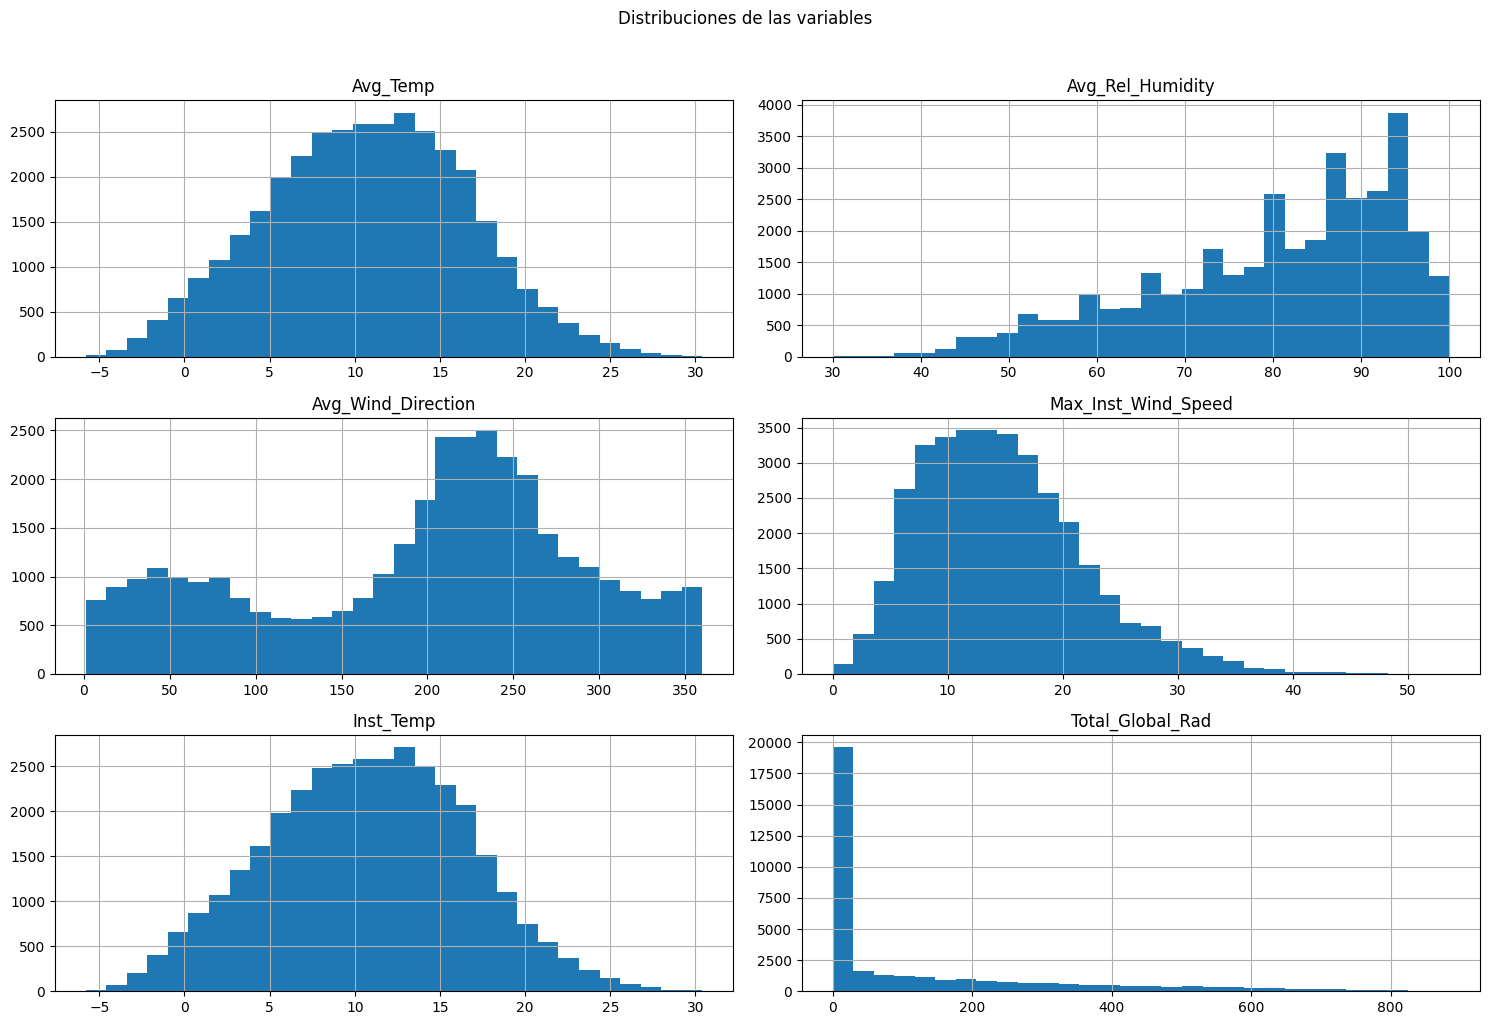

In [ ]:
# Histograms of London weather features

import matplotlib.pyplot as plt
import seaborn as sns

# Histograms
df_weather_london_15m.hist(figsize=(15,10), bins=30)
plt.suptitle("Distribuciones de las variables", y=1.02)
plt.tight_layout()
plt.show()

#### Boxplots

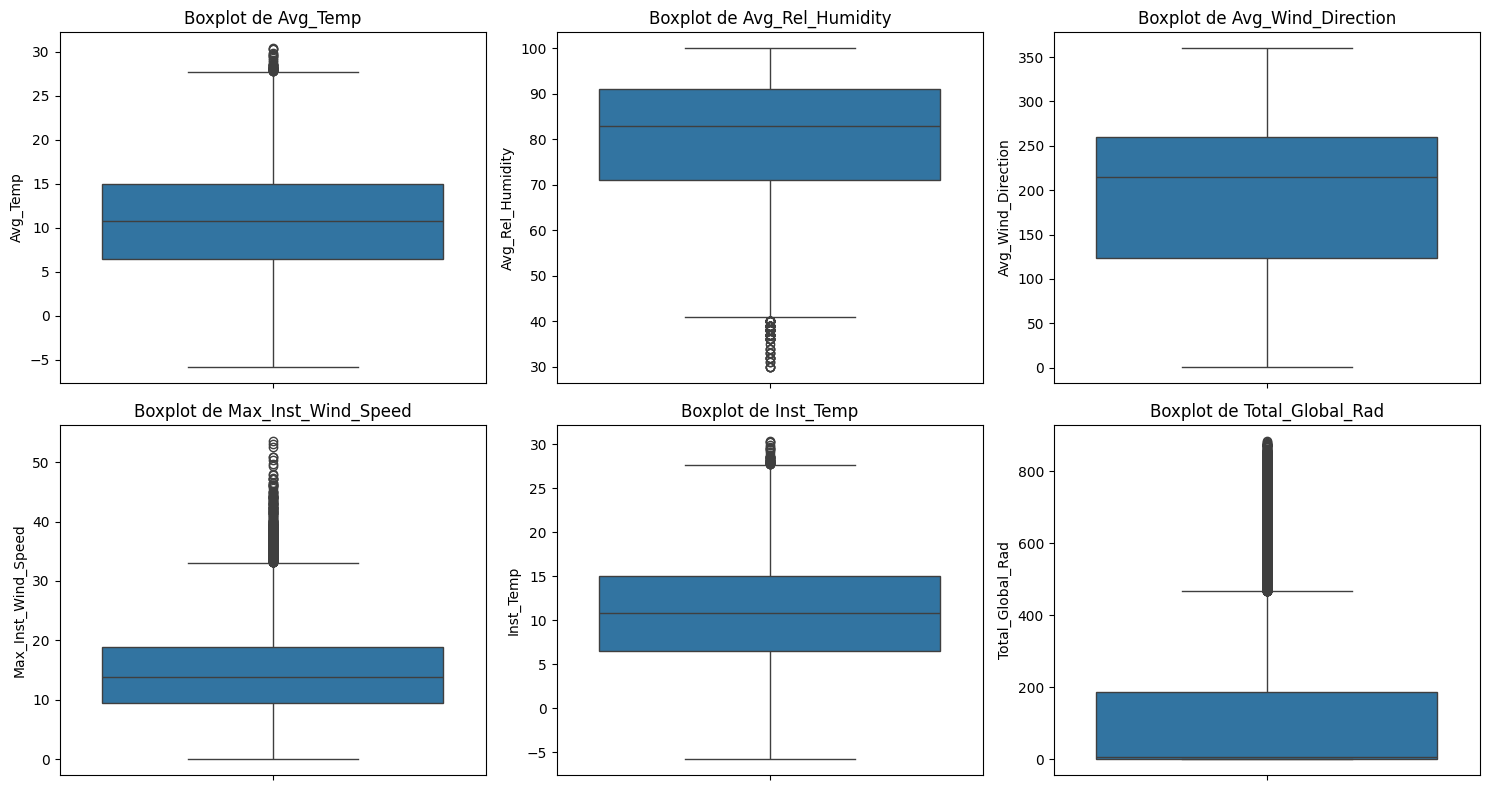

In [ ]:
# Boxplots of London weather features

# Select numeric columns
num_cols = df_weather_london_15m.select_dtypes(include="number").columns

# Always to be 3 columns in plot
n_cols = 3
n_rows = -(-len(num_cols) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df_weather_london_15m[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")

# Removing empty subplots if needed
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Full range evolution

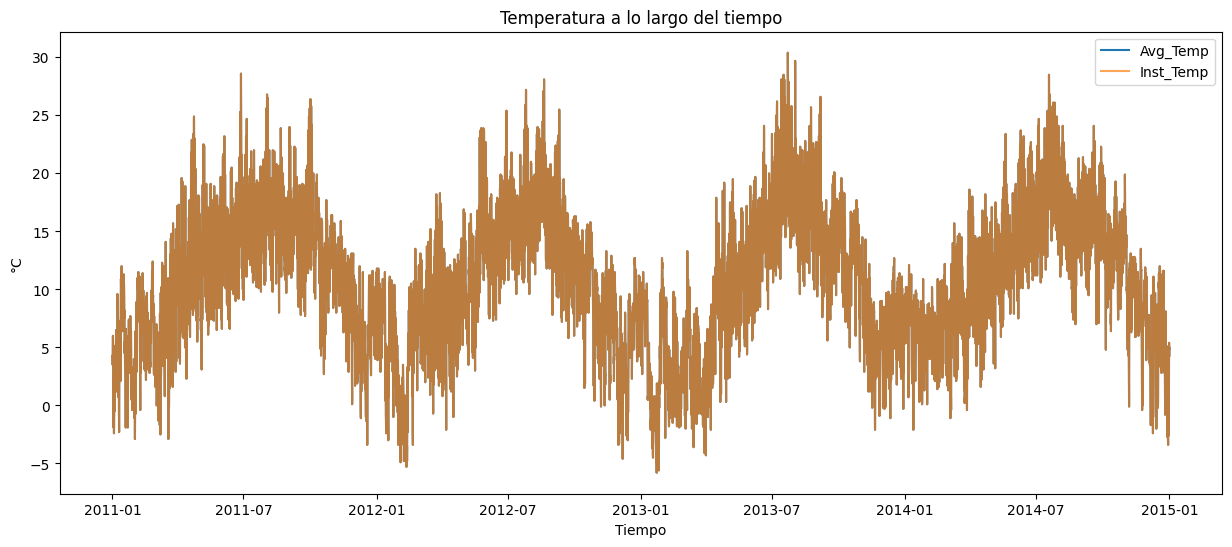

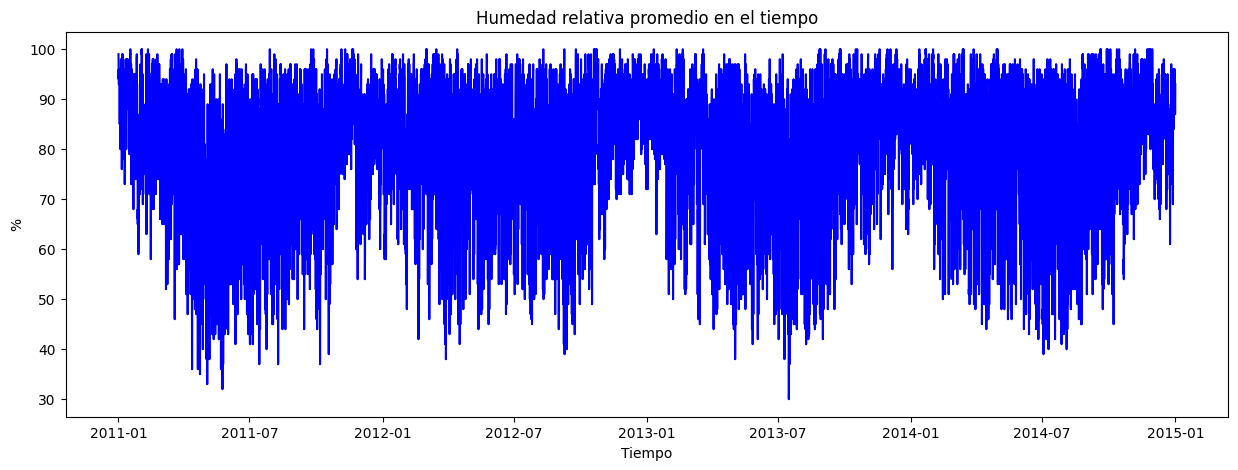

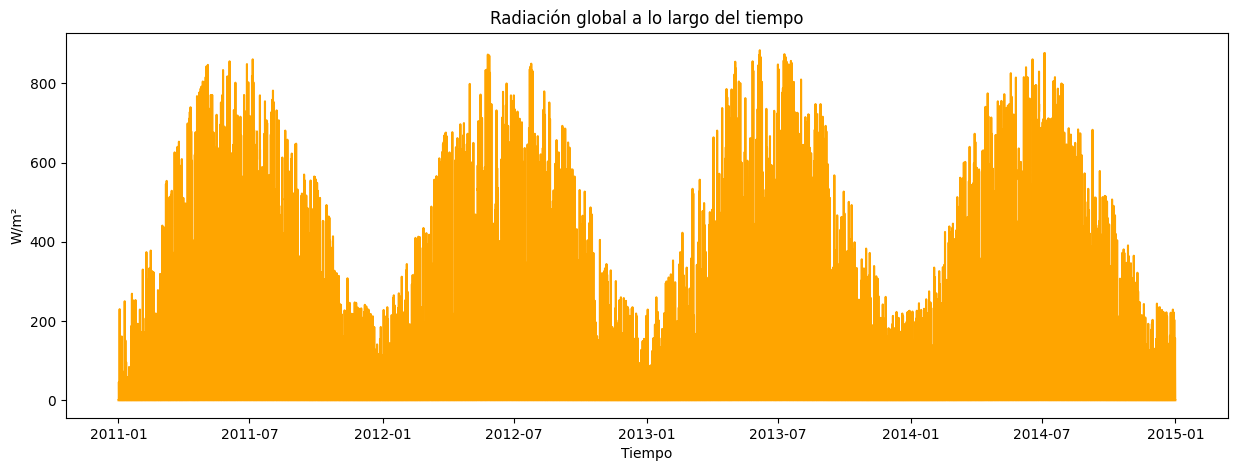

In [ ]:
# Temperatura
plt.figure(figsize=(15,6))
plt.plot(df_weather_london_15m.index, df_weather_london_15m["Avg_Temp"], label="Avg_Temp")
plt.plot(df_weather_london_15m.index, df_weather_london_15m["Inst_Temp"], label="Inst_Temp", alpha=0.7)
plt.legend()
plt.title("Temperatura a lo largo del tiempo")
plt.xlabel("Tiempo")
plt.ylabel("°C")
plt.show()

# Humedad relativa
plt.figure(figsize=(15,5))
plt.plot(df_weather_london_15m.index, df_weather_london_15m["Avg_Rel_Humidity"], color="blue")
plt.title("Humedad relativa promedio en el tiempo")
plt.xlabel("Tiempo")
plt.ylabel("%")
plt.show()

# Radiación global
plt.figure(figsize=(15,5))
plt.plot(df_weather_london_15m.index, df_weather_london_15m["Total_Global_Rad"], color="orange")
plt.title("Radiación global a lo largo del tiempo")
plt.xlabel("Tiempo")
plt.ylabel("W/m²")
plt.show()


#### Correlations

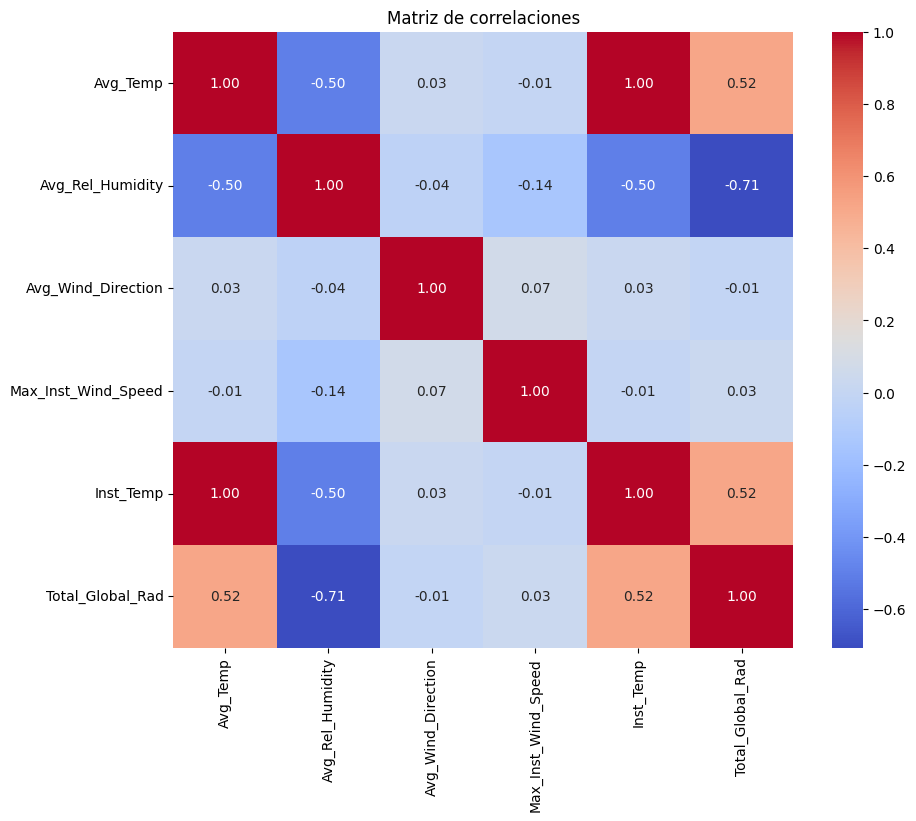

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(df_weather_london_15m.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlaciones")
plt.show()

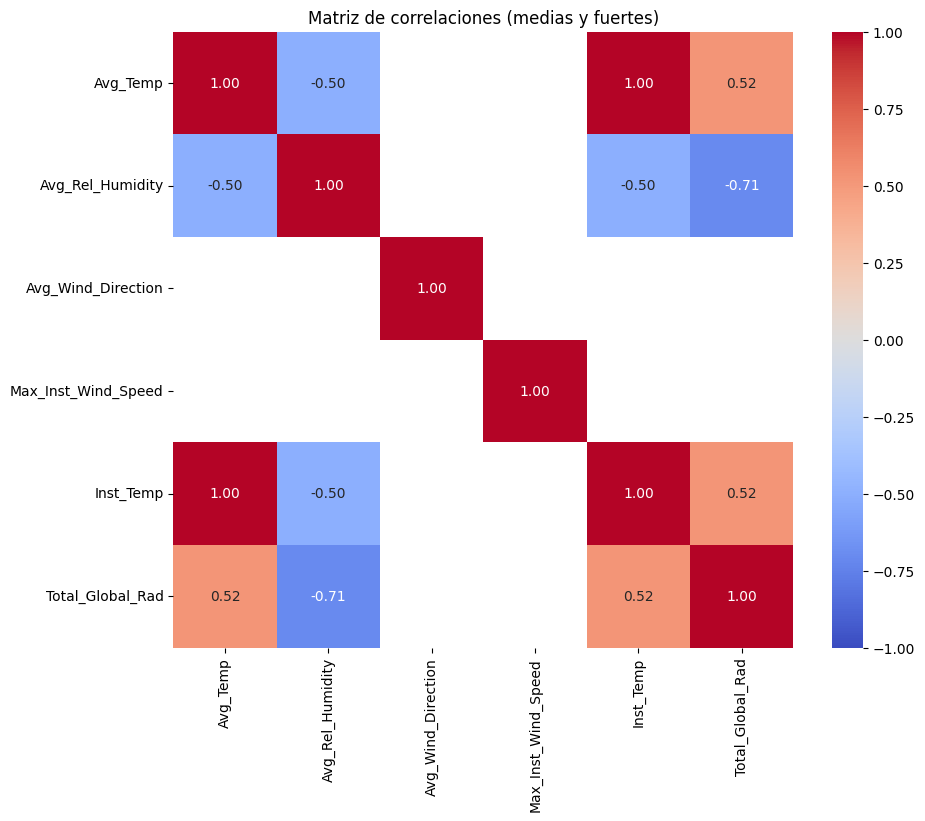

In [ ]:
corr = df_weather_london_15m.corr()

# Filtro: dejar solo medias (>0.3) o fuertes (<-0.3)
mask = (corr.abs() >= 0.3)

# Poner a NaN las correlaciones débiles
filtered_corr = corr.where(mask)

plt.figure(figsize=(10,8))
sns.heatmap(filtered_corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Matriz de correlaciones (medias y fuertes)")
plt.show()

#### Features relations

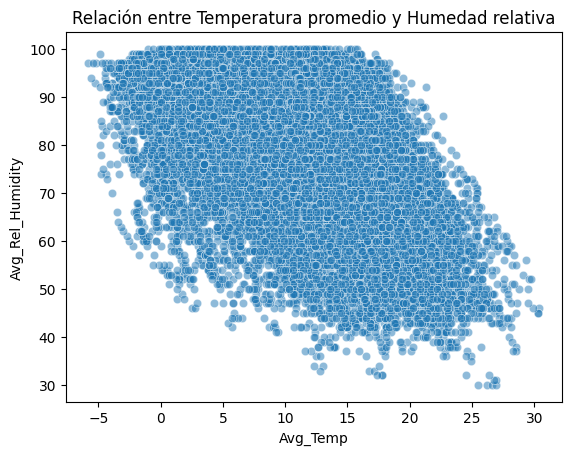

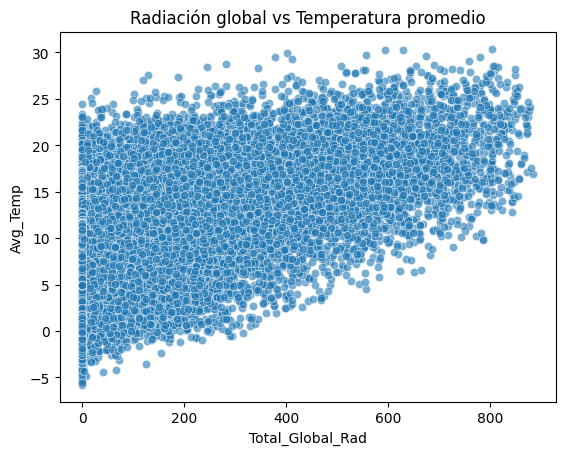

In [ ]:
# Temperatura vs Humedad
sns.scatterplot(x="Avg_Temp", y="Avg_Rel_Humidity", data=df_weather_london_15m, alpha=0.5)
plt.title("Relación entre Temperatura promedio y Humedad relativa")
plt.show()

# Radiación vs Temperatura
sns.scatterplot(x="Total_Global_Rad", y="Avg_Temp", data=df_weather_london_15m, alpha=0.6)
plt.title("Radiación global vs Temperatura promedio")
plt.show()

#### Daily hourly patterns

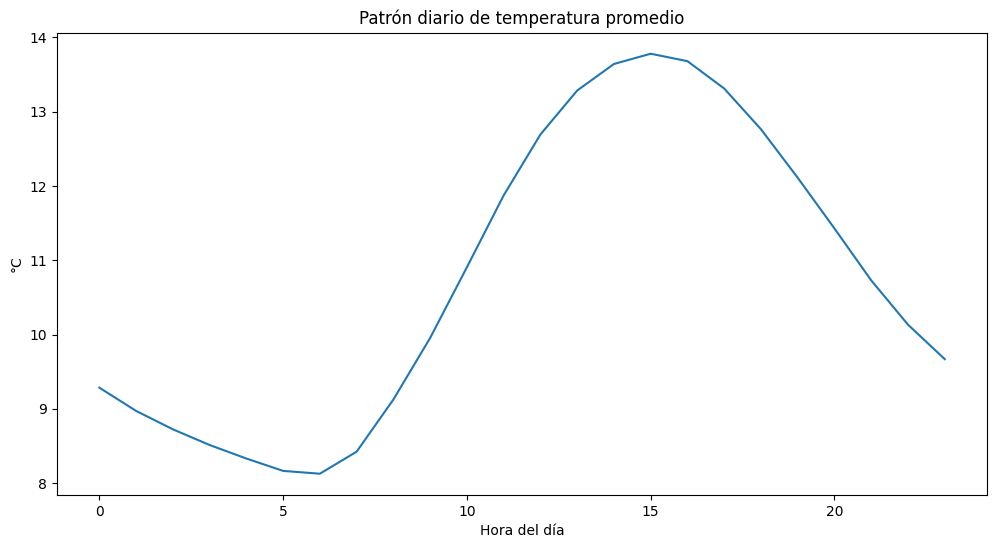

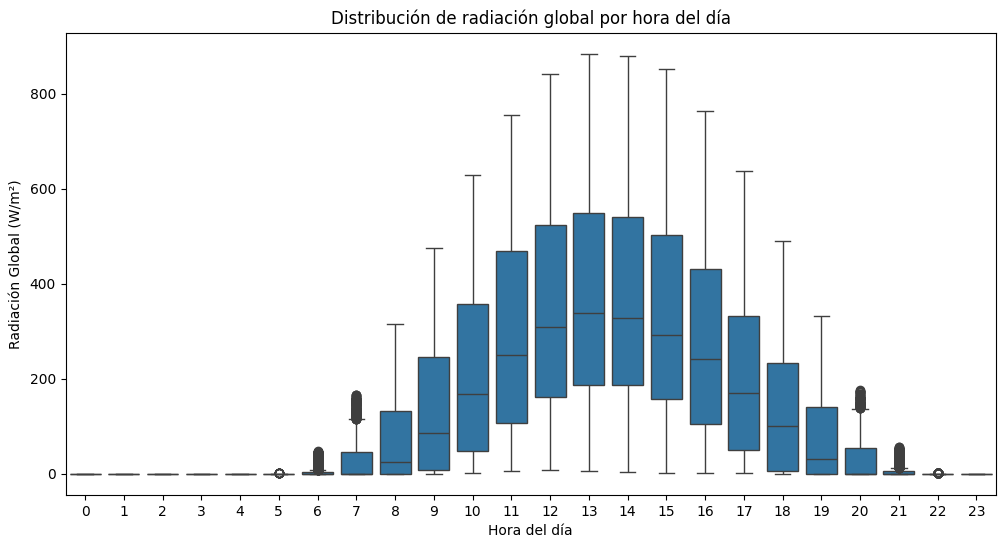

In [ ]:
# Media por hora del día
plt.figure(figsize=(12,6))
sns.lineplot(
    x=df_weather_london_15m.index.hour,
    y=df_weather_london_15m["Avg_Temp"],
    errorbar=None
)
plt.title("Patrón diario de temperatura promedio")
plt.xlabel("Hora del día")
plt.ylabel("°C")
plt.show()

# Boxplot por hora del día
plt.figure(figsize=(12,6))
sns.boxplot(
    x=df_weather_london_15m.index.hour,
    y=df_weather_london_15m["Total_Global_Rad"]
)
plt.title("Distribución de radiación global por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Radiación Global (W/m²)")
plt.show()



## London Feature engineering

### DF_LONDON_CONSUMPTIONS_15M creation

In [ ]:
### Create the column 'total_consumption' as the sum of KWH for the same timestamps
### There are several LCLid meters for each timestamp

df_london_consumptions_15m = (
    df_london_consumptions
    .sort_index()
    .groupby(level=0)["KWH"].sum()       # sumar KWH para timestamps duplicados (hay varios LCLid por timestamp)
    .resample("15min").asfreq()          # Filas cada 15 minutos. Algunas pueden tener NaN
    .interpolate(method="time",
                 limit_direction="both",
                 limit_area="inside")    # interpolación suave sólo en huecos internos
    .to_frame(name="total_consumption")
)

print("Primeras filas de df_london_consumptions_15m:")
display(df_london_consumptions_15m.head())
display(df_london_consumptions_15m.describe())
display(df_london_consumptions_15m.info())


Primeras filas de df_london_consumptions_15m:


total_consumption
DateTime                              
2011-12-06 13:00:00             0.1050
2011-12-06 13:15:00             0.1195
2011-12-06 13:30:00             0.1340
2011-12-06 13:45:00             0.1375
2011-12-06 14:00:00             0.1410

total_consumption
count       78189.000000
mean            6.127843
std             2.688005
min             0.021000
25%             4.212000
50%             5.619000
75%             7.453000
max            42.136000

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78189 entries, 2011-12-06 13:00:00 to 2014-02-28 00:00:00
Freq: 15min
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_consumption  78189 non-null  float64
dtypes: float64(1)
memory usage: 1.2 MB


None

### Create time features columns

['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'] AND ['daylight_fraction', 'solar_hour_sin', 'solar_hour_cos']

In [ ]:
### Create time features

# Creación de columnas ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
df_london_consumptions_15m = add_time_features(df_london_consumptions_15m)

# Definimos la ubicación una sola vez con zona horaria explícita (Londres, UK)
LONDON_LOCATION_INFO = LocationInfo(
    name      = "London",
    region    = "UK",
    timezone  = "Europe/London",
    latitude  = 51.5072,
    longitude = -0.1276
)

# Creación de columnas ['daylight_fraction', 'solar_hour_sin', 'solar_hour_cos']
df_london_consumptions_15m = add_solar_time_features(df_london_consumptions_15m, LONDON_LOCATION_INFO)

df_london_consumptions_15m.head()

total_consumption  hour_sin  hour_cos   dow_sin  dow_cos  \
DateTime                                                                        
2011-12-06 13:00:00             0.1050 -0.258819 -0.965926  0.781831  0.62349   
2011-12-06 13:15:00             0.1195 -0.258819 -0.965926  0.781831  0.62349   
2011-12-06 13:30:00             0.1340 -0.258819 -0.965926  0.781831  0.62349   
2011-12-06 13:45:00             0.1375 -0.258819 -0.965926  0.781831  0.62349   
2011-12-06 14:00:00             0.1410 -0.500000 -0.866025  0.781831  0.62349   

                     daylight_fraction  solar_hour_sin  solar_hour_cos  
DateTime                                                                
2011-12-06 13:00:00           0.901385        0.901385       -0.433019  
2011-12-06 13:15:00           0.854819        0.854819       -0.518927  
2011-12-06 13:30:00           0.800090        0.800090       -0.599880  
2011-12-06 13:45:00           0.737722        0.737722       -0.675105  
2011-12-06 14:00:00           0.668310        0.668310       -0.743883

### Create column working_day
- 1 is working day
- 0 is non working day



In [ ]:
# 1) Crear máscara de serie con los fines de semana
weekends_mask = df_london_consumptions_15m.index.dayofweek >= 5

# Paso 2: Crear la máscara para días festivos
# Compara el índice de consumo normalizado con la lista de festivos
holidays_mask = df_london_consumptions_15m.index.normalize().isin(df_holidays['date'])

# Paso 3: Combinar fines de semana y festivos (días NO laborables)
non_working_days = weekends_mask | holidays_mask

# Paso 4: Crear la columna 'working_day' (1 para laborable, 0 para no laborable)
df_london_consumptions_15m['working_day'] = (~non_working_days).astype(int)

# --- Verificaciones y uso posterior (sin cambios) ---
print("Distribución de días laborables vs no laborables:")
print(df_london_consumptions_15m['working_day'].value_counts() / (24 * 4))

print(f"Registros que coinciden con festivos: {holidays_mask.sum()}")
print(f"Registros que son fines de semana: {weekends_mask.sum()}")

Distribución de días laborables vs no laborables:
working_day
1    582.46875
0    232.00000
Name: count, dtype: float64
Registros que coinciden con festivos: 0
Registros que son fines de semana: 22272


## London feature engineering EDA

#### Visual exploration of London total_consumption_15m

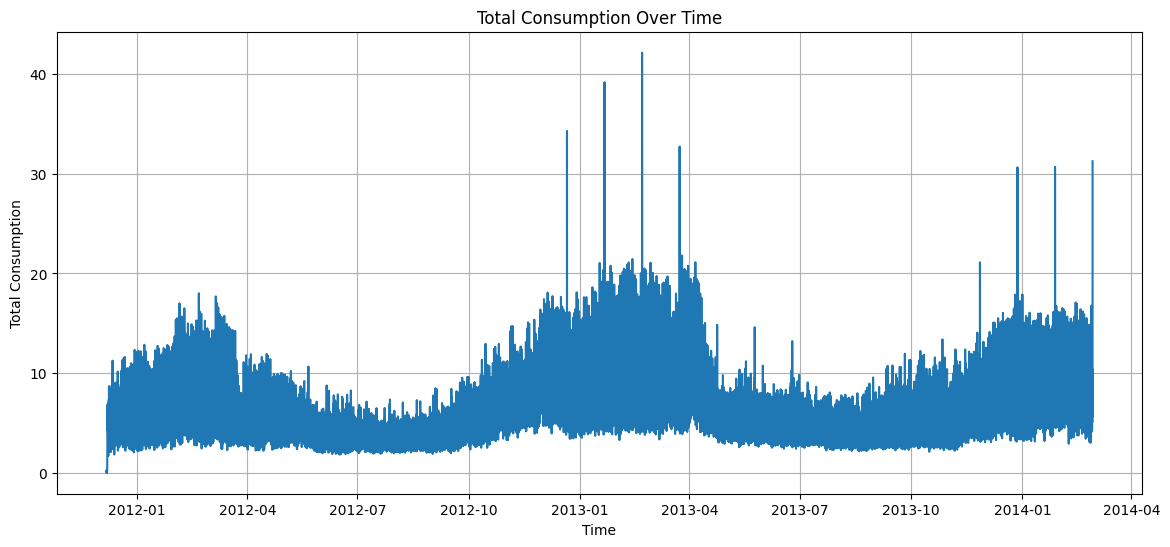

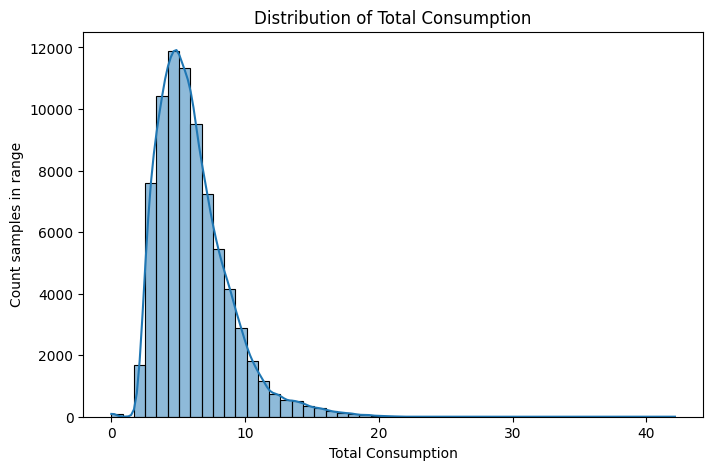

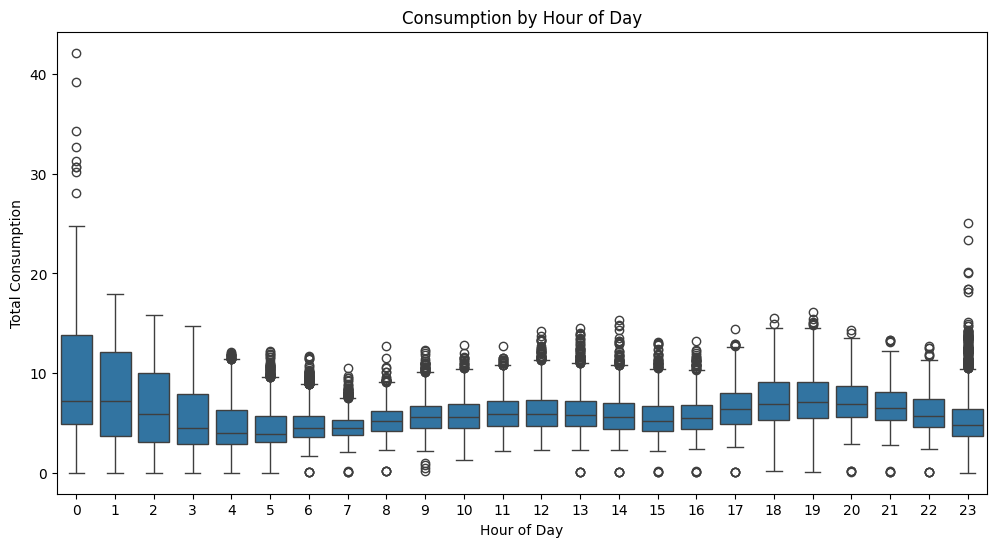

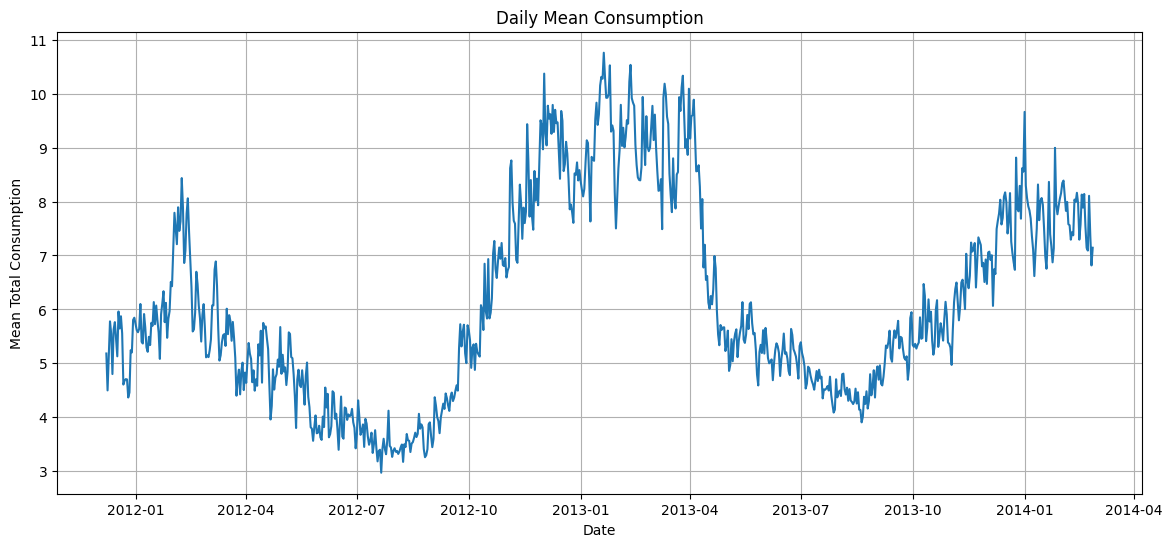

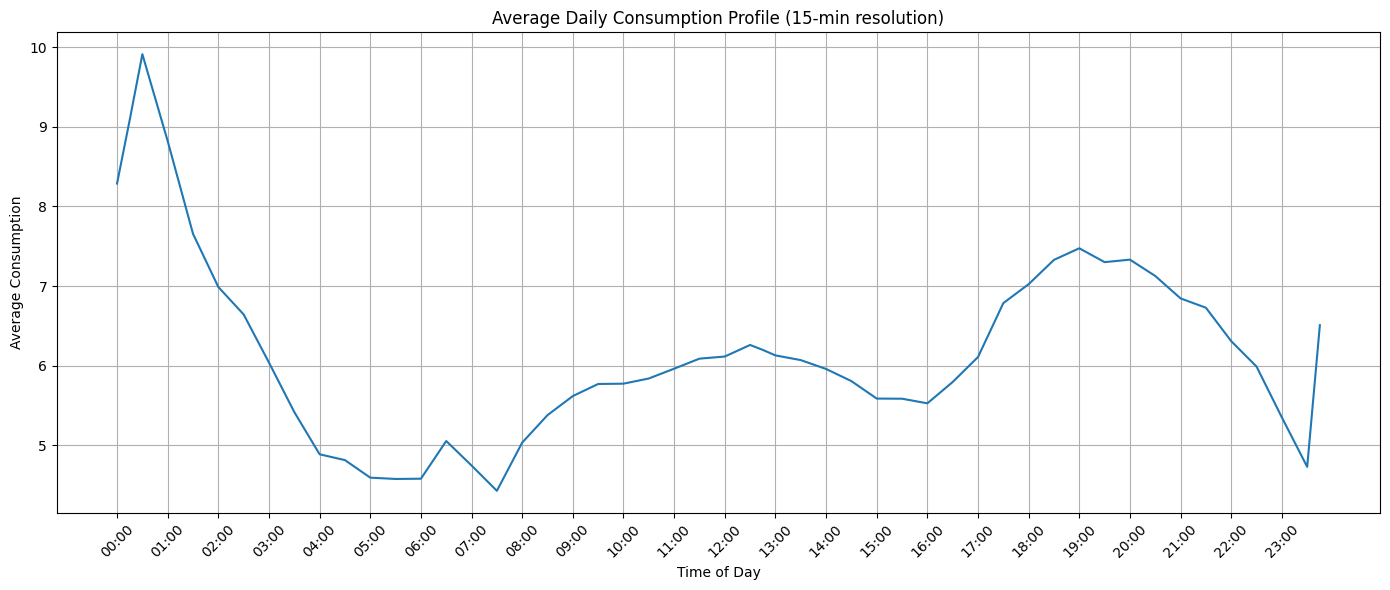

In [ ]:
# 4. Visual exploration
plt.figure(figsize=(14, 6))
plt.plot(df_london_consumptions_15m.index, df_london_consumptions_15m["total_consumption"])
plt.title("Total Consumption Over Time")
plt.xlabel("Time")
plt.ylabel("Total Consumption")
plt.grid(True)
plt.show()

# Histogram
plt.figure(figsize=(8, 5))
sns.histplot(df_london_consumptions_15m["total_consumption"], bins=50, kde=True)
plt.title("Distribution of Total Consumption")
plt.xlabel("Total Consumption")
plt.ylabel("Count samples in range")
plt.show()

# Boxplot by hour of day
df_london_consumptions_15m["hour"] = df_london_consumptions_15m.index.hour
plt.figure(figsize=(12, 6))
sns.boxplot(x="hour", y="total_consumption", data=df_london_consumptions_15m)
plt.title("Consumption by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Consumption")
plt.show()

# 5. Aggregations
# Daily mean consumption
daily_mean = (
    df_london_consumptions_15m
    .resample("D")["total_consumption"].mean()
    .iloc[2:-2]  # exclude last N days (there are extraordinary large values those days)
)

plt.figure(figsize=(14, 6))
plt.plot(daily_mean.index, daily_mean.values)
plt.title("Daily Mean Consumption")
plt.xlabel("Date")
plt.ylabel("Mean Total Consumption")
plt.grid(True)
plt.show()

# Average daily profile (mean 15-min pattern)
# .time extracts only the time of day part (HH:MM:SS) from each timestamp, ignoring the date
plt.figure(figsize=(14, 6))
avg_daily_profile = df_london_consumptions_15m.groupby(df_london_consumptions_15m.index.time)["total_consumption"].mean()
time_labels = [t.strftime("%H:%M") for t in avg_daily_profile.index]
plt.plot(time_labels, avg_daily_profile.values)
# Show fewer labels on the X axis (every 4th tick = 1 hour so data is 15min spaced)
step = 4
plt.xticks(time_labels[::step], rotation=45)
plt.title("Average Daily Consumption Profile (15-min resolution)")
plt.xlabel("Time of Day")
plt.ylabel("Average Consumption")
plt.grid(True)
plt.tight_layout()
plt.show()


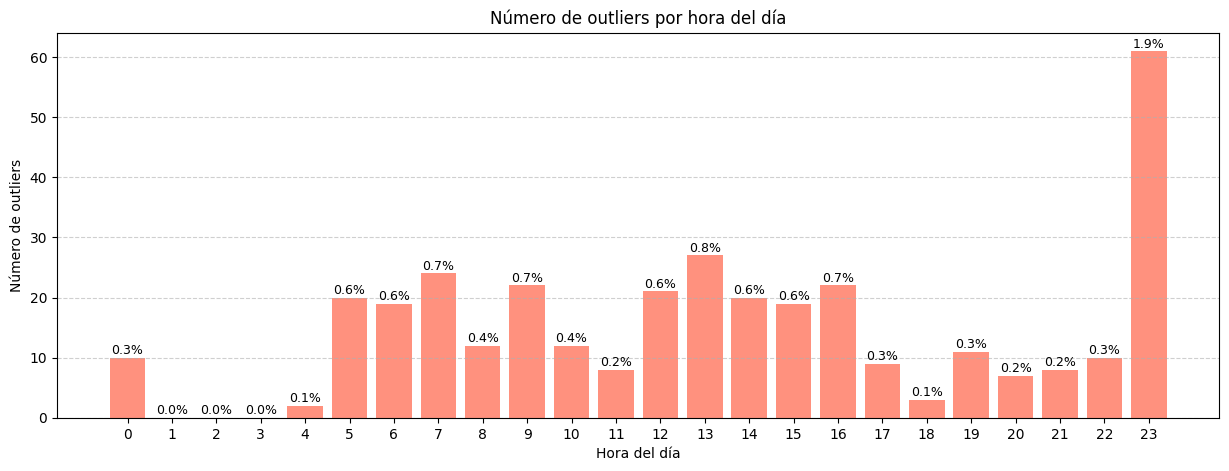

In [ ]:
# Plot the scatter of total_consumption by hour of day

# Extraer la hora del día directamente del índice
df_london_consumptions_15m['hora'] = df_london_consumptions_15m.index.hour

# Eliminar columnas de cálculos previos si ya existen
cols_a_borrar = ['media_hora', 'std_hora', 'zscore_hora', 'es_outlier']
df_london_consumptions_15m = df_london_consumptions_15m.drop(columns=[c for c in cols_a_borrar if c in df_london_consumptions_15m.columns])

# Calcular media y desviación estándar por hora
stats_por_hora = (
    df_london_consumptions_15m
    .groupby('hora')['total_consumption']
    .agg(media_hora='mean', std_hora='std')
)

# Unir estadísticas por hora al dataframe original
# En lugar de un merge, usamos transform() que es más eficiente para esta tarea
df_london_consumptions_15m['media_hora'] = df_london_consumptions_15m.groupby('hora')['total_consumption'].transform('mean')
df_london_consumptions_15m['std_hora'] = df_london_consumptions_15m.groupby('hora')['total_consumption'].transform('std')

# Calcular z-score por hora
df_london_consumptions_15m['zscore_hora'] = (
    (df_london_consumptions_15m['total_consumption'] - df_london_consumptions_15m['media_hora'])
    / df_london_consumptions_15m['std_hora']
)

# Definir umbral para outliers
umbral = 3
df_london_consumptions_15m['es_outlier'] = df_london_consumptions_15m['zscore_hora'].abs() > umbral

# Filtrar solo outliers
outliers = df_london_consumptions_15m[df_london_consumptions_15m['es_outlier']].copy()

# ==============================
# 2) Histograma de outliers por hora
# ==============================

# Número y porcentaje de outliers por hora
# Crear un rango completo de horas (0–23)
rango_horas = range(24)

# Reindexar para asegurar que todas las horas estén presentes
outliers_por_hora = outliers.groupby('hora').size().reindex(rango_horas, fill_value=0)
total_por_hora = df_london_consumptions_15m.groupby('hora').size().reindex(rango_horas, fill_value=0)

# Evitar divisiones por cero y NaN
porcentaje_por_hora = (outliers_por_hora / total_por_hora.replace(0, np.nan)) * 100
porcentaje_por_hora = porcentaje_por_hora.fillna(0)

# Histograma
plt.figure(figsize=(15,5))
plt.bar(outliers_por_hora.index, outliers_por_hora.values, color='tomato', alpha=0.7)
plt.title('Número de outliers por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Número de outliers')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetas con porcentaje
for idx, val_pct in zip(outliers_por_hora.index, porcentaje_por_hora.values):
    plt.text(idx, outliers_por_hora.loc[idx] + 0.1, f"{val_pct:.1f}%",
             ha='center', va='bottom', fontsize=9)

plt.show()

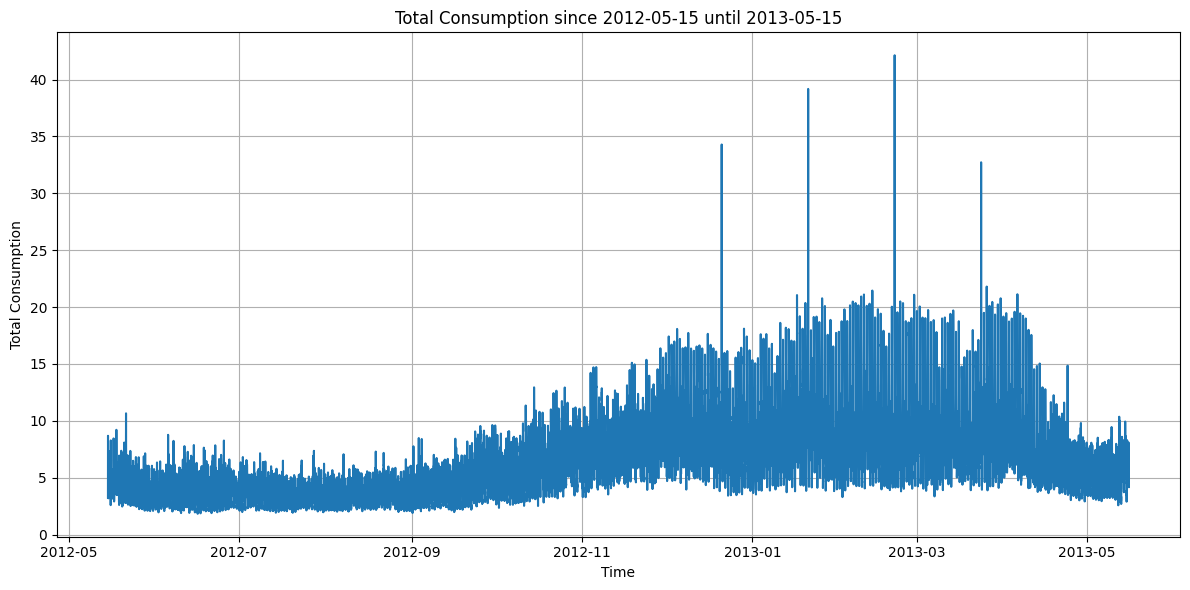

In [ ]:
# Plot slice of total_consumption serie
date_start_plot = '2012-05-15' # None # '2023-06-01'
date_end_plot = '2013-05-15' # None

#data_to_plot = df_consumptions_15m.loc["2023-01-01 00:00:00":, "total_consumption"]
data_to_plot = df_london_consumptions_15m.loc[date_start_plot : date_end_plot, "total_consumption"]

plt.figure(figsize=(12, 6))
plt.plot(data_to_plot.index, data_to_plot.values)

title = "Total Consumption"
if date_start_plot:
  title += " since " + date_start_plot
if date_end_plot:
  title += " until " + date_end_plot
plt.title(title)
plt.xlabel("Time")
plt.ylabel("Total Consumption")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Plot one month consumption evolution

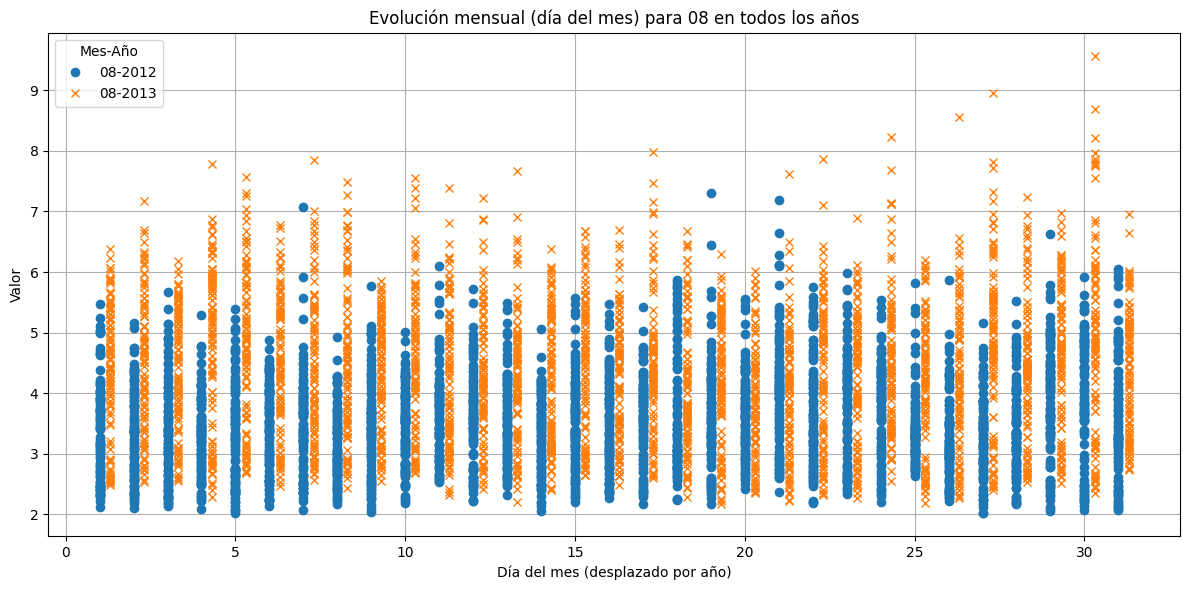

In [ ]:
plot_month_consumption_evolution(df_london_consumptions_15m["total_consumption"], month=8)


#### Comparing Loureiro and London average daily profile

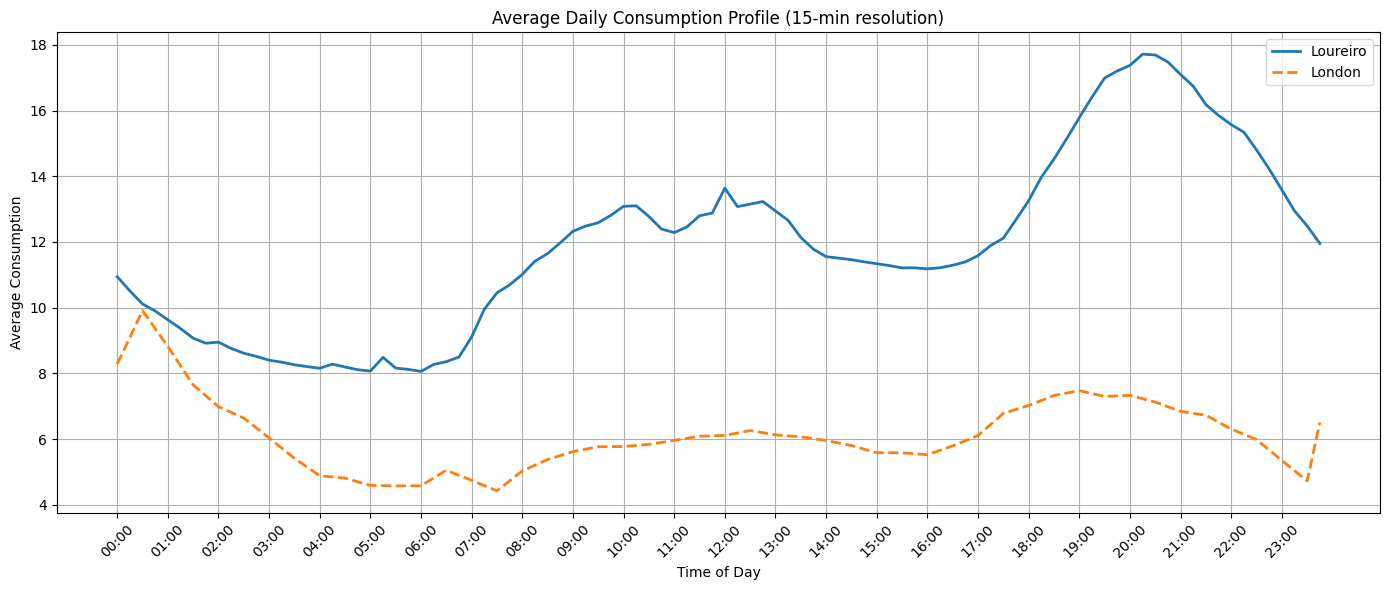

In [ ]:
# Comparison of average daily profiles (mean 15-min pattern) before and after cut
plt.figure(figsize=(14, 6))

# Compute the average daily profile
loureiro_avg_daily_profile = df_consumptions_15m.groupby(df_consumptions_15m.index.time)["total_consumption"].mean()
london_avg_daily_profile = df_london_consumptions_15m.groupby(df_london_consumptions_15m.index.time)["total_consumption"].mean()

# Time labels (HH:MM) extracted from the index of Loureiro profile
time_labels = [t.strftime("%H:%M") for t in loureiro_avg_daily_profile.index]

# Plot both curves
plt.plot(time_labels, loureiro_avg_daily_profile.values, label="Loureiro", linewidth=2)
plt.plot(time_labels, london_avg_daily_profile.values, label="London", linewidth=2, linestyle="--")

# Show fewer labels on the X axis (every 4th tick = 1 hour since data is 15-min spaced)
step = 4
plt.xticks(time_labels[::step], rotation=45)

# Titles and legend
plt.title("Average Daily Consumption Profile (15-min resolution)")
plt.xlabel("Time of Day")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Plot the outliers of total_consumption at a selected hour

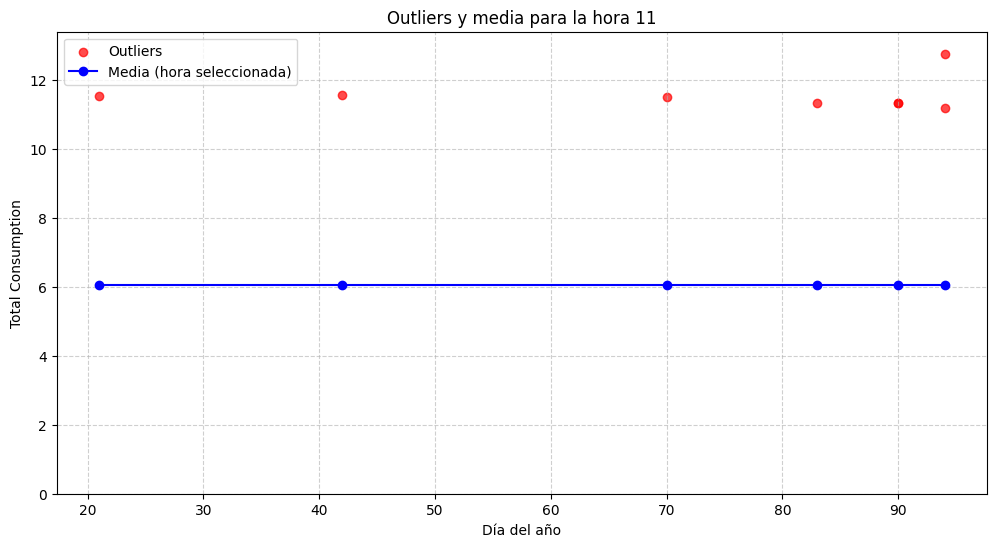

In [ ]:
# Plot the outliers of total_consumption at a selected hour

hour_to_show_outliers = 11

# Filtrar outliers de la hora elegida
outliers_hora = outliers[outliers['hora'] == hour_to_show_outliers].copy()
outliers_hora['dia_del_ano'] = outliers_hora.index.dayofyear

# Obtener máximo valor de esa hora (solo entre outliers)
max_val_hora = outliers_hora['total_consumption'].max()

# --- Obtener la media de esos días para la hora seleccionada ---
# Filtramos en df_consumptions_15m las filas de la hora y días con outliers
medias_hora = df_london_consumptions_15m[
    (df_london_consumptions_15m['hora'] == hour_to_show_outliers) &
    (df_london_consumptions_15m.index.dayofyear.isin(outliers_hora['dia_del_ano']))
].copy()

# Promediamos por día
medias_hora['dia_del_ano'] = medias_hora.index.dayofyear
media_por_dia = medias_hora.groupby('dia_del_ano')['media_hora'].mean()

# ==============================
# Graficar
# ==============================
plt.figure(figsize=(12, 6))

# Outliers
plt.scatter(
    outliers_hora['dia_del_ano'],
    outliers_hora['total_consumption'],
    color='red',
    alpha=0.7,
    label='Outliers'
)

# Media de esos días
plt.plot(
    media_por_dia.index,
    media_por_dia.values,
    color='blue',
    marker='o',
    linestyle='-',
    label='Media (hora seleccionada)'
)

plt.title(f'Outliers y media para la hora {hour_to_show_outliers}')
plt.xlabel('Día del año')
plt.ylabel('Total Consumption')
plt.ylim(0, max_val_hora * 1.05)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


#### Visual exploration of solar time features: daylight_fraction, solar_hour_...

Generate a comparative plot of the evolution of chosen feature during the first N days of each month, from start_month to end_month, using the data from the DataFrame df_london_consumptions_15m.

Procesado: Jun 2013 - 96 registros
Procesado: Jul 2013 - 96 registros
Procesado: Ago 2013 - 96 registros
Procesado: Sep 2013 - 96 registros
Procesado: Oct 2013 - 96 registros
Procesado: Nov 2013 - 96 registros
Procesado: Dic 2013 - 96 registros
Procesado: Ene 2014 - 96 registros
Procesado: Feb 2014 - 96 registros

Comparación de los primeros 1 días de cada mes
Período: 2013-06 a 2014-05
Procesado: Jun 2013 - 96 registros
Procesado: Jul 2013 - 96 registros
Procesado: Ago 2013 - 96 registros
Procesado: Sep 2013 - 96 registros
Procesado: Oct 2013 - 96 registros
Procesado: Nov 2013 - 96 registros
Procesado: Dic 2013 - 96 registros
Procesado: Ene 2014 - 96 registros
Procesado: Feb 2014 - 96 registros

Comparación de los primeros 1 días de cada mes
Período: 2013-06 a 2014-05
Se observa cómo las curvas se estrechan hacia el invierno (menos horas de luz) y se ensanchan hacia la primavera.


(<Figure size 1500x800 with 1 Axes>,
 <Axes: title={'center': 'Comparación de daylight_fraction\nPrimeros 1 días de cada mes'}, xlabel='Horas desde el inicio del período (0 = 00:00 del día 1)', ylabel='Fracción de luz diurna (0–1)'>)

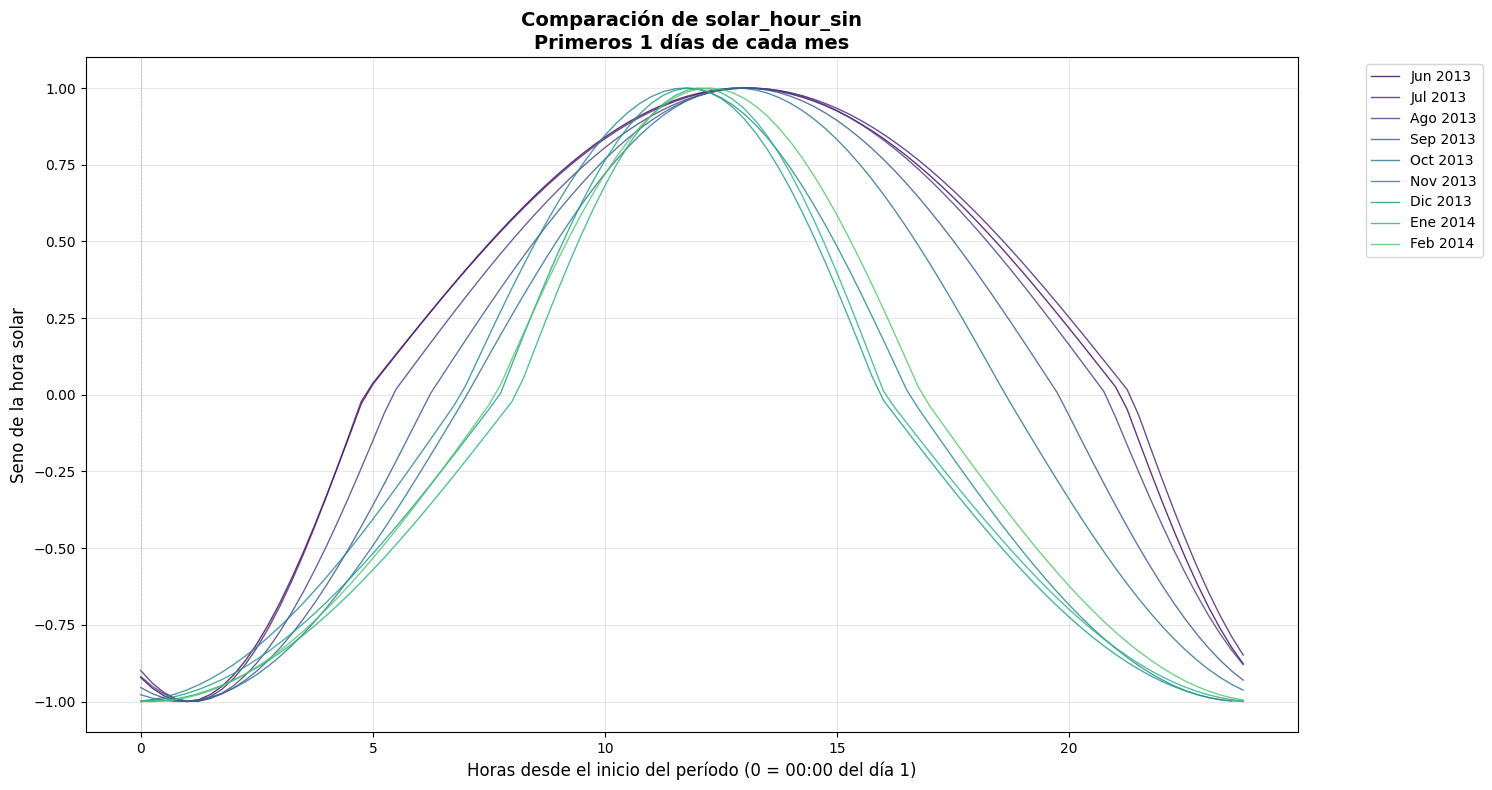

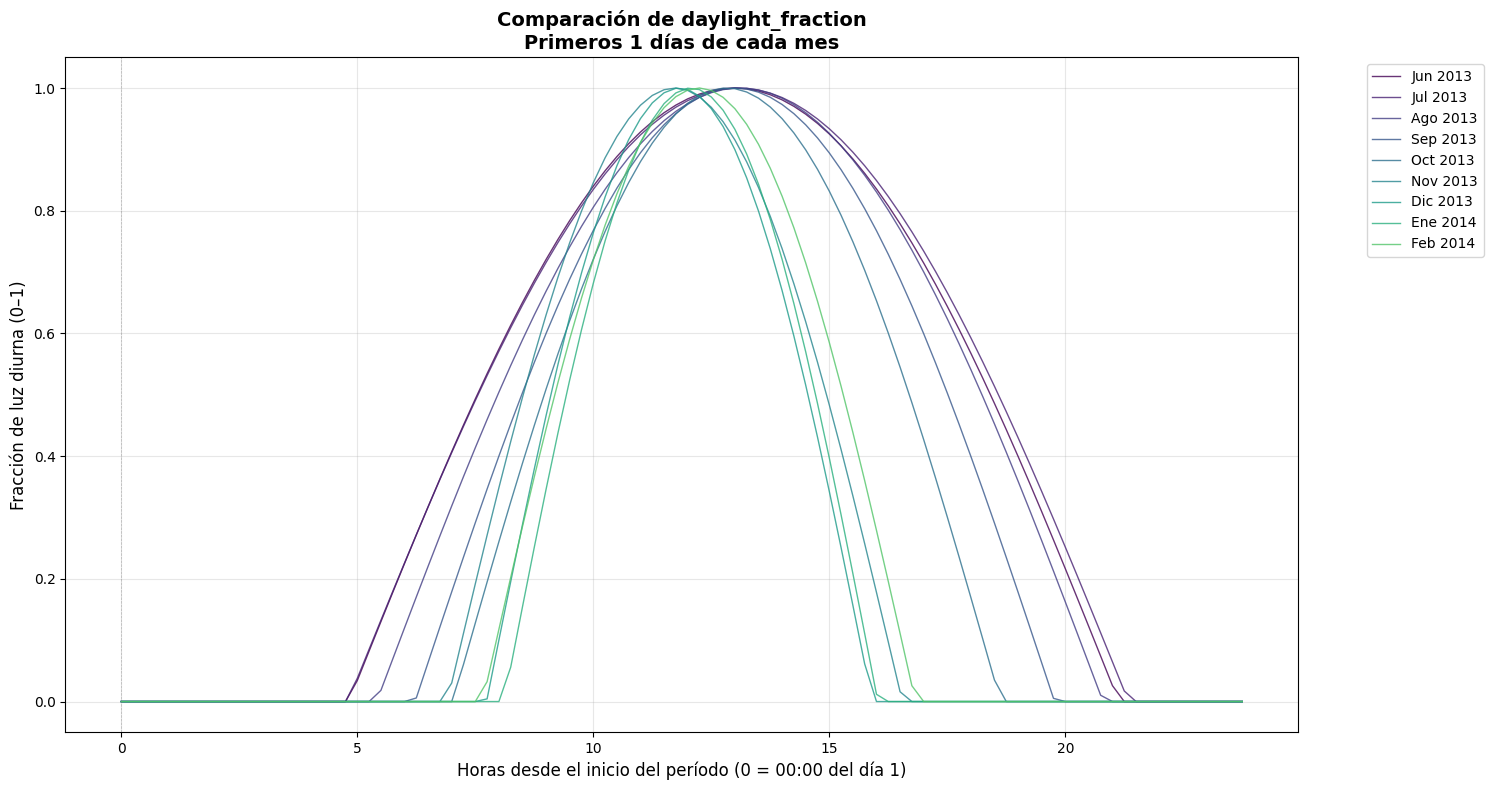

In [ ]:
plot_feature_by_month(df_london_consumptions_15m, 'solar_hour_sin', 1, '2013-06', '2014-05')

plot_feature_by_month(df_london_consumptions_15m, 'daylight_fraction', 1, '2013-06', '2014-05')


## DF_TRANSFER_VAL building

In [ ]:
df_transfer_val = create_df_model_data(df_london_consumptions_15m, df_weather_london_15m)

print("\ndf_transfer_val DataFrame succesfully created")


df_transfer_val DataFrame succesfully created


## Random Forest on Tier1 49 features R² 0.8506

Forecasting over **London** data...

Métricas aplicando el modelo Random Forest Tier1:  
>  MSE:  1.0848  
  RMSE: 1.0415  
  MAPE: 12.08%  
  **R²:   0.8506**  

---

Forecasting over **Loureiro** data...

Métricas aplicando el modelo Random Forest Tier1:  
>  MSE:  0.2641  
  RMSE: 0.5139  
  MAPE: 2044746.20%  
  **R²:   0.9868**  

In [ ]:
rf_model_path = TRAINED_MODELS_BASE_PATH + "random_forest_tier1_49features.pkl"

# Cargar el modelo
rf_tier1_model = joblib.load(rf_model_path)

print("\nForecasting over London data...")
X = df_transfer_val[rf_tier1_model.feature_names_in_]
y_pred = rf_tier1_model.predict(X)
_ = print_metrics(df_transfer_val["total_consumption"], y_pred, "Random Forest Tier1")

print("\nForecasting over Loureiro data...")
X = df_model_data[rf_tier1_model.feature_names_in_]
y_pred = rf_tier1_model.predict(X)
_ = print_metrics(df_model_data["total_consumption"], y_pred, "Random Forest Tier1")



Forecasting over London data...

Métricas aplicando el modelo Random Forest Tier1:
  MSE:  1.0848
  RMSE: 1.0415
  MAPE: 12.08%
  R²:   0.8506

Forecasting over Loureiro data...

Métricas aplicando el modelo Random Forest Tier1:
  MSE:  0.2641
  RMSE: 0.5139
  MAPE: 2044746.20%
  R²:   0.9868



Loading Random Forest model...

Forecasting over London data...


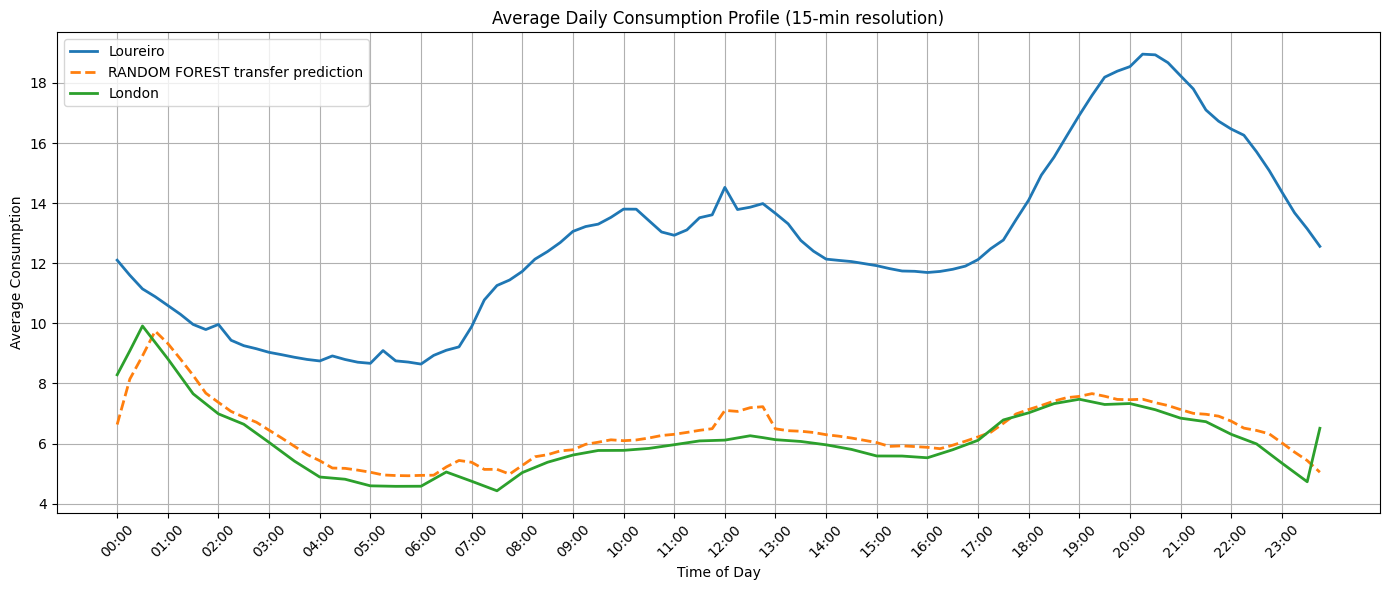

In [ ]:
# Comparison of average daily profiles (mean 15-min pattern) Loureiro, London and Random Forest predictions

# Compute Random Forest predictions
print("\nLoading Random Forest model...")
rf_model_path = TRAINED_MODELS_BASE_PATH + "random_forest_tier1_49features.pkl"
rf_tier1_model = joblib.load(rf_model_path)
print("\nForecasting over London data...")
X = df_transfer_val[rf_tier1_model.feature_names_in_]
y_pred_rf_tier1 = rf_tier1_model.predict(X)

# Serie con índice datetime
y_pred_rf_tier1_s = pd.Series(np.asarray(y_pred_rf_tier1).ravel(), index=df_transfer_val.index, name="y_pred_rf_tier1")

# Random Forest Average profile
london_pred_avg_daily_profile_RF = y_pred_rf_tier1_s.groupby(y_pred_rf_tier1_s.index.time).mean()

# Loureiro and Longon average profiles
loureiro_avg_daily_profile = df_consumptions_15m.groupby(df_consumptions_15m.index.time)["total_consumption"].mean()
london_avg_daily_profile = df_london_consumptions_15m.groupby(df_london_consumptions_15m.index.time)["total_consumption"].mean()

# Time labels (HH:MM) extracted from the index of Loureiro profile
time_labels = [t.strftime("%H:%M") for t in loureiro_avg_daily_profile.index]

# Create figure
plt.figure(figsize=(14, 6))

# Plot both curves
plt.plot(time_labels, loureiro_avg_daily_profile.values, label="Loureiro", linewidth=2)
plt.plot(time_labels, london_pred_avg_daily_profile_RF.values, label="RANDOM FOREST transfer prediction", linewidth=2, linestyle="--")
plt.plot(time_labels, london_avg_daily_profile.values, label="London", linewidth=2)

# Show fewer labels on the X axis (every 4th tick = 1 hour since data is 15-min spaced)
step = 4
plt.xticks(time_labels[::step], rotation=45)

# Titles and legend
plt.title("Average Daily Consumption Profile (15-min resolution)")
plt.xlabel("Time of Day")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Redes Neuronales

### Dense NN 32 - R² 0.6719
Métricas aplicando el modelo DenseNN Tier1 on London:  
  MSE:  2.3814  
  **RMSE: 1.5432**  
  MAPE: 25.79%  
  **R²:   0.6719**  

In [ ]:
### Medir la transferibilidad de DenseNN de Loureiro a London

base_path_name = TRAINED_MODELS_BASE_PATH + 'DenseNN_SEED_43_R2_0.8815'

# --- 1) Cargar modelo y escaladores ---
import joblib

print(f"\nLoading models {base_path_name}...")
denseNN_model = keras.models.load_model(f"{base_path_name}.keras")
denseNN_scaler_X = joblib.load(f"{base_path_name}_scaler_X.pkl")
denseNN_scaler_y = joblib.load(f"{base_path_name}_scaler_y.pkl")

X = df_transfer_val[denseNN_scaler_X.feature_names_in_].copy()
# Rellenar NaN con la media de cada columna
X.fillna(X.mean(), inplace=True)
# Extraer y directamente
y = df_transfer_val["total_consumption"].copy()

# Ahora df_transfer_val ya no es necesario
df_transfer_val.to_csv("df_transfer_val.csv", index_label="datetime")
del df_transfer_val
import gc; gc.collect()

X_scaled = denseNN_scaler_X.transform(X)

print("\nPrediciendo valores de Y...")
y_pred_scaled = denseNN_model.predict(X_scaled)

print("\nRevirtiendo escalado de Y...")
y_pred = denseNN_scaler_y.inverse_transform(y_pred_scaled)


# Liberar lo que ya no hace falta
del X, X_scaled, y_pred_scaled

# Asegurar tipos ligeros y 1D
y = np.asarray(y, dtype=np.float32).ravel()
y_pred = np.asarray(y_pred, dtype=np.float32).ravel()

gc.collect()

print("\nCalculando métricas...")
_ = print_metrics(y, y_pred, "DenseNN Tier1 on London")


df_transfer_val = pd.read_csv("df_transfer_val.csv", parse_dates=["datetime"], index_col="datetime")



Loading models /content/drive/MyDrive/Global Project Notebooks/trained_models/DenseNN_SEED_43_R2_0.8815...

Prediciendo valores de Y...
2401/2401 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Revirtiendo escalado de Y...

Calculando métricas...

Métricas aplicando el modelo DenseNN Tier1 on London:
  MSE:  2.3814
  RMSE: 1.5432
  MAPE: 25.79%
  R²:   0.6719


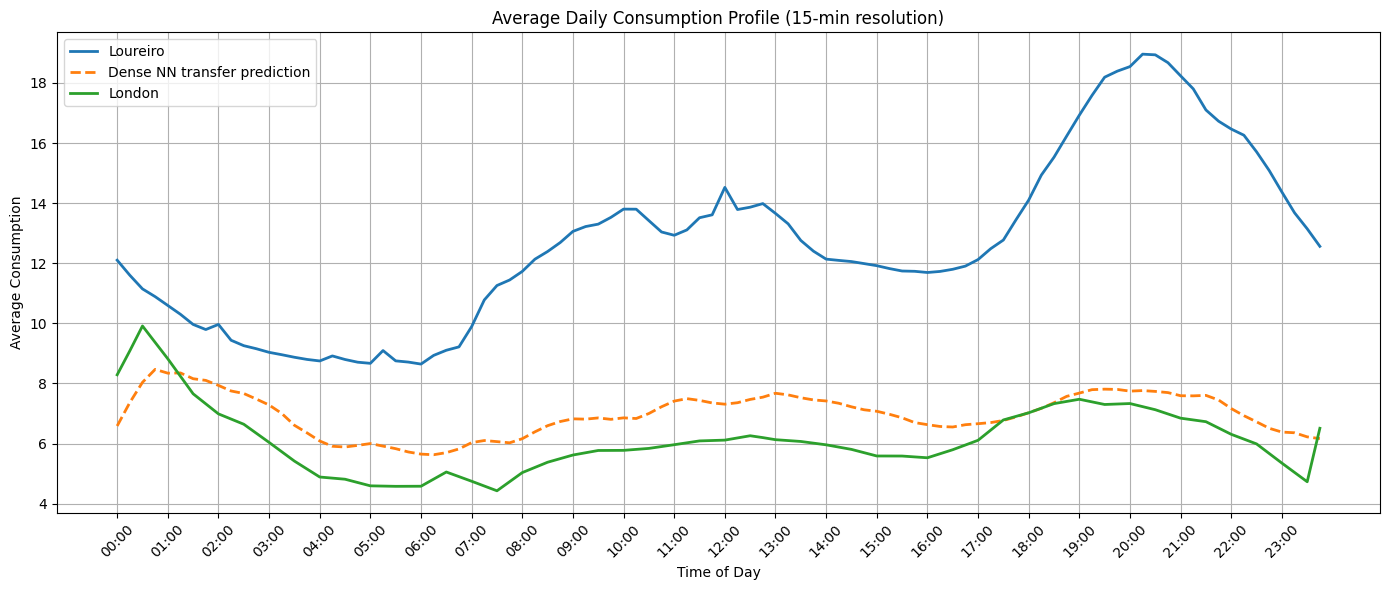

In [ ]:
# Comparison of average daily profiles (mean 15-min pattern) Loureiro, London and DenseNN predictions
plt.figure(figsize=(14, 6))

# Compute the average daily profile
loureiro_avg_daily_profile = df_consumptions_15m.groupby(df_consumptions_15m.index.time)["total_consumption"].mean()
london_avg_daily_profile = df_london_consumptions_15m.groupby(df_london_consumptions_15m.index.time)["total_consumption"].mean()

# 1) Crear una Serie/DataFrame de predicciones con el índice temporal correcto
#    y_pred = (n_pred, 1) -> aplanamos
y_pred_flat = np.asarray(y_pred).ravel()

#    Las predicciones empiezan en el índice LOOK_BACK de la serie original
pred_index = df_transfer_val.index

# Serie con índice datetime
y_pred_s = pd.Series(y_pred_flat, index=pred_index, name="y_pred")

# 2) Perfil diario medio (agrupando por hora:minuto)
#    Opción A: usando .index.time (devuelve objetos datetime.time)
london_pred_avg_daily_profile_DENSE = y_pred_s.groupby(y_pred_s.index.time).mean()

# Time labels (HH:MM) extracted from the index of Loureiro profile
time_labels = [t.strftime("%H:%M") for t in loureiro_avg_daily_profile.index]

# Plot both curves
plt.plot(time_labels, loureiro_avg_daily_profile.values, label="Loureiro", linewidth=2)
plt.plot(time_labels, london_pred_avg_daily_profile_DENSE.values, label="Dense NN transfer prediction", linewidth=2, linestyle="--")
plt.plot(time_labels, london_avg_daily_profile.values, label="London", linewidth=2)

# Show fewer labels on the X axis (every 4th tick = 1 hour since data is 15-min spaced)
step = 4
plt.xticks(time_labels[::step], rotation=45)

# Titles and legend
plt.title("Average Daily Consumption Profile (15-min resolution)")
plt.xlabel("Time of Day")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### LSTM con ventana de 14 días y series contexto SOLAR_hour_... R² 0.8841

El modelo en su dataset validation original alcanzaba un R² 0.9174

Métricas aplicando el modelo Loureiro LSTM + solar_hour applied to Lodon:  
  MSE:  0.8471  
  **RMSE: 0.9204**  
  MAPE: 10.22%  
  **R²:   0.8841**

In [ ]:
### Set configuration variables
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# =========================
# Parámetros
# =========================
N_DAYS_WINDOW = 14                # p.ej., 2 semanas de historial
LOOK_BACK = 96 * N_DAYS_WINDOW    # 96 muestras/día
TRAIN_RATIO = 0.8                 # 80% train, 20% test (cronológico)
VAL_RATIO_WITHIN_TRAIN = 0.1      # 10% del train para validación
BATCH_SIZE = 64
EPOCHS = 30
SEED = 43
tf.random.set_seed(SEED)

base_path_name = TRAINED_MODELS_BASE_PATH + 'LSTM_14d_solar_hour_SEED_43'

ctxt_features = ['solar_hour_sin', 'solar_hour_cos']


In [ ]:
### Recupera el model LSTM 14d + series solar_hour... y comprueba transferibilidad

# --- 1) Cargar modelo y escaladores ---
import joblib

print(f"\nLoading models {base_path_name}...")
model = keras.models.load_model(f"{base_path_name}.keras")
scaler_ctx = joblib.load(f"{base_path_name}_scaler_X.pkl")
scaler_y   = joblib.load(f"{base_path_name}_scaler_y.pkl")

# --- 2) Escalar con los escaladores cargados ---
print(f"\nScaling X and y series...")
y_series_raw = df_transfer_val["total_consumption"].values.reshape(-1, 1)
Xctx_raw     = df_transfer_val[ctxt_features].values

y_series_scaled    = scaler_y.transform(y_series_raw)          # (n, 1)
Xctx_series_scaled = scaler_ctx.transform(Xctx_raw)            # (n, len(ctxt_features))

# Features por timestep
X_series_scaled = np.hstack([y_series_scaled, Xctx_series_scaled])  # (n, 1+len(ctxt_features))

# --- 3) Dataset ventana->siguiente paso (idéntico al make_dataset para entrenar el modelo) ---
print("Building dataset from series...")
def make_dataset(X_scaled, y_scaled, look_back, batch_size, shuffle):
    X_data = X_scaled[:-1]
    y_targ = y_scaled[look_back:]
    ds = keras.utils.timeseries_dataset_from_array(
        data=X_data,
        targets=y_targ,
        sequence_length=look_back,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=batch_size,
        shuffle=shuffle,
    )
    return ds

transfer_ds = make_dataset(
    X_series_scaled,
    y_series_scaled,
    look_back=LOOK_BACK,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# --- 5) Predecir y desescalar ---
print("Forecasting...")
y_pred_scaled = model.predict(transfer_ds, verbose=0)

print("Reversing scaling forcasted serie...")
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# --- 6) Evaluar resultados y mostrar métricas
_ = print_metrics(y_series_raw[LOOK_BACK:], y_pred, "Loureiro LSTM + solar_hour applied to Lodon")


Loading models /content/drive/MyDrive/Global Project Notebooks/trained_models/LSTM_14d_solar_hour_SEED_43...

Scaling X and y series...
Building dataset from series...
Forecasting...
Reversing scaling forcasted serie...

Métricas aplicando el modelo Loureiro LSTM + solar_hour applied to Lodon:
  MSE:  0.8471
  RMSE: 0.9204
  MAPE: 10.22%
  R²:   0.8841


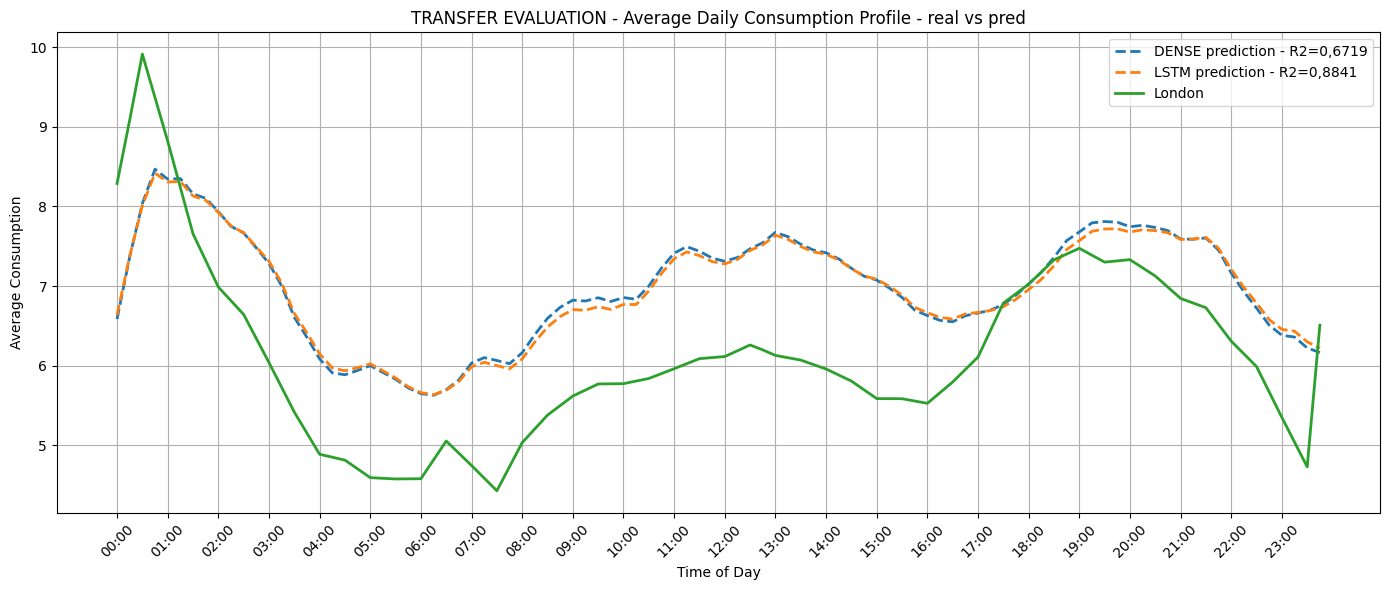

In [ ]:
# Comparison of average daily profiles (mean 15-min pattern) Loureiro, London and London predictions
plt.figure(figsize=(14, 6))

# Compute the average daily profile
loureiro_avg_daily_profile = df_consumptions_15m.groupby(df_consumptions_15m.index.time)["total_consumption"].mean()
london_avg_daily_profile = df_london_consumptions_15m.groupby(df_london_consumptions_15m.index.time)["total_consumption"].mean()

# 1) Crear una Serie/DataFrame de predicciones con el índice temporal correcto
#    y_pred = (n_pred, 1) -> aplanamos
y_pred_flat = np.asarray(y_pred).ravel()

#    Las predicciones empiezan en el índice LOOK_BACK de la serie original
pred_index = df_transfer_val.index[LOOK_BACK: LOOK_BACK + len(y_pred_flat)]

#    Por si acaso, recortamos a la mínima longitud común
n = min(len(y_pred_flat), len(pred_index))
y_pred_flat = y_pred_flat[:n]
pred_index  = pred_index[:n]

# Serie con índice datetime
y_pred_s = pd.Series(y_pred_flat, index=pred_index, name="y_pred")

# 2) Perfil diario medio (agrupando por hora:minuto)
#    Opción A: usando .index.time (devuelve objetos datetime.time)
london_pred_avg_daily_profile_LSTM = y_pred_s.groupby(y_pred_s.index.time).mean()

# Time labels (HH:MM) extracted from the index of Loureiro profile
time_labels = [t.strftime("%H:%M") for t in loureiro_avg_daily_profile.index]

# Plot both curves
#plt.plot(time_labels, loureiro_avg_daily_profile.values, label="Loureiro", linewidth=2)
plt.plot(time_labels, london_pred_avg_daily_profile_DENSE.values, label="DENSE prediction - R2=0,6719", linewidth=2, linestyle="--")
plt.plot(time_labels, london_pred_avg_daily_profile_LSTM.values, label="LSTM prediction - R2=0,8841", linewidth=2, linestyle="--")
plt.plot(time_labels, london_avg_daily_profile.values, label="London", linewidth=2)

# Show fewer labels on the X axis (every 4th tick = 1 hour since data is 15-min spaced)
step = 4
plt.xticks(time_labels[::step], rotation=45)

# Titles and legend
plt.title("TRANSFER EVALUATION - Average Daily Consumption Profile - real vs pred")
plt.xlabel("Time of Day")
plt.ylabel("Average Consumption")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot neural models

Model: "DENSE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 64)             │         3,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_prediction (Dense)       │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,633 (22.00 KB)

 Trainable params: 5,633 (22.00 KB)

 Non-trainable params: 0 (0.00 B)

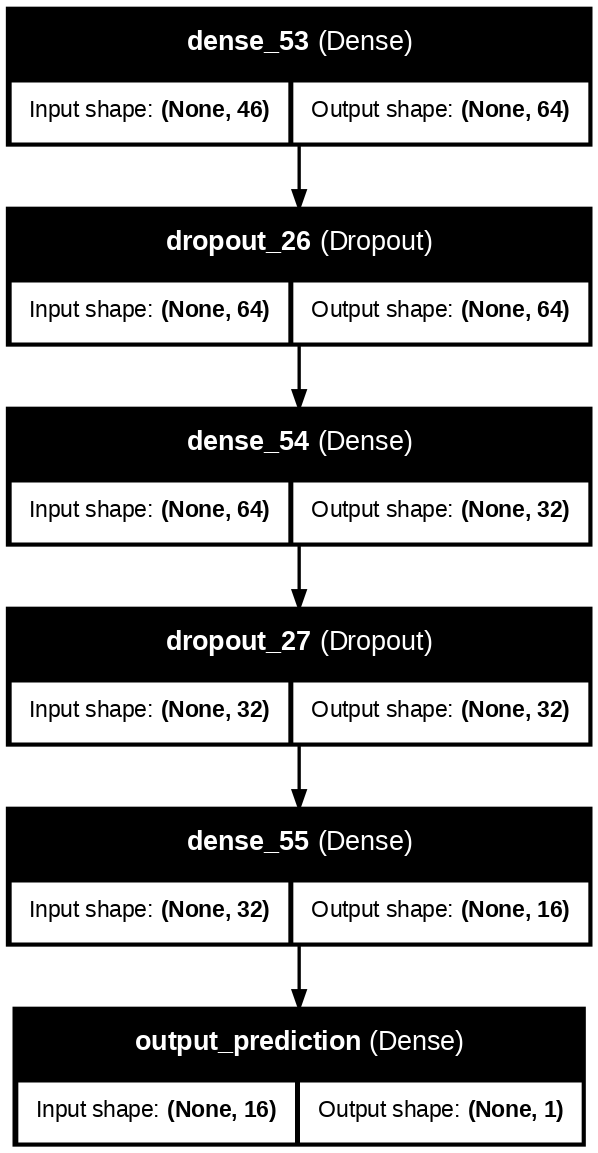

In [ ]:
### Plot DENSE neural model

# --- instalar dependencias (en caso de que falle pydot) ---
!pip install pydot graphviz

# --- importar keras ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# --- definir parámetros ---
WINDOW = 96 * 14
X_ctx_dim = 3

# --- definir el modelo exactamente como en tu código ---
model = keras.Sequential([
    keras.Input(shape=(46,), name="Input_tier1_features"),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, name="output_prediction")
], name="DENSE"
)

# --- mostrar resumen en texto ---
model.summary()

# --- generar diagrama ---
plot_model(
    model,
    to_file="modelo.png",
    show_shapes=True,         # muestra las dimensiones de entrada/salida
    show_layer_names=True,    # muestra el nombre de cada capa
    rankdir="TB",             # Top -> Bottom layout
    dpi=120
)

# --- mostrar en colab ---
from IPython.display import Image
Image(filename="modelo.png")


Model: "LSTM_series_ctxt"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_64 (LSTM)                  │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_prediction (Dense)       │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

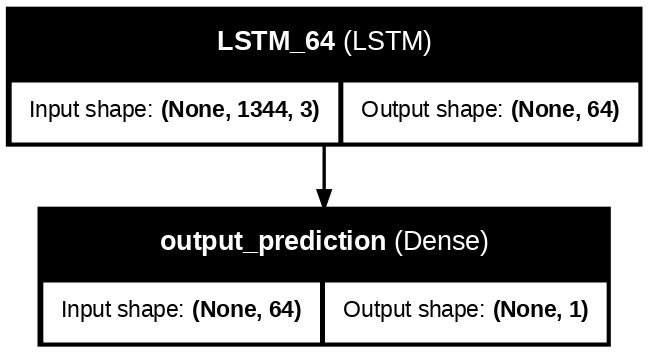

In [ ]:
### Plot LSTM 3 series neural model

# --- instalar dependencias (en caso de que falle pydot) ---
!pip install pydot graphviz

# --- importar keras ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# --- definir parámetros ---
WINDOW = 96 * 14
X_ctx_dim = 2

# --- definir el modelo exactamente como en tu código ---
model = keras.Sequential([
    layers.Input(shape=(LOOK_BACK, 1 + X_ctx_dim), name="input_sequences"),
    layers.LSTM(64, name="LSTM_64"),
    layers.Dense(1, name="output_prediction"),
], name="LSTM_series_ctxt")

# --- mostrar resumen en texto ---
model.summary()

# --- generar diagrama ---
plot_model(
    model,
    to_file="modelo.png",
    show_shapes=True,         # muestra las dimensiones de entrada/salida
    show_layer_names=True,    # muestra el nombre de cada capa
    rankdir="TB",             # Top -> Bottom layout
    dpi=120
)

# --- mostrar en colab ---
from IPython.display import Image
Image(filename="modelo.png")


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 48, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_64 (LSTM)      │ (None, 64)        │     16,896 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_0.2         │ (None, 64)        │          0 │ LSTM_64[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctx_in (InputLayer) │ (None, 10)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate         │ (None, 74)        │          0 │ Dropout_0.2[0][0… │
│ (Concatenate)       │                   │            │ ctx_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_64_relu       │ (None, 64)        │      4,800 │ Concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_32_relu       │ (None, 32)        │      2,080 │ Dense_64_relu[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         33 │ Dense_32_relu[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,809 (93.00 KB)

 Trainable params: 23,809 (93.00 KB)

 Non-trainable params: 0 (0.00 B)

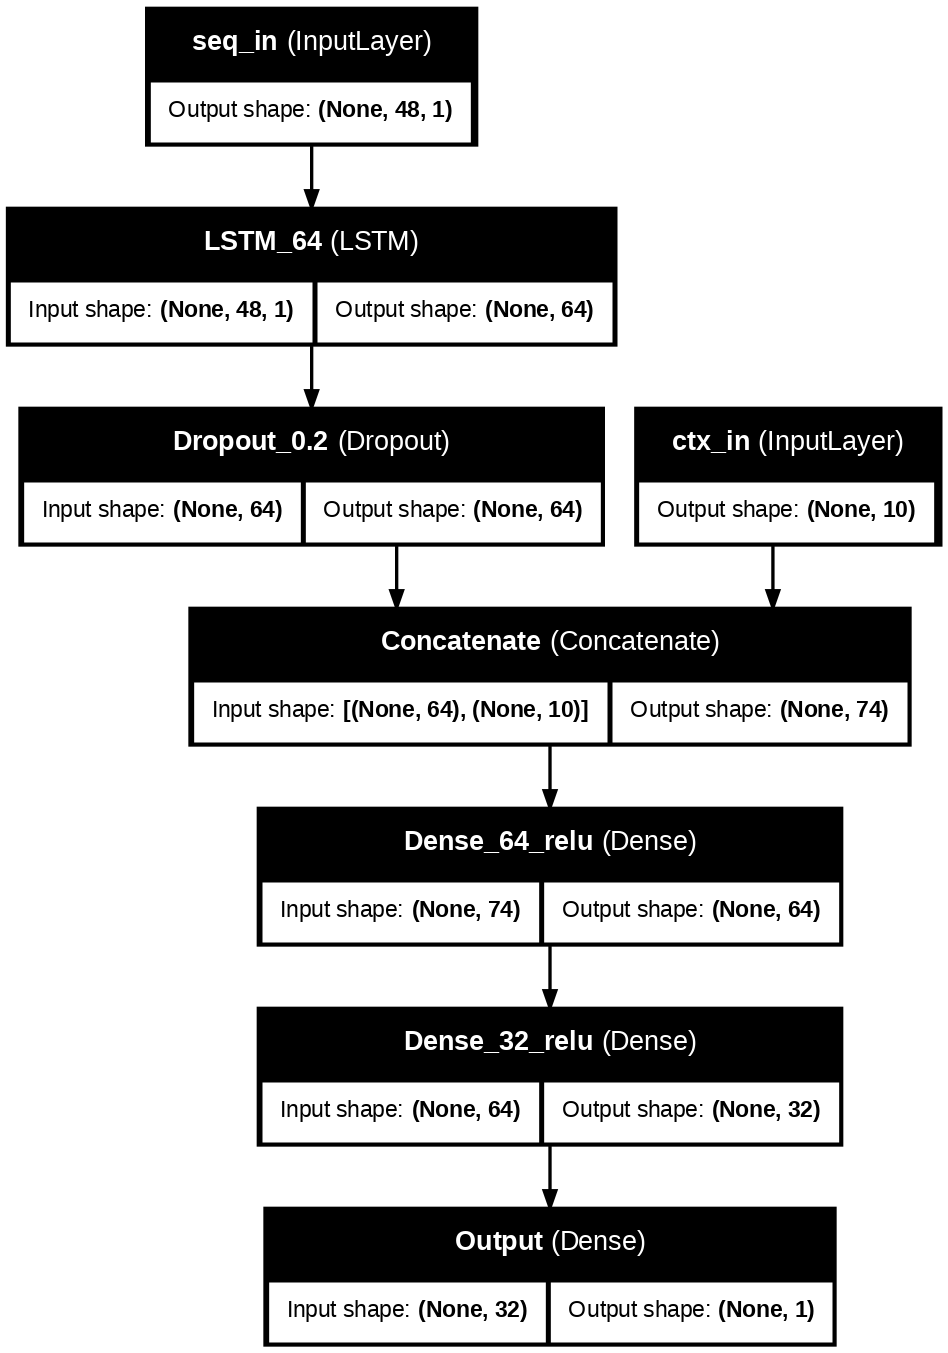

In [ ]:
### Plot LSTM neural model

# --- instalar dependencias (en caso de que falle pydot) ---
!pip install pydot graphviz

# --- importar keras ---
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

# --- definir parámetros ---
WINDOW = 48
X_ctx_dim = 10

# --- definir el modelo exactamente como en tu código ---
seq_in = keras.Input(shape=(WINDOW, 1), name="seq_in")
ctx_in = keras.Input(shape=(X_ctx_dim,), name="ctx_in")

h = keras.layers.LSTM(64, return_sequences=False, name="LSTM_64")(seq_in)
h = keras.layers.Dropout(0.2, name="Dropout_0.2")(h)

z = keras.layers.Concatenate(name="Concatenate")([h, ctx_in])
z = keras.layers.Dense(64, activation="relu", name="Dense_64_relu")(z)
z = keras.layers.Dense(32, activation="relu", name="Dense_32_relu")(z)
out = keras.layers.Dense(1, name="Output")(z)

model = keras.Model([seq_in, ctx_in], out)

# --- mostrar resumen en texto ---
model.summary()

# --- generar diagrama ---
plot_model(
    model,
    to_file="modelo.png",
    show_shapes=True,         # muestra las dimensiones de entrada/salida
    show_layer_names=True,    # muestra el nombre de cada capa
    rankdir="TB",             # Top -> Bottom layout
    dpi=120
)

# --- mostrar en colab ---
from IPython.display import Image
Image(filename="modelo.png")


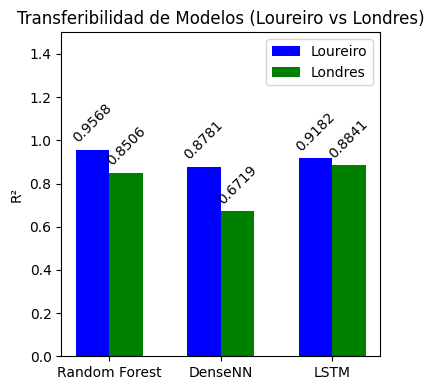

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos
modelos = ['Random Forest', 'DenseNN', 'LSTM']
r2_loureiro = [0.9568, 0.8781, 0.9182]
r2_londres = [0.8506, 0.6719, 0.8841]

x = np.arange(len(modelos))  # posiciones para cada modelo
width = 0.30  # ancho de las barras

fig, ax = plt.subplots(figsize=(4, 4))

# Barras
bars1 = ax.bar(x - width/2, r2_loureiro, width, label='Loureiro', color='blue')
bars2 = ax.bar(x + width/2, r2_londres, width, label='Londres', color='green')

# Añadir etiquetas de valor encima de cada barra
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # desplazamiento vertical
                textcoords="offset points",
                ha='center', va='bottom',
                rotation=45)

# Configuración del gráfico
ax.set_ylabel('R²')
ax.set_title('Transferibilidad de Modelos (Loureiro vs Londres)')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.set_ylim(0, 1.5)  # fijar el rango del eje y
ax.legend()

plt.tight_layout()
plt.show()
